# 提案手法の実験（ラベルが適切か出力）

## マルチサイズ
- データオーギュメンテーション（鏡映，回転を追加）

### import，入力データの読み込み

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/LSWMD.pkl


In [2]:
import os
from os.path import join
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

import csv

import numpy as np
import pandas as pd
import pickle
import copy
import cv2
import random
import glob

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import joblib

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(logical_gpus)
import keras
from tensorflow.keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
import keras.backend.tensorflow_backend as tfback
# from tf.keras.utils import multi_gpu_model


import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datapath = join('data', 'wafer')
print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU') memory growth: True
[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


Using TensorFlow backend.


['LSWMD.pkl']


In [3]:
# Define
max_size = 100
encord_size = int(max_size / 2)

MAKE_DATASET = False
TRAIN_AUTO_ENCODER = False

cnn_path = './model/cnn_' + str(max_size) + '.h5'

epoch = 30
batch_size = 2048

In [4]:
faulty_case = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']


### 各ウエハにラベル付け

In [5]:
# trials = 2
# label_list = []
# for i in range(new_x.shape[0]):
#     label_dict = {'wafer_id':str(i).zfill(6), 'true_label':y[i][0], 'predict_label':None, 'augmentation':{'noise':0, 'rotation':0, 'inversion':0}, 'trials':trials}
#     label_list.append(label_dict)

In [6]:
# print(label_list[1])

- 不良ラベルが付いているデータに対してデータオーギュメンテーションを行う．

### 学習を行う
- 不良ラベルを0-8の9次元のベクトルとして表現する．
- one-hotエンコーディングを行っている．

- 保存/読み込み

In [7]:
# MAKE_DATASET = False
# ver = 'shawon' if shawon else 'propose'
# if MAKE_DATASET:
#     pickle_dump(new_x, './data/new_x_' + ver + '.pickle')
#     pickle_dump(new_y, './data/new_y_' + ver + '.pickle')
#     pickle_dump(label_list, './data/label_list_' + ver + '.pickle')
    
# if not MAKE_DATASET:
#     new_x = pickle_load('./data/new_x_' + ver + '.pickle')
#     new_y = pickle_load('./data/new_y_' + ver + '.pickle')
#     label_list = pickle_load('./data/label_list_' + ver + '.pickle')

In [8]:
# for i, l in enumerate(faulty_case):
#     new_y[new_y==l] = i

In [9]:
# for i in range(len(label_list)):
#     label_list[i]['true_label'] = new_y[i][0]

### データの読み出し

In [34]:
# acquire the .npy name
data_size = len(glob.glob('./data/multi_' + str(max_size) + '/train/' + '*.npy'))
TRAINS = ['./data/multi_' + str(max_size) + '/train/' + str(i) + '.npy' for i in range(data_size)]
# one-hot-encoding
y = joblib.load('./data/multi_' + str(max_size) + '/train/y.pickle')
new_y = to_categorical(y)
# split test

shuffle_indices = random.sample(list(range(len(TRAINS))), 10000)
TRAINS = [TRAINS[i] for i in shuffle_indices]
new_y = new_y[shuffle_indices]

indices = np.array(range(len(TRAINS)))
x_train, x_validation, y_train, y_validation, indices_train, indices_validation = train_test_split(
    TRAINS, new_y, indices, test_size=0.01, random_state=2020)

In [35]:
# batchを取得する関数
from multiprocessing import Pool
import time

def load_array(file):
    return np.load(file)

def get_batch(batch_size): 
    global x_train, y_train
    SIZE = len(x_train)
    # n_batchs
    n_batchs = SIZE//batch_size + 1
    # for でyield
    i = 0
    start = time.time()
    while (i < n_batchs):
        print("doing", i, "/", n_batchs)
        Y_batch = y_train[(i * batch_size):((i + 1) * batch_size)]
        
        #あるbatchのfilenameの配列を持っておく
        X_batch_name = x_train[(i * batch_size):((i + 1) * batch_size)]

        # filenameにしたがってバッチのtensorを構築
        with Pool() as p:
            arr = p.map(load_array, X_batch_name)
            
        X_batch = np.array(arr).reshape(len(X_batch_name), max_size, max_size, 3)
#         X_batch = np.array([np.load(file)
#                             for file in X_batch_name]).reshape(len(X_batch_name), max_size, max_size, 3)
        i += 1
        print('elapsed time', time.time()-start)
        yield X_batch, Y_batch

In [36]:
# # testsize = 2000
# # randlist = rand_ints_nodup(0, new_x.shape[0]-1, testsize)

# # valx = new_x.copy()[randlist, :, :, :]
# # valy = y.copy()[randlist, :]

# test_size = 705 #705
# new_x_size = new_x.shape[0]
# testlist = rand_ints_nodup(0, new_x_size-1, test_size)
# trainlist = [i for i in range(new_x_size) if i != testlist]
# new_X=new_x[trainlist]
# new_Y=new_y[trainlist]
# test_x=new_x[testlist]
# test_y=new_y[testlist]

# label_train = copy.deepcopy([label_list[i] for i in trainlist])
# label_test = copy.deepcopy([label_list[i] for i in testlist])

# test_x.shape

In [37]:
# new_X=new_x
# new_Y=new_y

- 学習データとテストデータに分割する．

In [38]:
# indices = np.array(range(new_X.shape[0]))

# x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(new_X, new_Y, indices,
#                                                                 test_size=0.33,
#                                                                 random_state=2020)

In [39]:
# label_vali = copy.deepcopy([label_train[i] for i in indices_test.tolist()])
# label_train = copy.deepcopy([label_train[i] for i in indices_train.tolist()])

In [40]:
print('Train x : {}, y : {}'.format(len(x_train), y_train.shape))
print('Validation x: {}, y : {}'.format(len(x_validation), y_validation.shape))

Train x : 9900, y : (9900, 9)
Validation x: 100, y : (100, 9)


In [41]:
print("loading X_validation...")
x_validation = np.array([np.load(file) for file in x_validation]).reshape(-1, max_size, max_size, 3)

loading X_validation...


In [44]:
x_train = np.array([np.load(file) for file in x_train]).reshape(-1, max_size, max_size, 3)


Edge-Ring


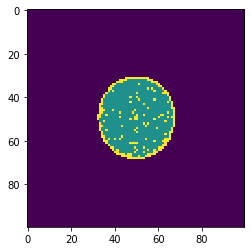

Near-full


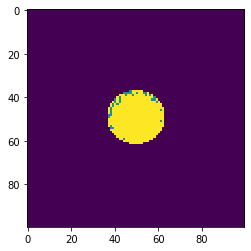

Loc


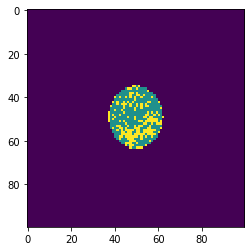

Edge-Ring


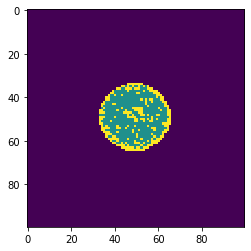

Loc


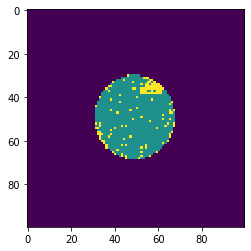

Random


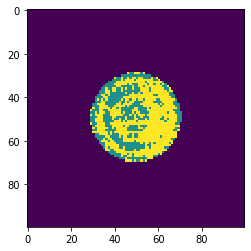

Loc


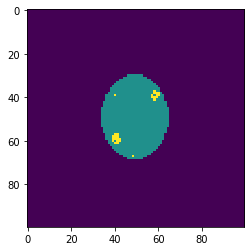

Edge-Ring


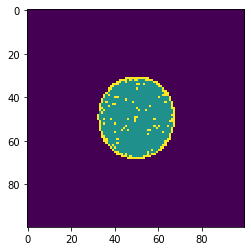

Scratch


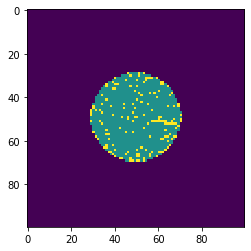

Scratch


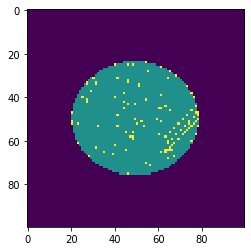

Edge-Ring


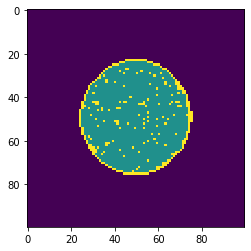

Scratch


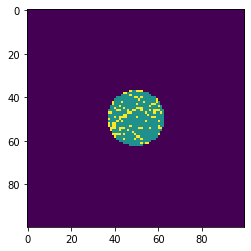

none


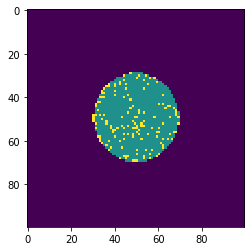

Edge-Loc


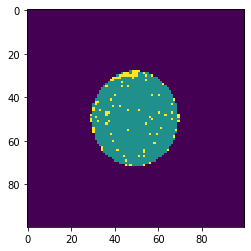

Donut


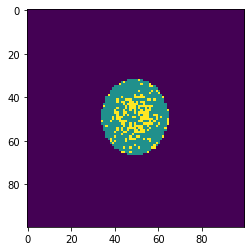

Scratch


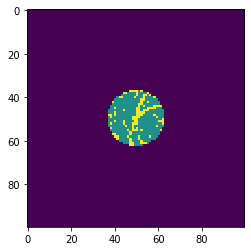

Edge-Ring


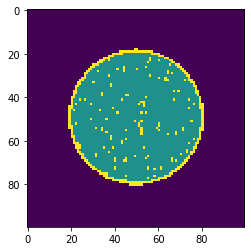

Random


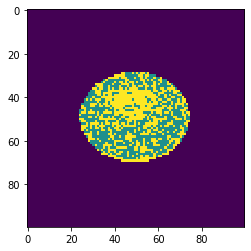

Edge-Loc


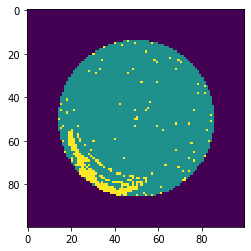

Near-full


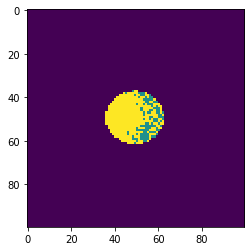

Near-full


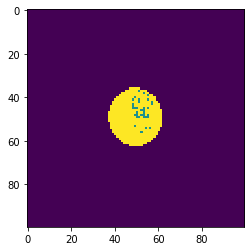

Edge-Loc


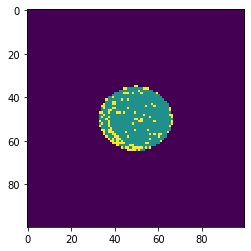

Random


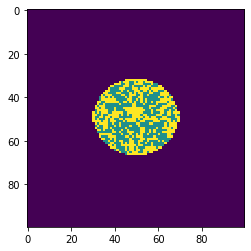

Edge-Loc


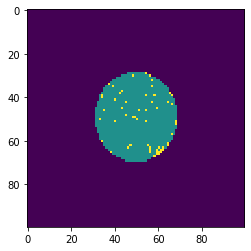

Scratch


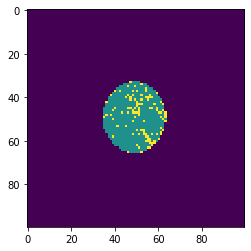

Loc


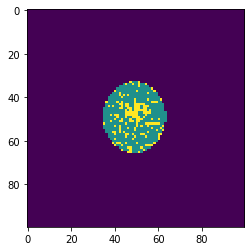

Center


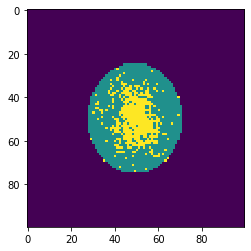

Random


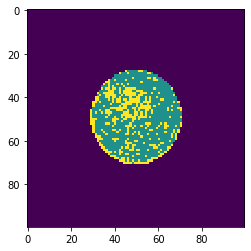

Center


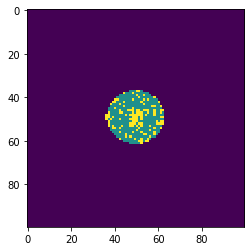

Donut


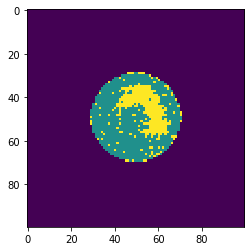

Random


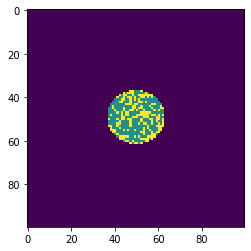

Donut


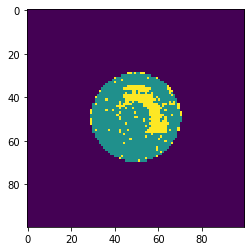

none


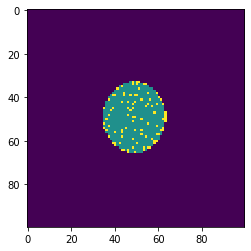

none


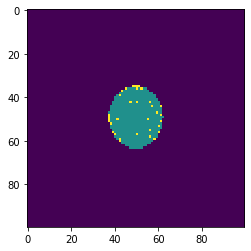

Center


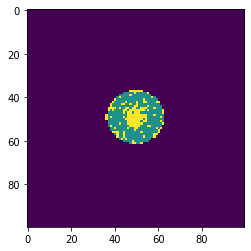

Edge-Ring


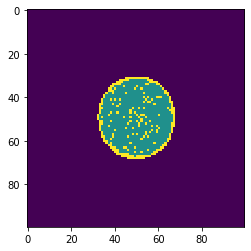

Scratch


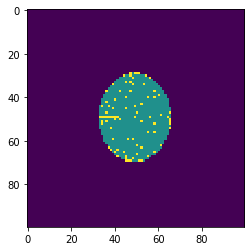

Donut


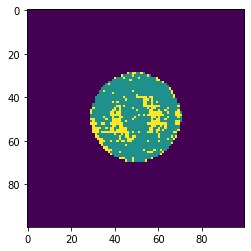

Edge-Loc


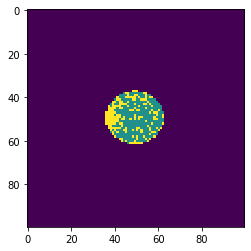

Edge-Ring


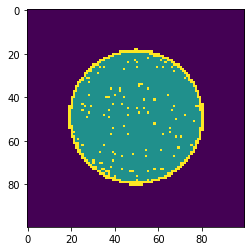

Edge-Loc


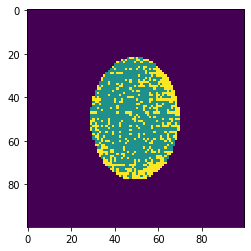

Loc


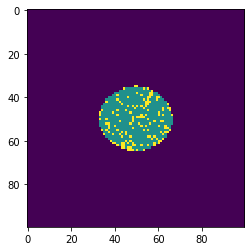

Donut


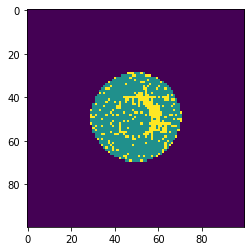

Center


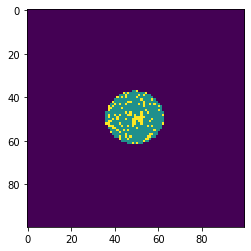

Edge-Ring


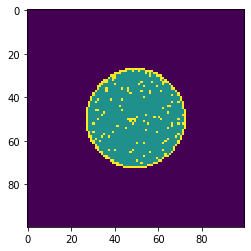

Edge-Loc


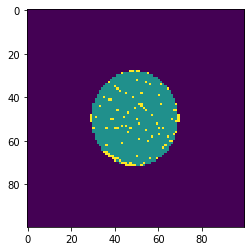

Center


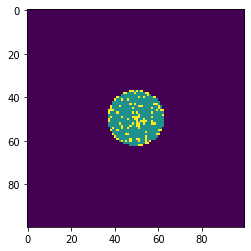

Edge-Ring


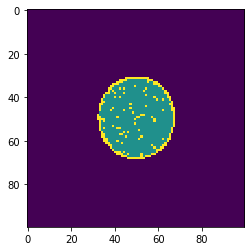

Random


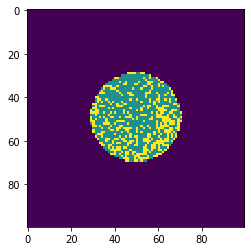

Edge-Ring


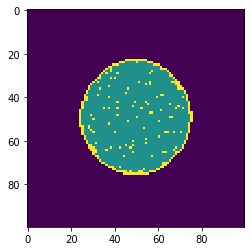

Loc


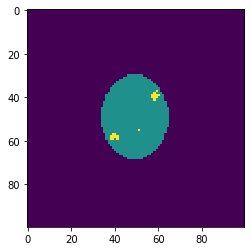

Near-full


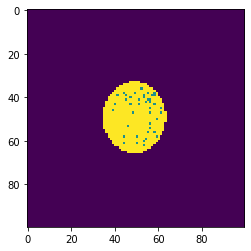

Center


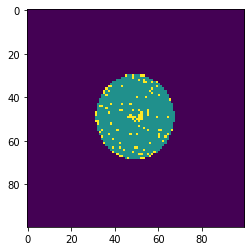

Near-full


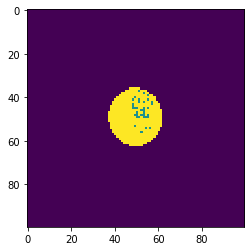

Center


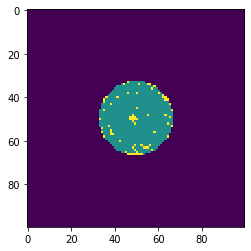

none


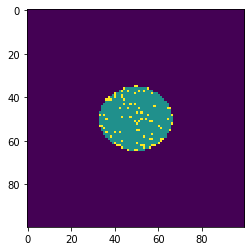

Loc


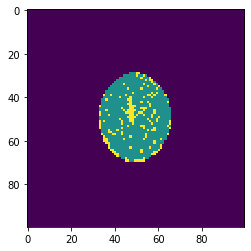

Edge-Loc


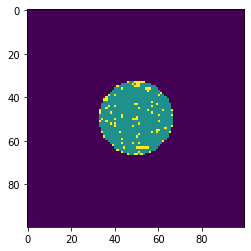

Donut


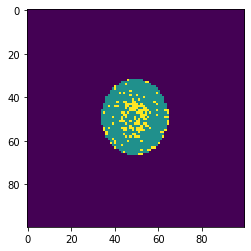

Donut


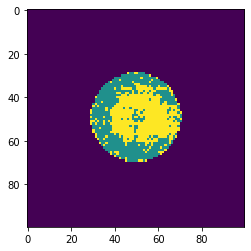

Scratch


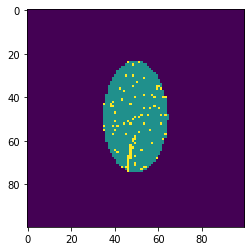

Near-full


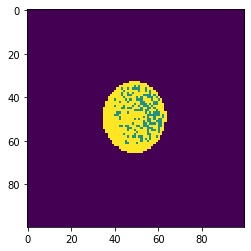

Center


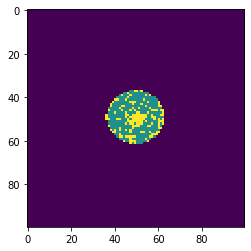

Edge-Loc


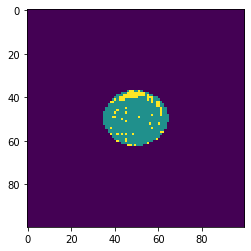

Center


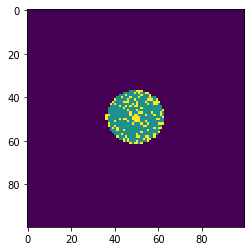

Random


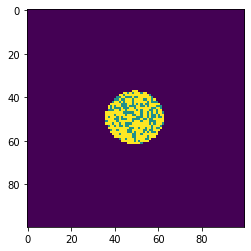

Center


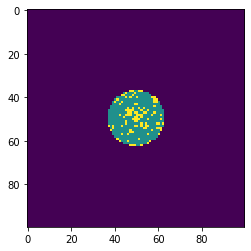

none


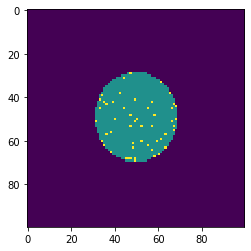

Donut


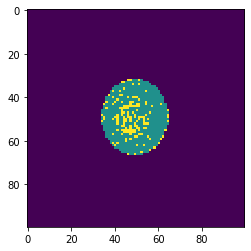

Center


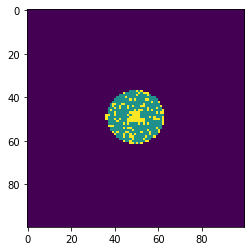

Loc


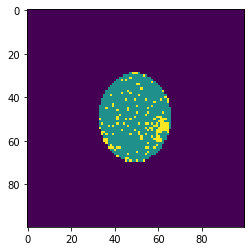

Donut


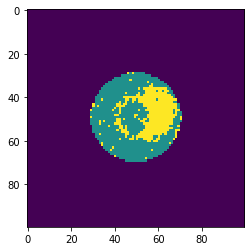

Near-full


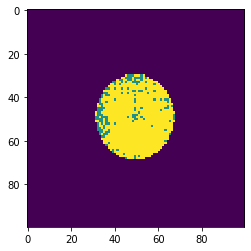

Edge-Ring


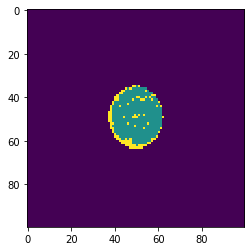

Loc


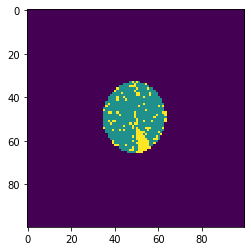

Donut


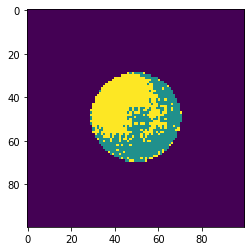

Edge-Ring


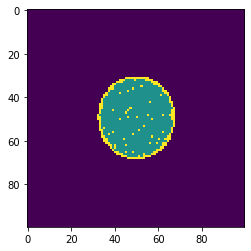

Center


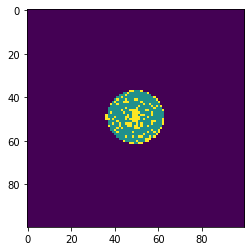

Center


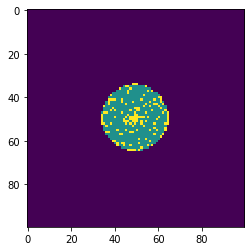

Near-full


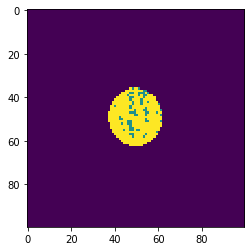

Scratch


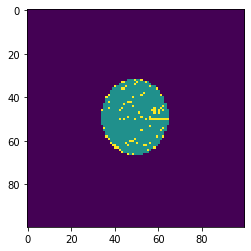

Random


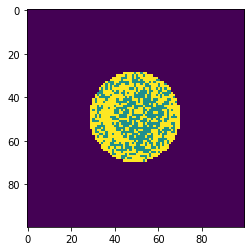

Loc


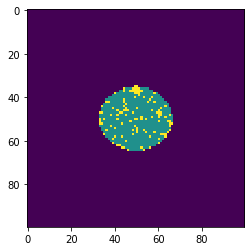

Edge-Ring


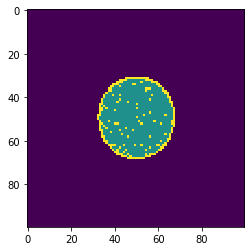

Loc


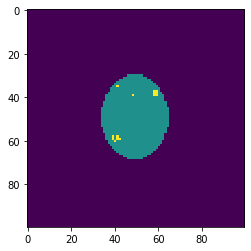

Random


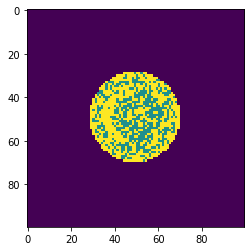

Scratch


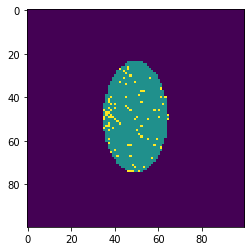

Edge-Loc


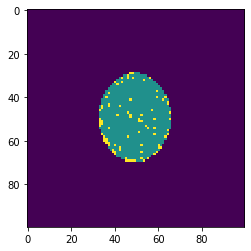

Edge-Ring


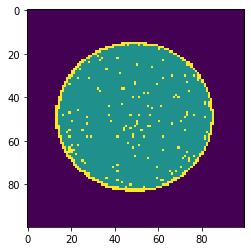

none


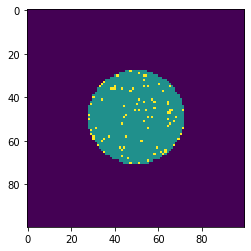

Near-full


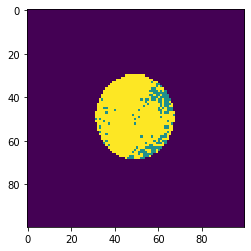

Edge-Ring


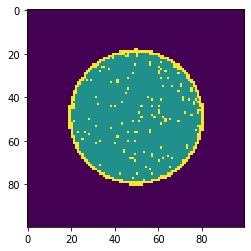

Random


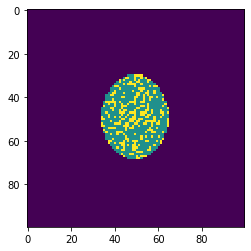

Edge-Loc


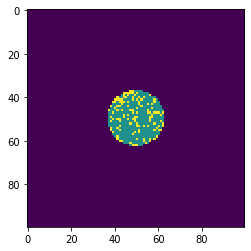

Loc


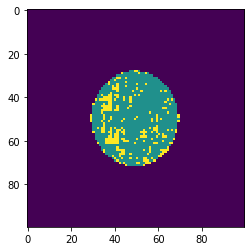

Near-full


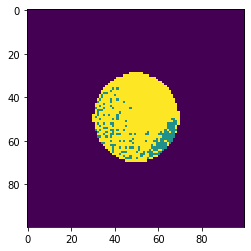

Random


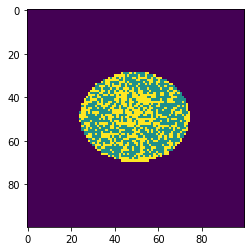

Edge-Loc


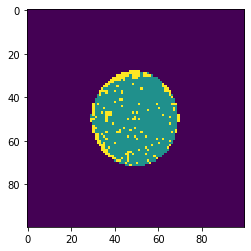

Scratch


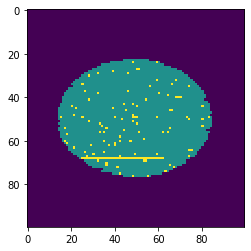

Near-full


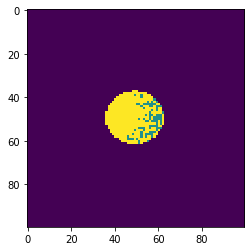

Edge-Loc


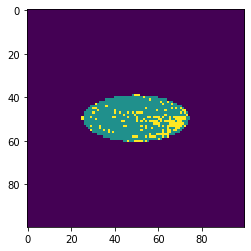

Random


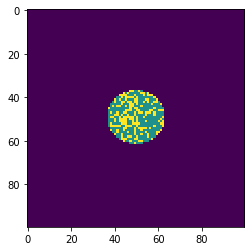

Center


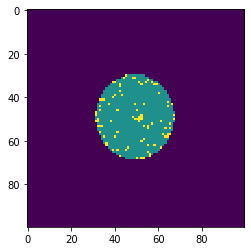

Near-full


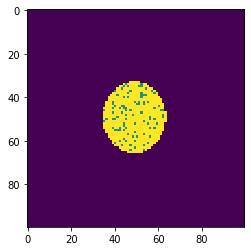

Random


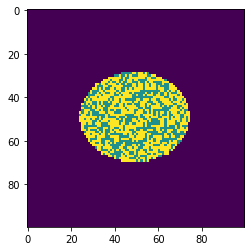

Edge-Ring


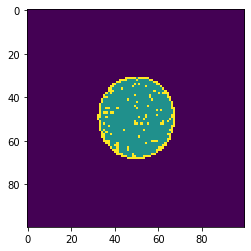

Donut


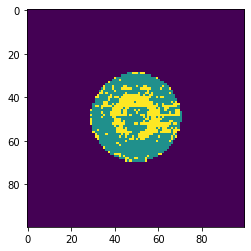

Edge-Loc


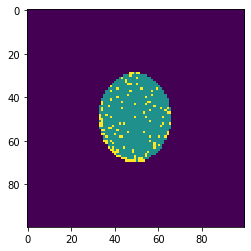

Near-full


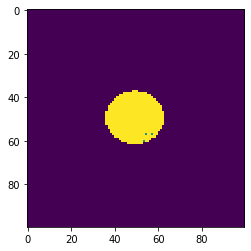

Loc


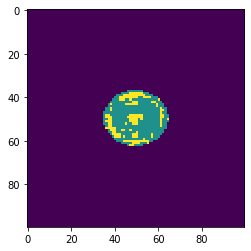

Edge-Ring


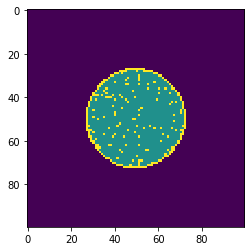

Edge-Ring


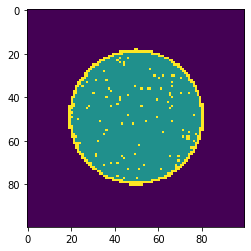

Donut


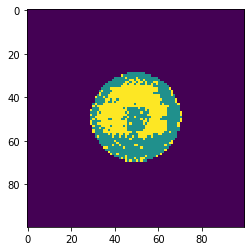

Edge-Ring


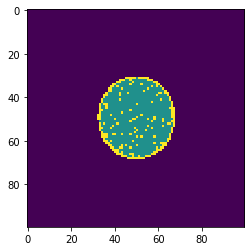

Center


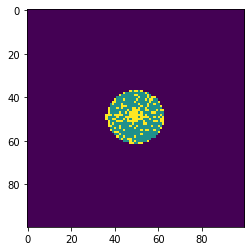

Edge-Loc


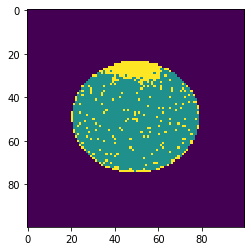

Near-full


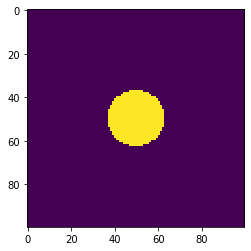

Edge-Loc


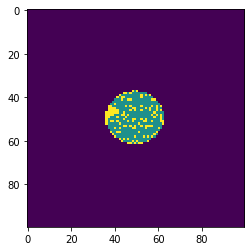

Center


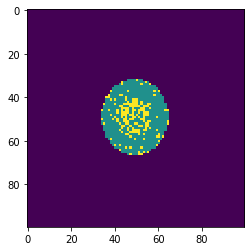

Edge-Ring


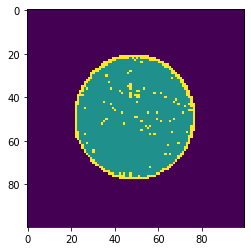

Near-full


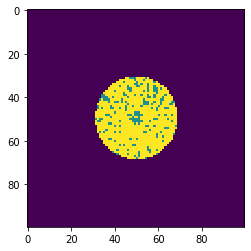

Edge-Loc


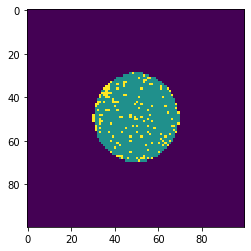

none


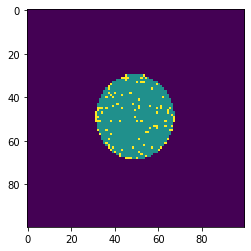

Edge-Loc


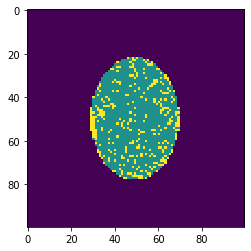

Edge-Ring


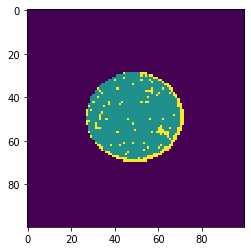

Edge-Loc


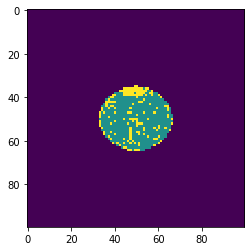

Loc


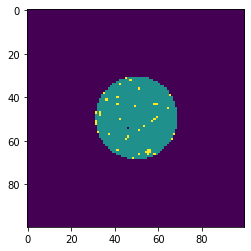

Donut


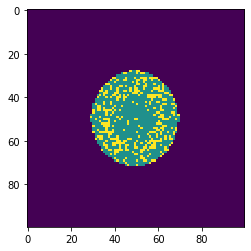

Scratch


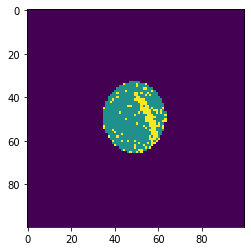

none


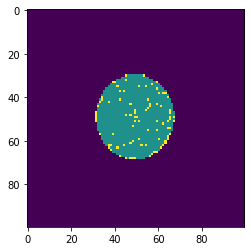

Edge-Ring


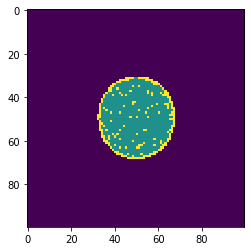

Random


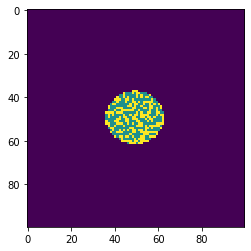

Scratch


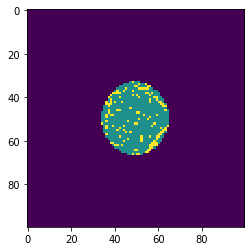

Edge-Loc


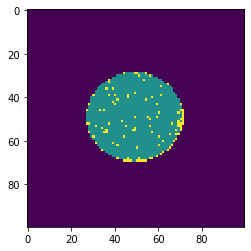

Center


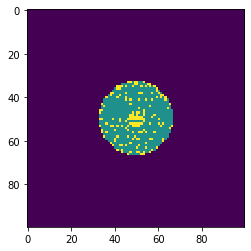

Random


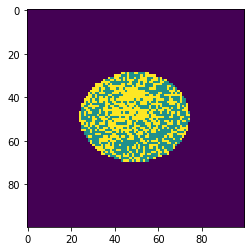

Loc


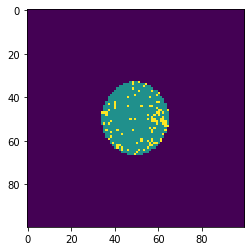

Scratch


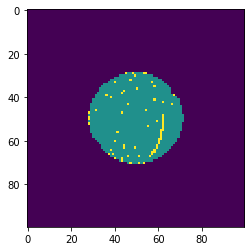

Center


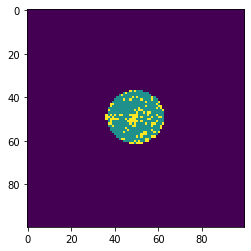

Donut


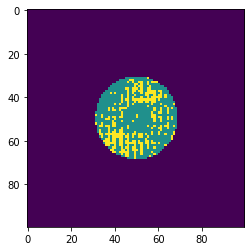

Scratch


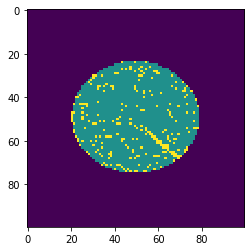

Loc


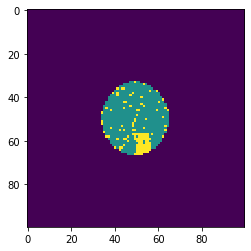

Edge-Ring


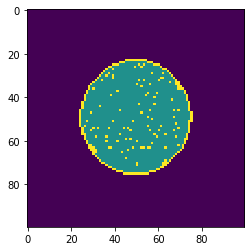

Random


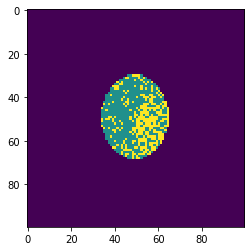

Center


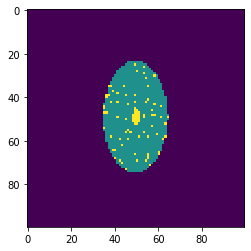

Scratch


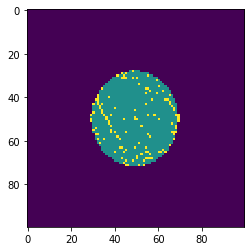

Edge-Ring


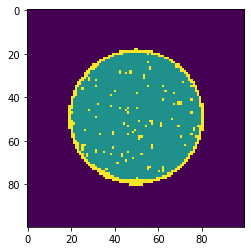

Near-full


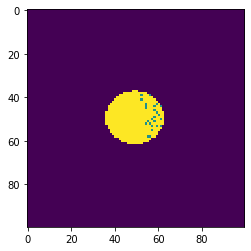

Scratch


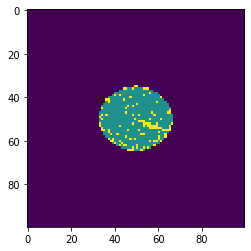

Scratch


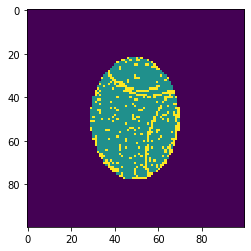

Scratch


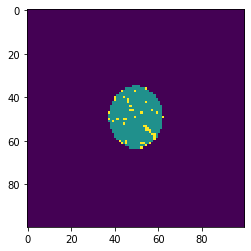

Near-full


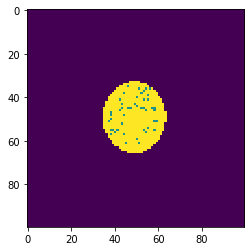

Near-full


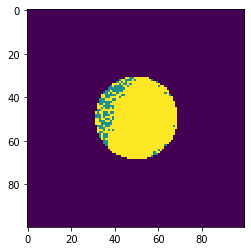

Random


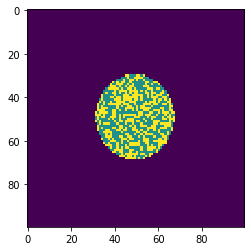

Loc


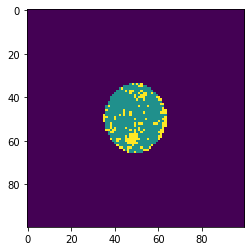

Scratch


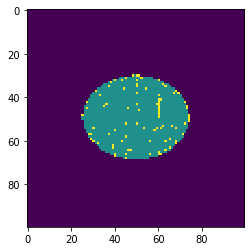

Loc


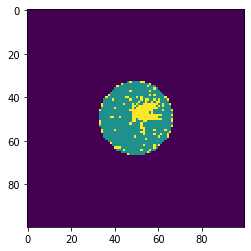

none


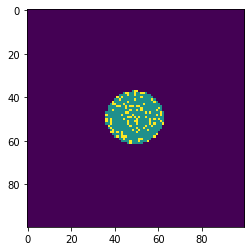

none


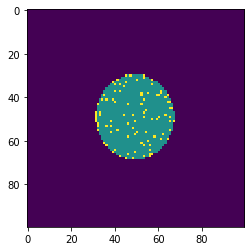

Donut


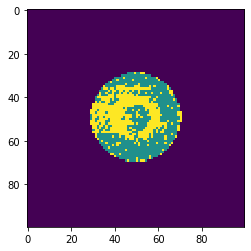

Edge-Loc


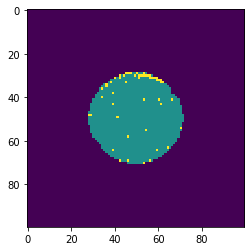

Edge-Loc


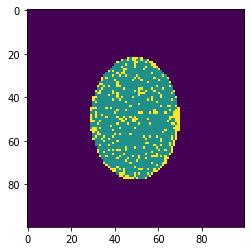

none


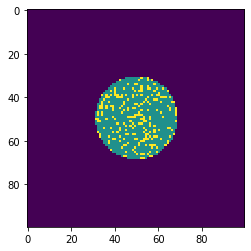

Center


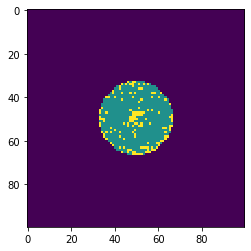

Loc


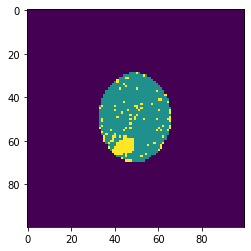

Edge-Loc


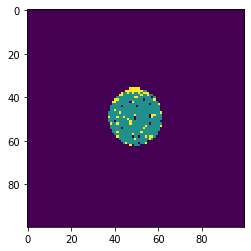

Near-full


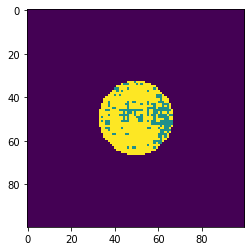

Random


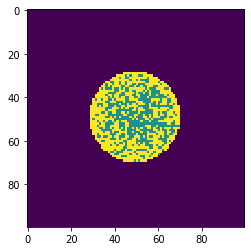

Loc


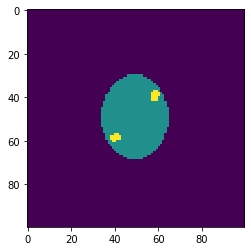

Donut


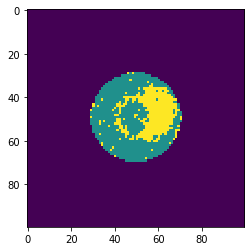

Center


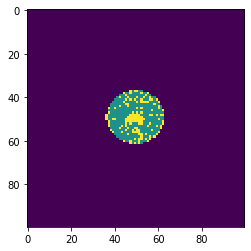

Donut


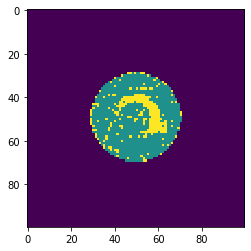

Edge-Ring


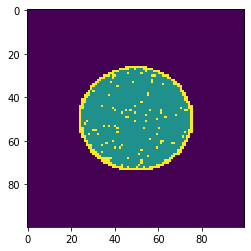

Near-full


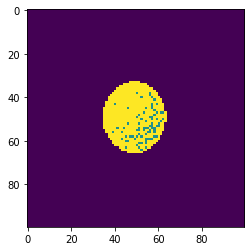

none


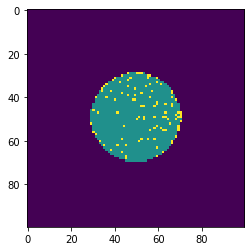

Loc


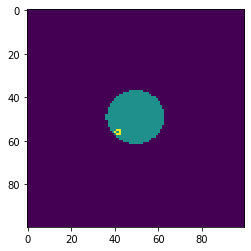

Near-full


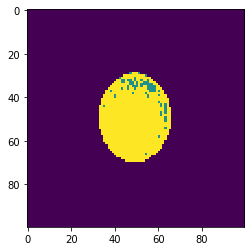

Random


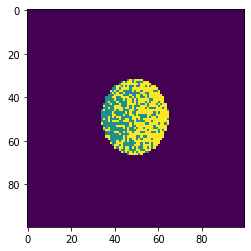

Random


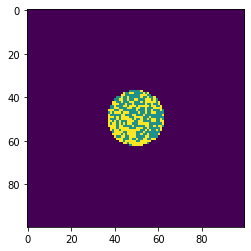

Edge-Ring


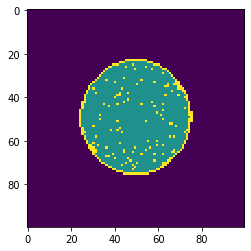

Random


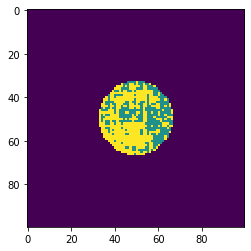

Near-full


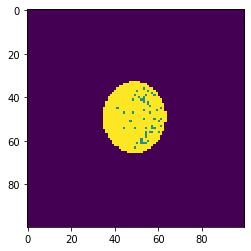

Loc


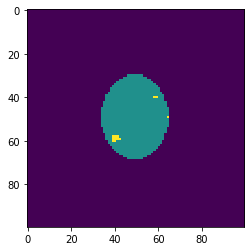

none


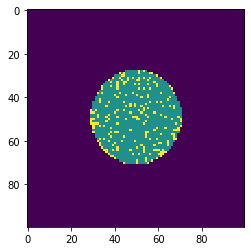

Loc


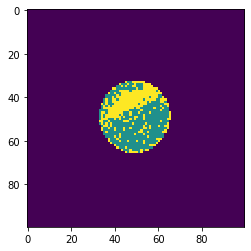

Random


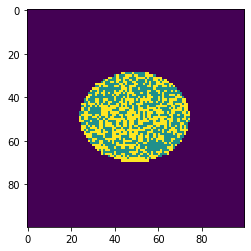

Edge-Loc


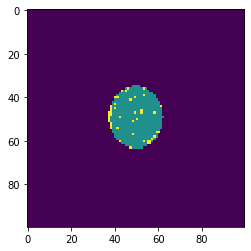

Scratch


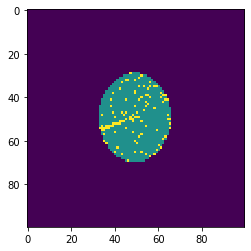

Edge-Ring


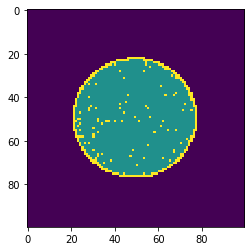

Donut


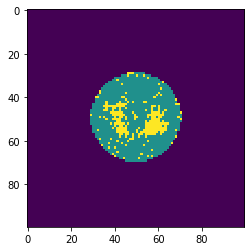

Donut


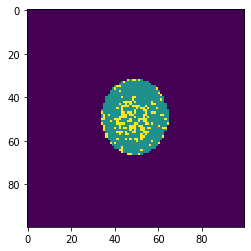

Center


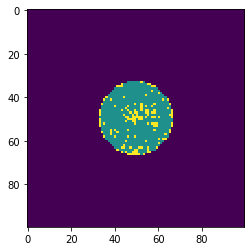

Near-full


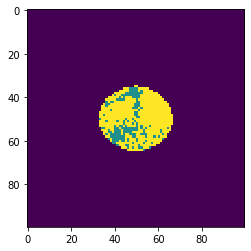

Donut


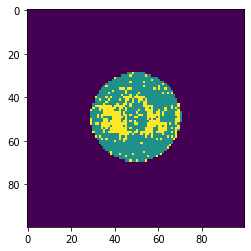

Donut


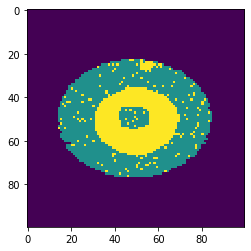

Edge-Ring


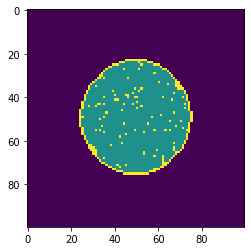

none


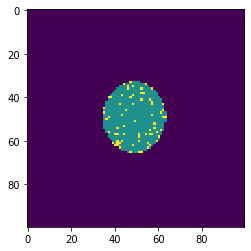

Center


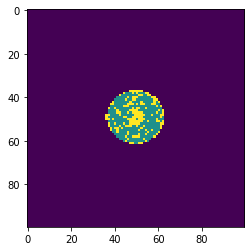

Edge-Loc


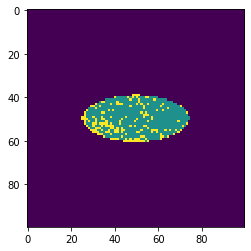

Loc


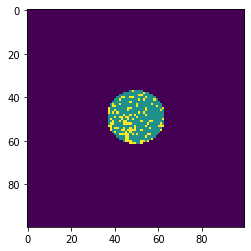

Edge-Ring


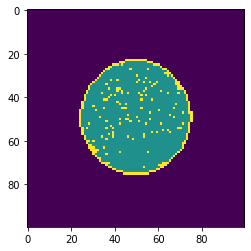

Scratch


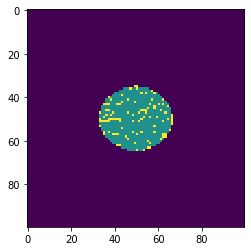

Edge-Ring


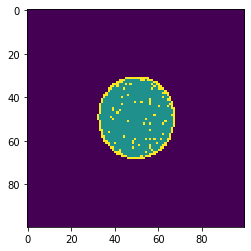

Loc


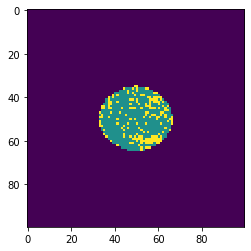

Random


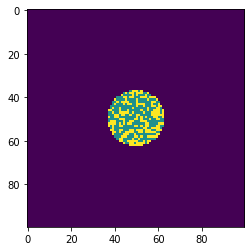

Donut


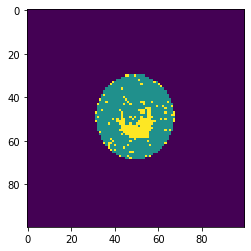

none


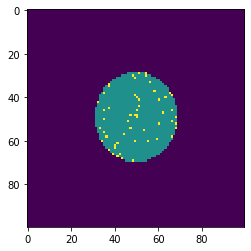

none


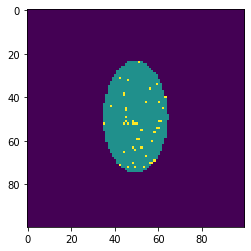

none


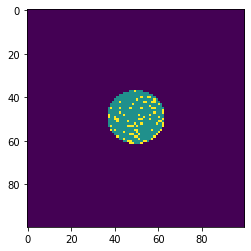

Edge-Ring


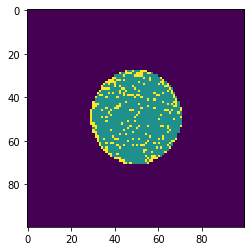

Donut


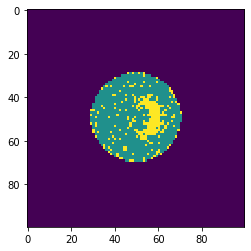

none


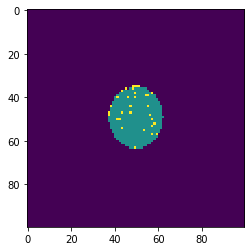

Center


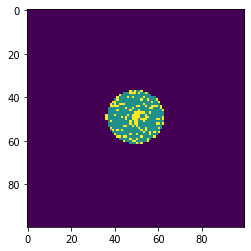

Center


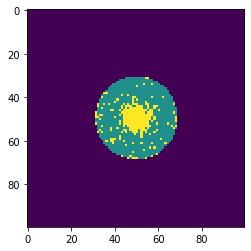

Center


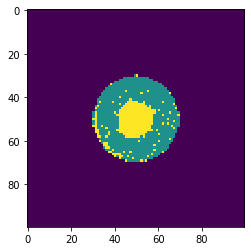

Random


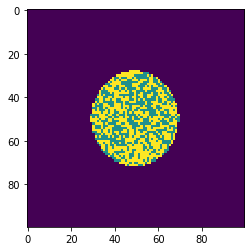

Edge-Loc


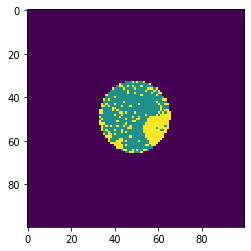

Edge-Ring


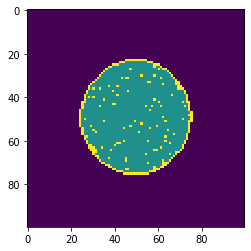

Center


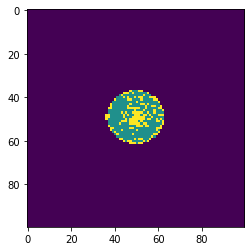

Random


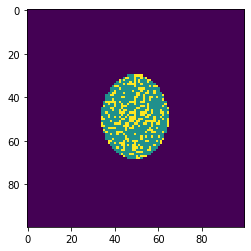

Edge-Ring


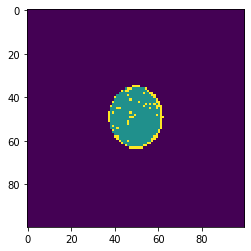

Near-full


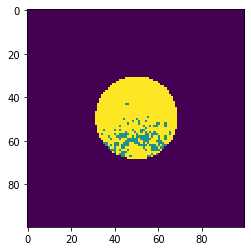

Near-full


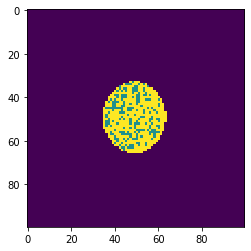

Center


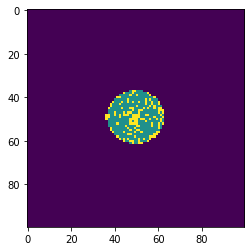

Scratch


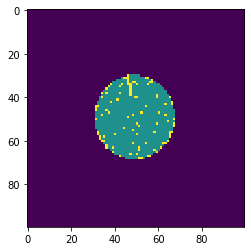

Loc


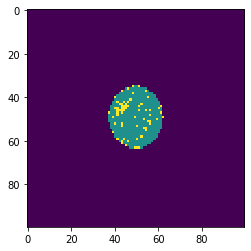

Edge-Ring


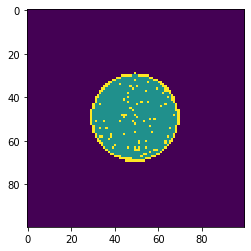

Near-full


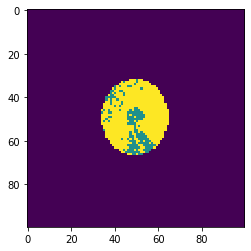

none


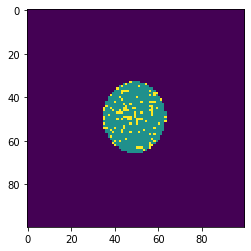

Edge-Ring


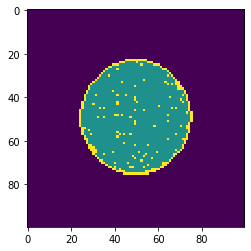

Donut


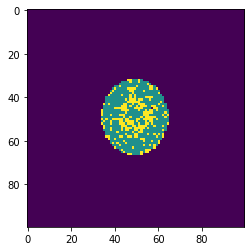

Near-full


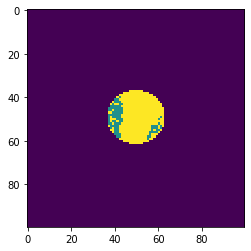

Center


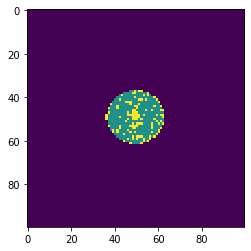

Edge-Loc


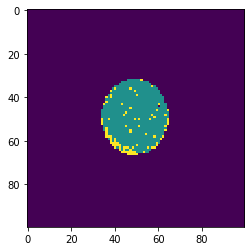

Center


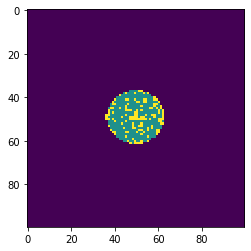

Scratch


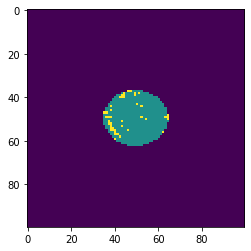

Donut


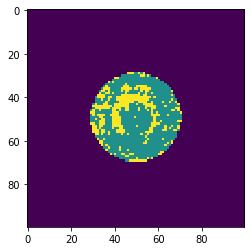

none


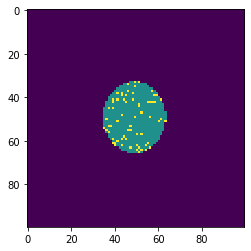

Center


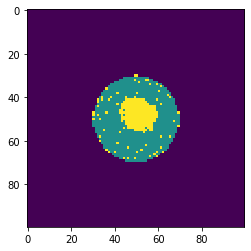

Scratch


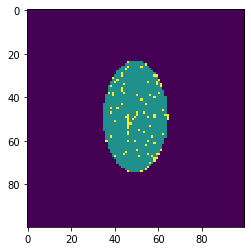

Near-full


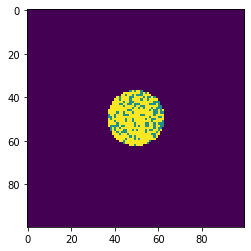

Loc


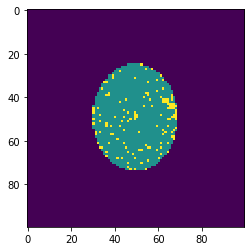

Edge-Ring


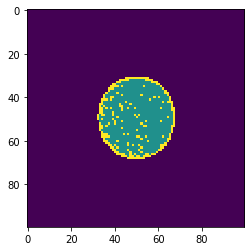

Donut


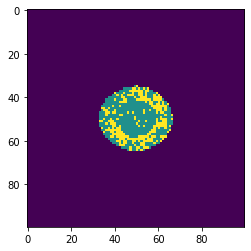

Loc


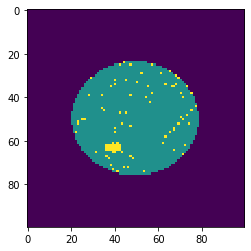

Scratch


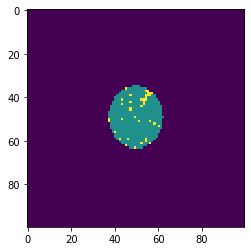

Edge-Ring


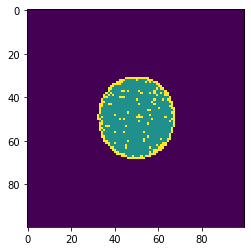

Edge-Loc


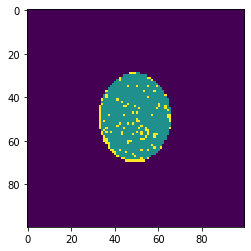

Edge-Ring


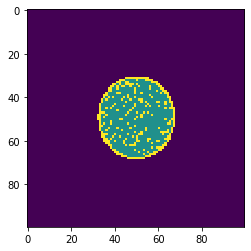

Loc


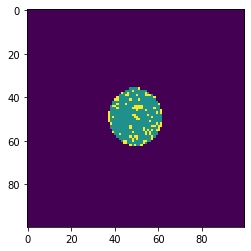

Random


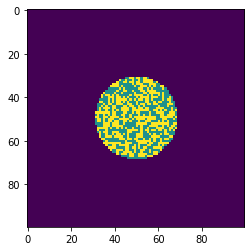

Center


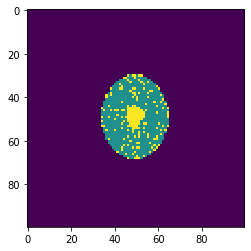

Edge-Loc


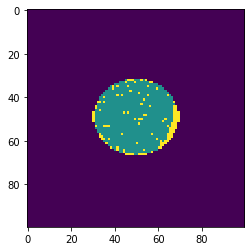

Center


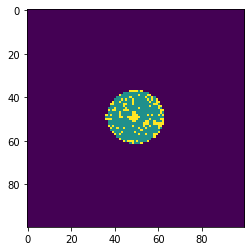

Near-full


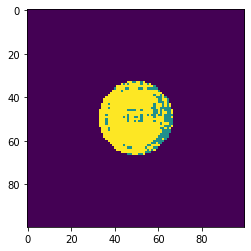

none


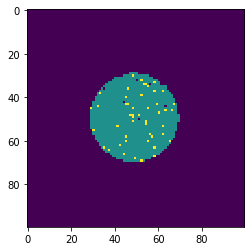

Scratch


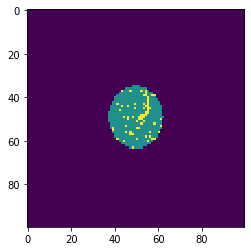

Edge-Loc


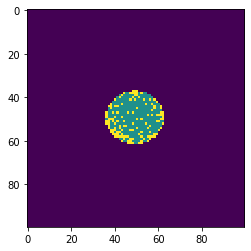

Edge-Ring


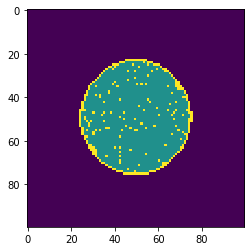

Loc


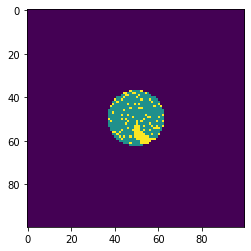

none


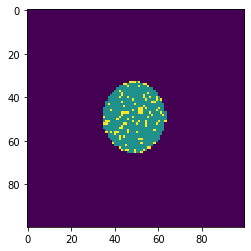

Random


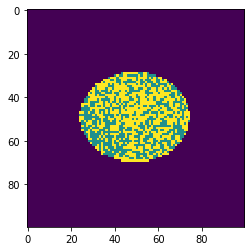

Edge-Loc


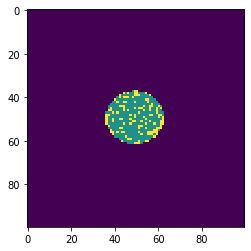

Center


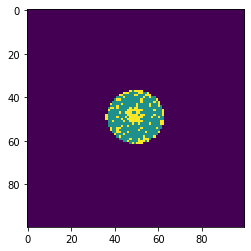

Near-full


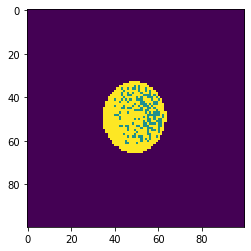

none


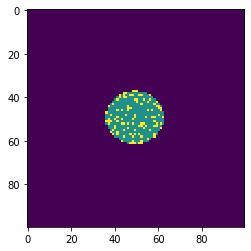

Loc


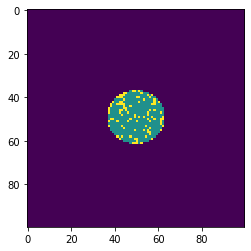

none


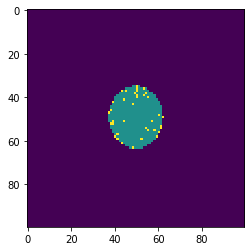

Random


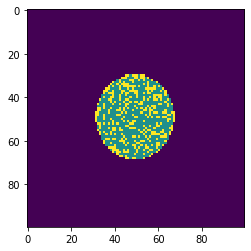

Random


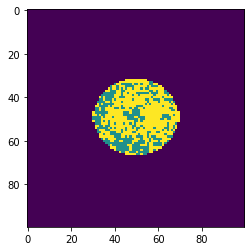

Loc


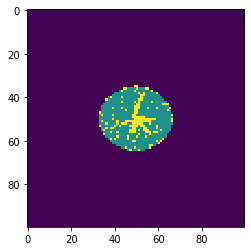

Center


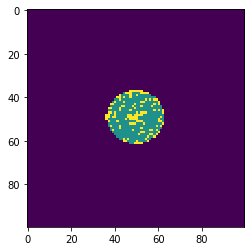

Donut


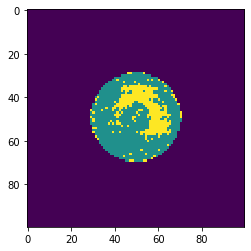

Loc


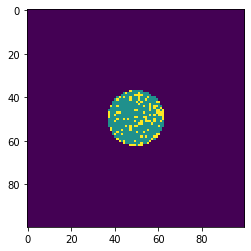

Loc


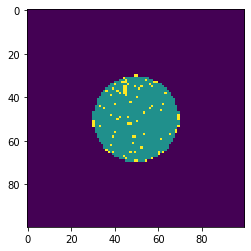

Center


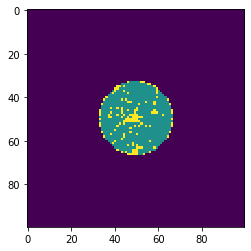

Center


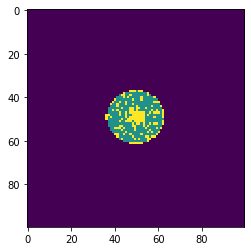

Center


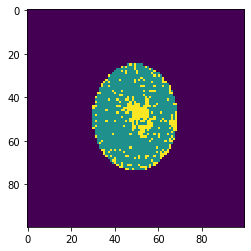

Loc


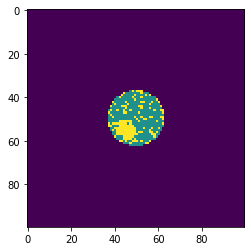

Loc


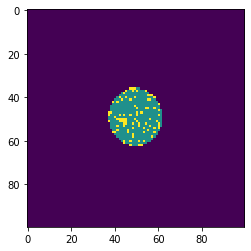

Near-full


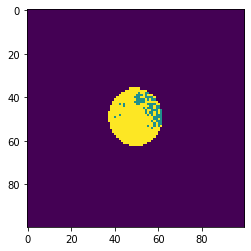

Loc


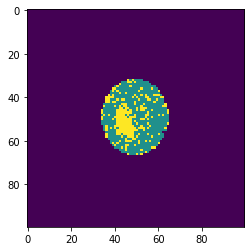

Edge-Ring


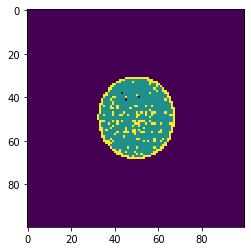

none


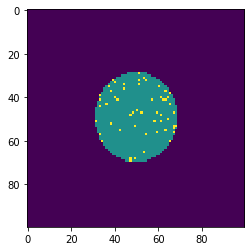

Edge-Ring


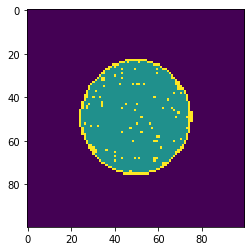

Edge-Ring


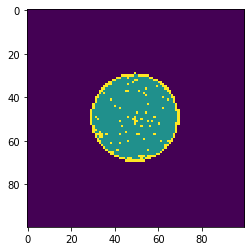

Edge-Ring


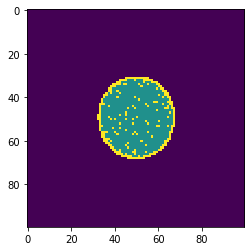

Edge-Ring


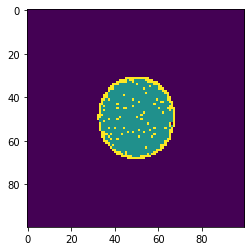

Center


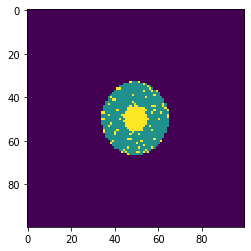

Center


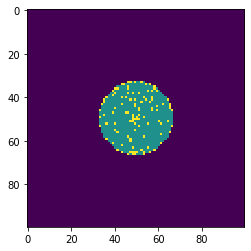

Edge-Ring


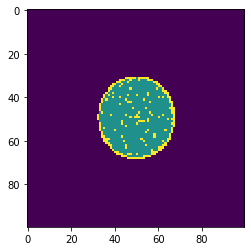

Loc


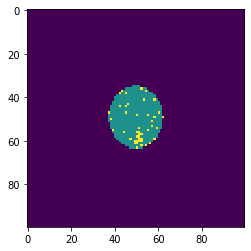

Loc


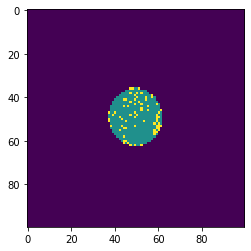

Near-full


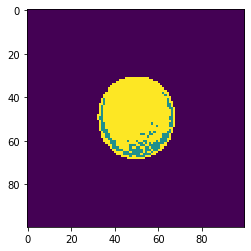

Edge-Loc


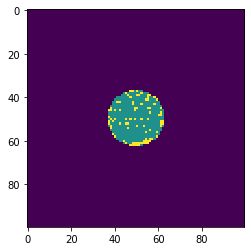

Edge-Loc


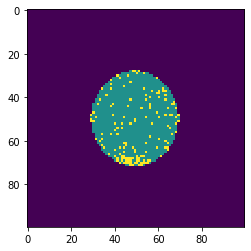

none


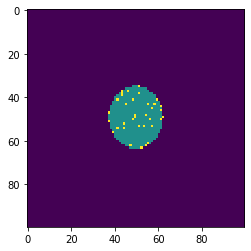

Edge-Loc


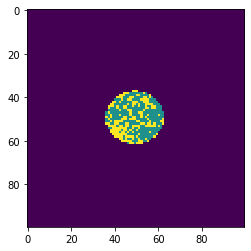

Scratch


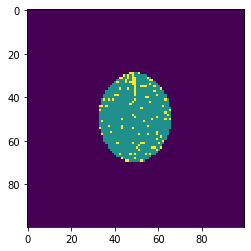

Edge-Ring


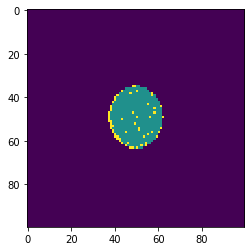

Loc


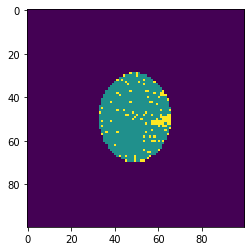

Random


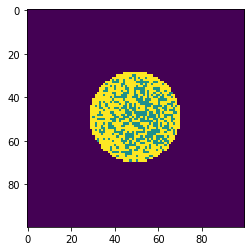

Center


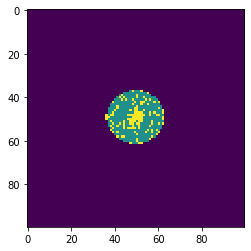

Edge-Ring


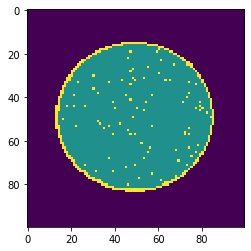

Edge-Loc


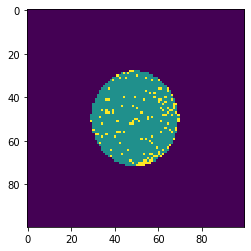

Edge-Ring


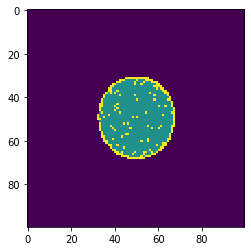

Edge-Ring


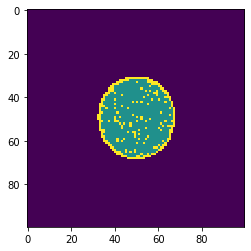

Edge-Loc


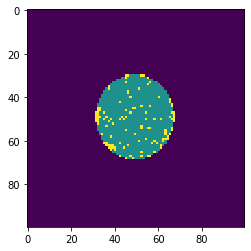

Near-full


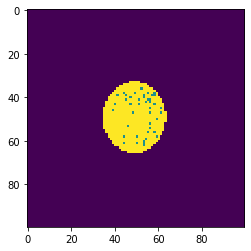

Center


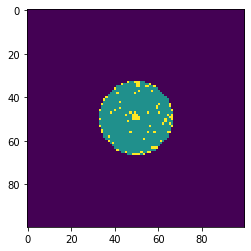

Edge-Loc


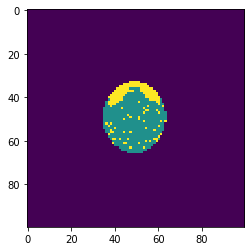

Edge-Ring


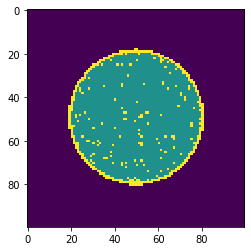

Edge-Ring


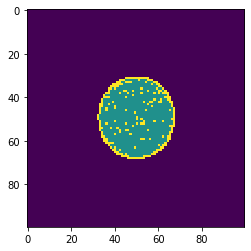

Edge-Loc


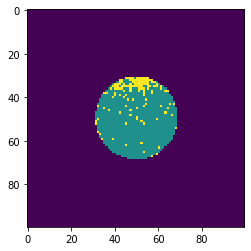

Random


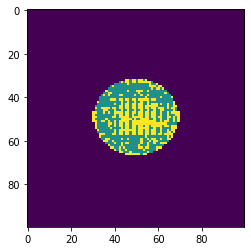

Edge-Ring


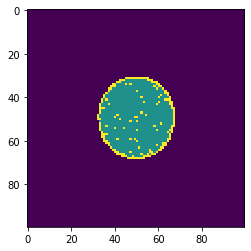

Donut


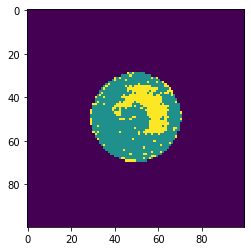

Loc


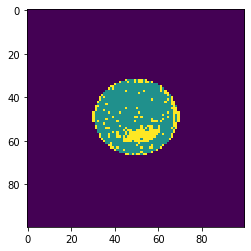

Near-full


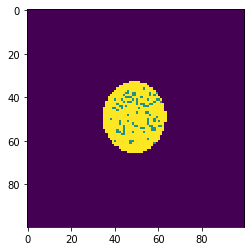

Scratch


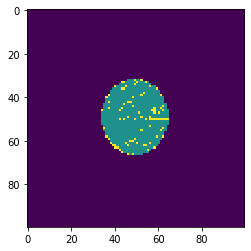

Edge-Ring


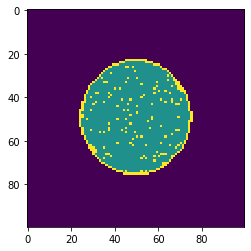

Scratch


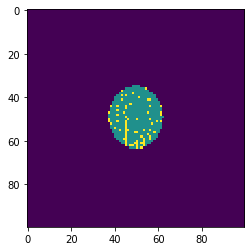

Edge-Ring


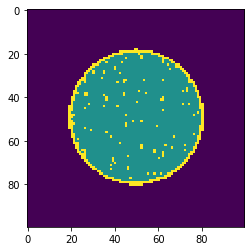

Near-full


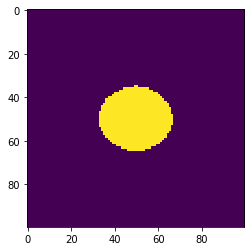

Random


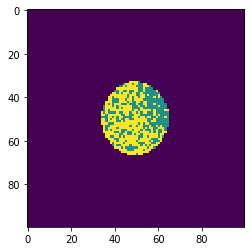

Scratch


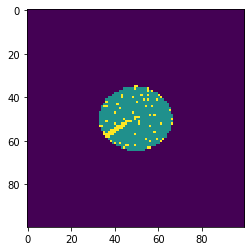

Edge-Ring


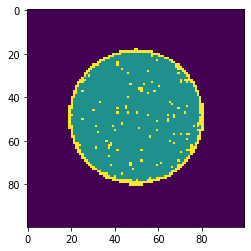

Loc


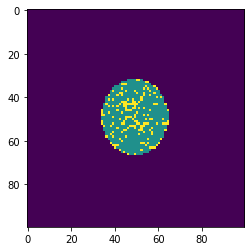

Scratch


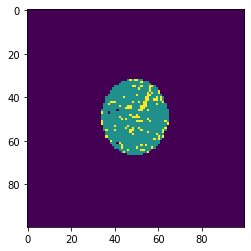

Loc


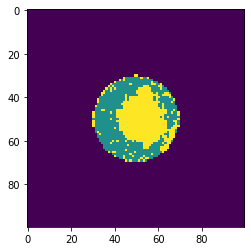

none


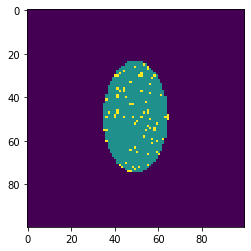

Near-full


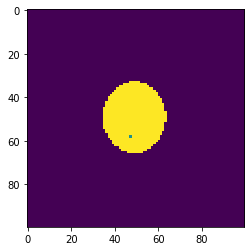

Donut


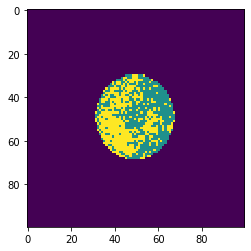

Edge-Loc


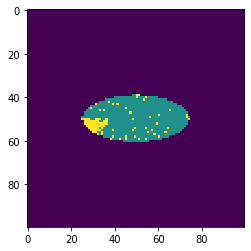

Near-full


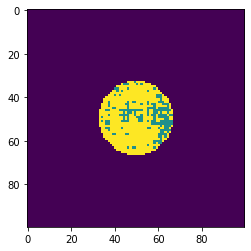

Scratch


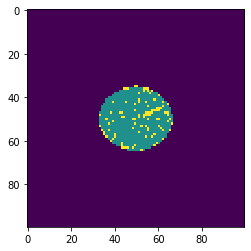

Loc


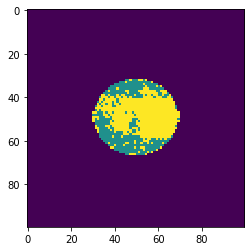

Scratch


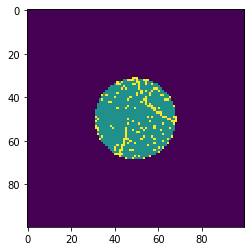

Center


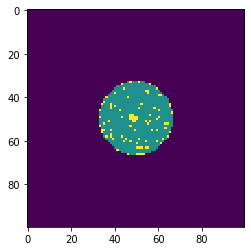

Edge-Ring


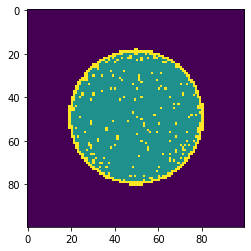

Edge-Ring


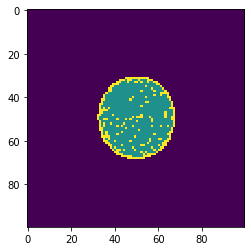

Edge-Loc


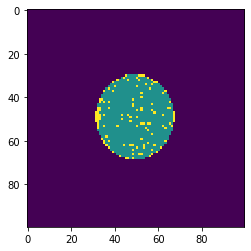

none


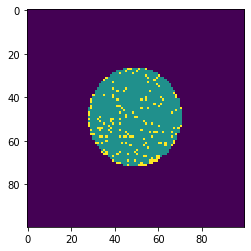

none


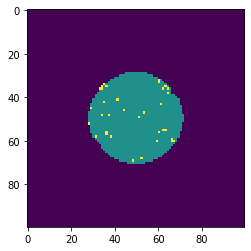

Near-full


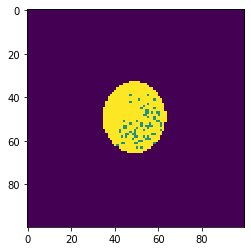

Center


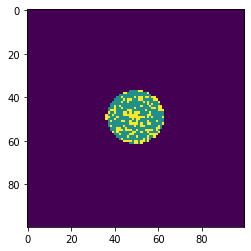

Edge-Loc


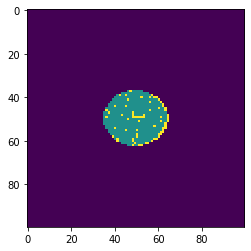

Donut


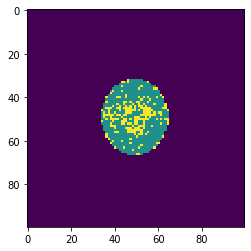

none


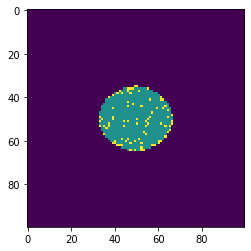

Center


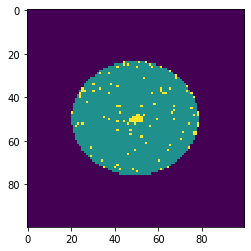

Scratch


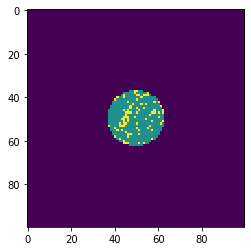

Scratch


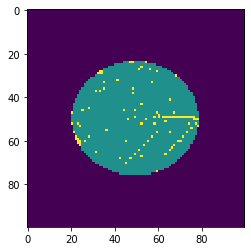

Edge-Ring


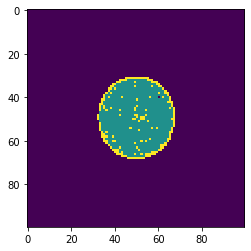

Loc


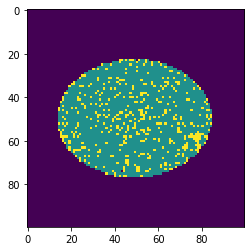

Donut


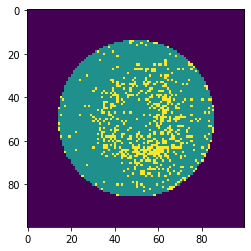

Donut


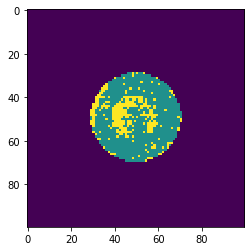

Donut


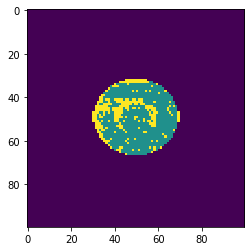

Scratch


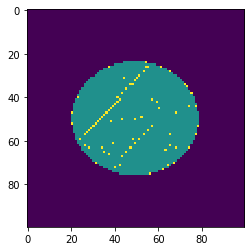

Edge-Ring


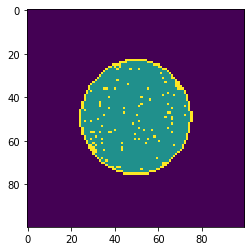

Center


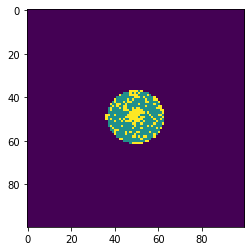

Scratch


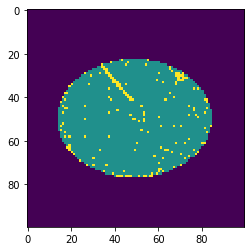

Edge-Loc


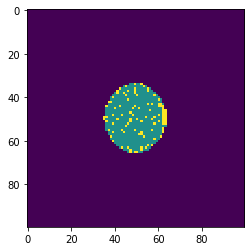

Donut


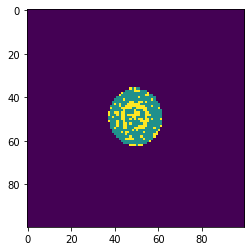

Edge-Ring


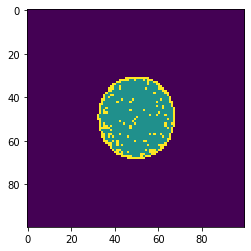

Near-full


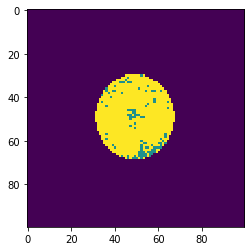

Loc


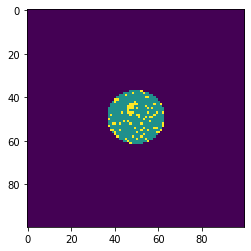

Edge-Ring


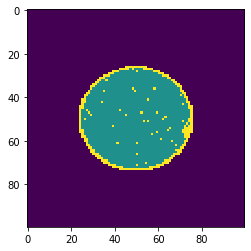

none


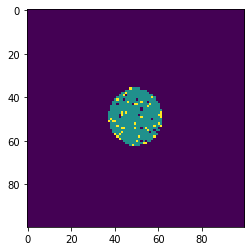

Edge-Loc


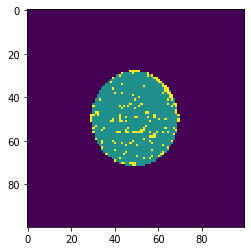

Near-full


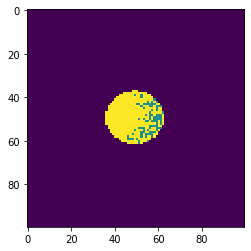

Donut


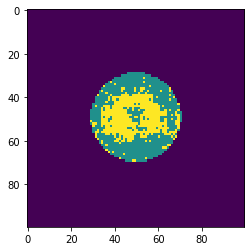

Scratch


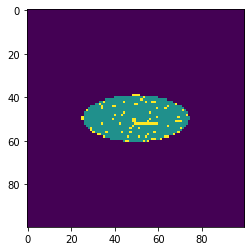

Edge-Ring


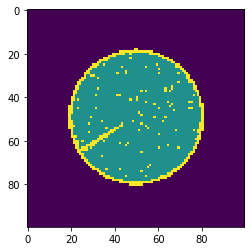

Random


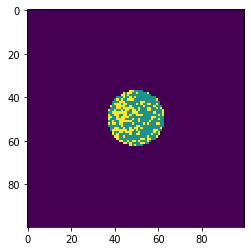

Donut


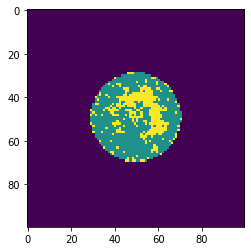

Random


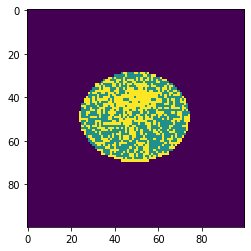

Edge-Loc


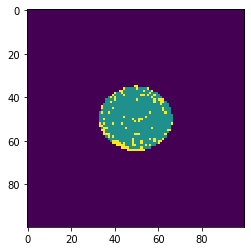

Edge-Ring


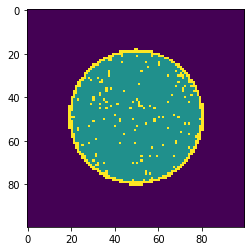

Edge-Loc


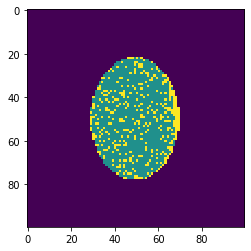

Near-full


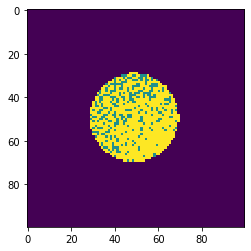

Edge-Ring


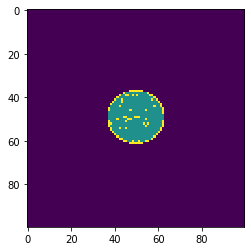

Loc


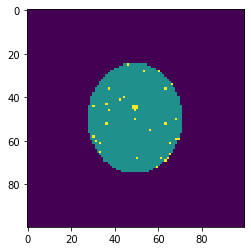

Edge-Ring


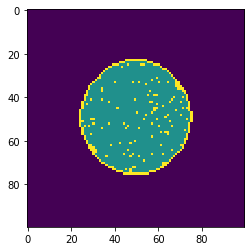

Center


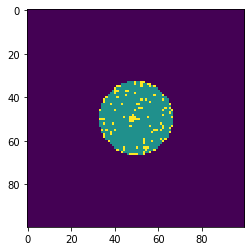

Random


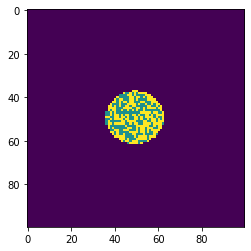

Scratch


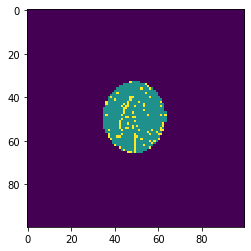

Center


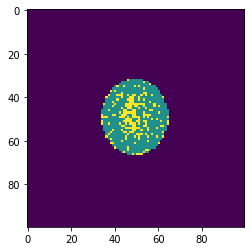

Donut


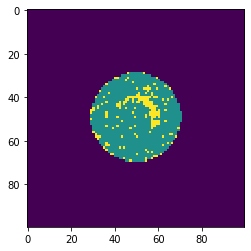

Loc


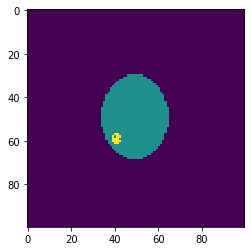

Edge-Ring


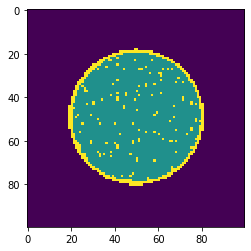

Near-full


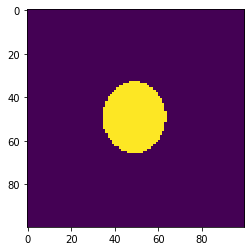

Random


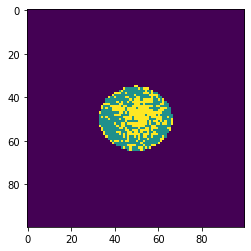

none


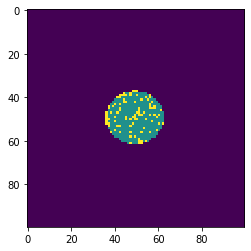

Loc


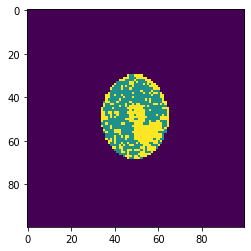

Center


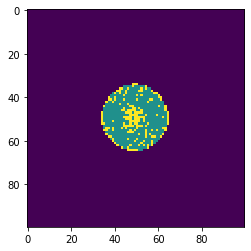

Edge-Loc


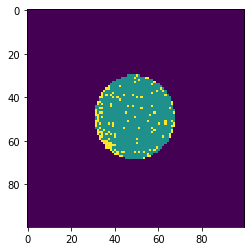

Donut


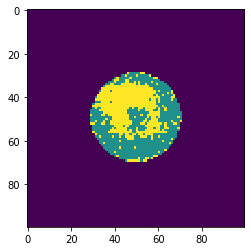

Scratch


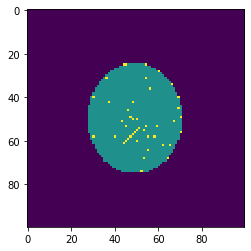

Scratch


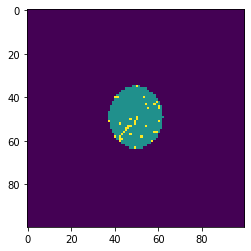

Loc


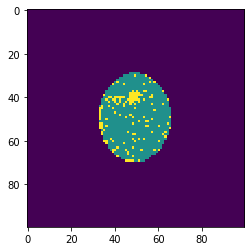

Near-full


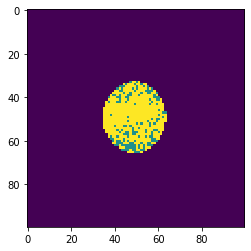

Loc


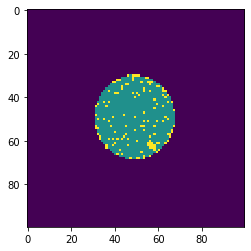

Donut


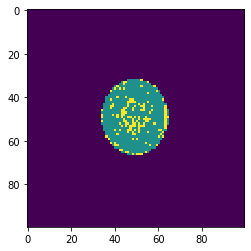

Random


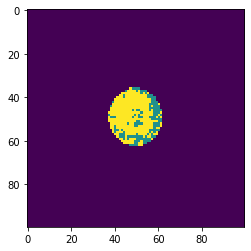

Donut


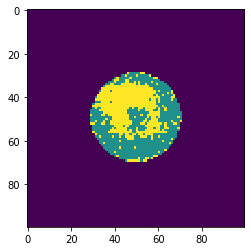

Edge-Ring


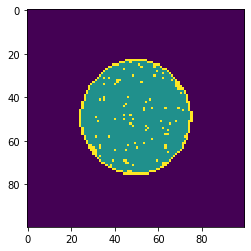

Edge-Loc


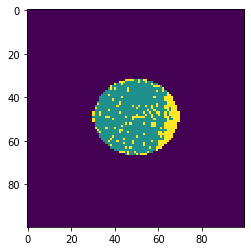

Loc


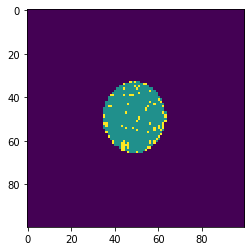

none


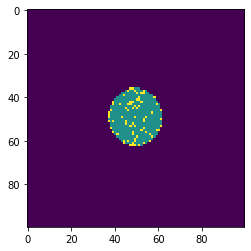

Edge-Ring


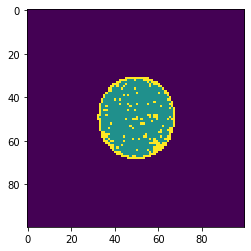

Edge-Ring


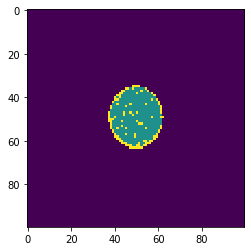

none


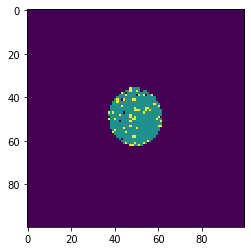

Donut


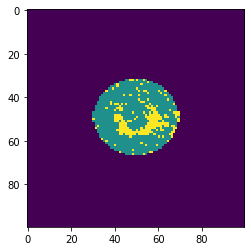

Near-full


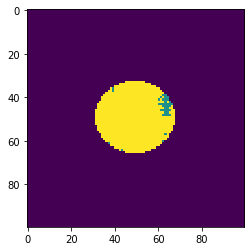

Center


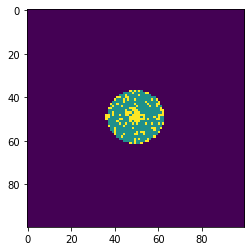

Near-full


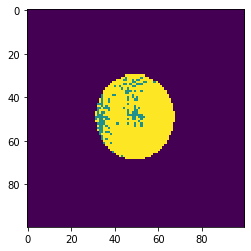

Random


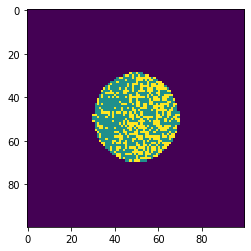

Edge-Ring


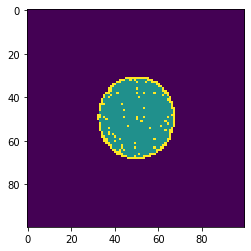

Scratch


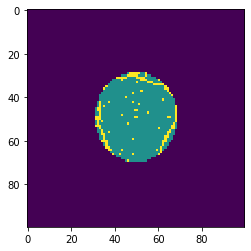

Donut


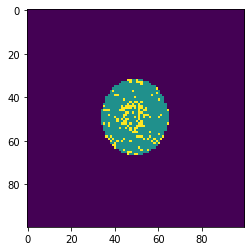

Loc


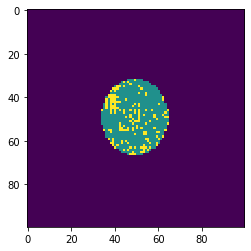

Random


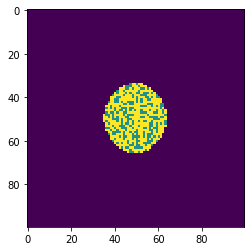

Scratch


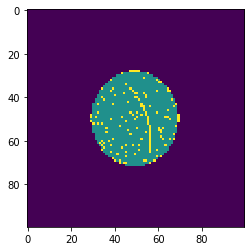

Center


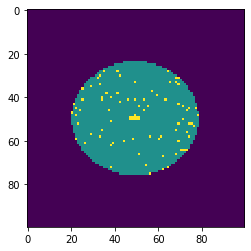

Near-full


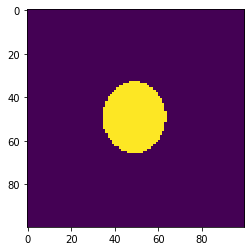

Loc


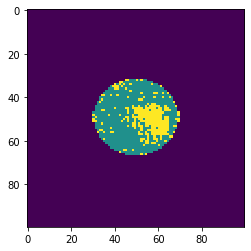

Edge-Ring


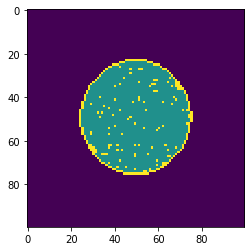

Center


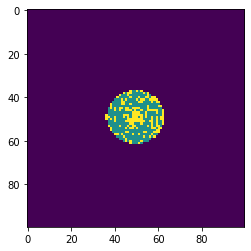

Near-full


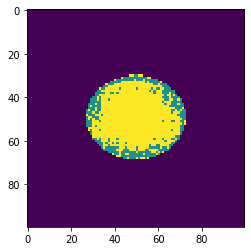

Near-full


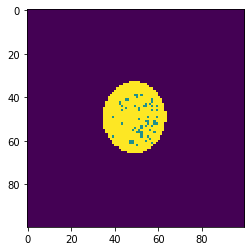

Donut


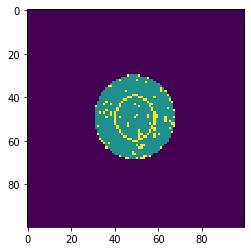

Donut


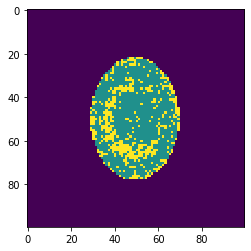

Edge-Loc


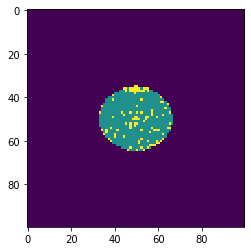

Scratch


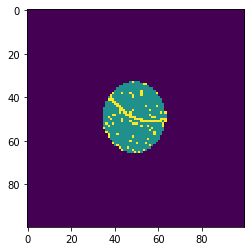

Random


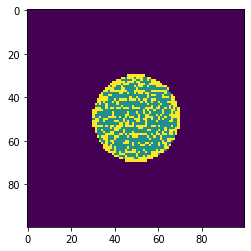

Edge-Loc


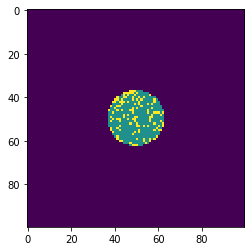

Loc


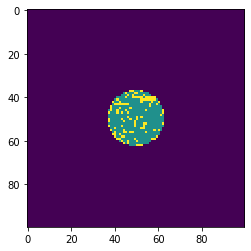

Random


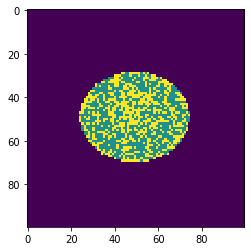

Near-full


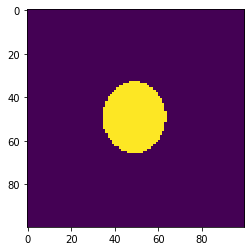

Loc


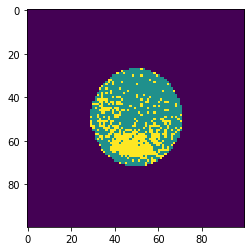

Random


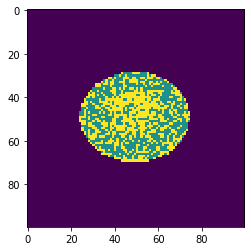

Donut


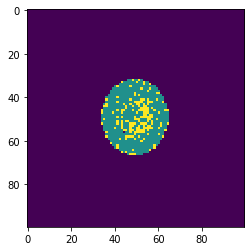

Random


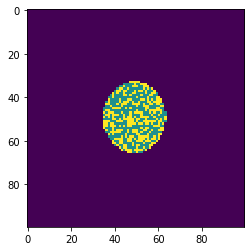

Random


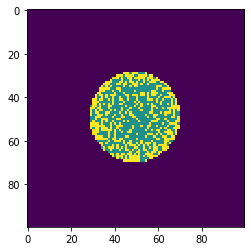

Edge-Ring


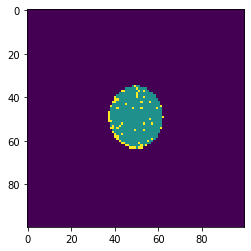

Edge-Ring


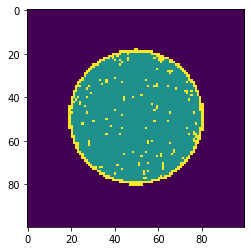

none


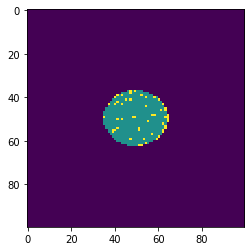

Scratch


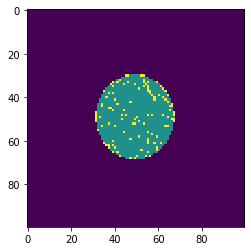

Near-full


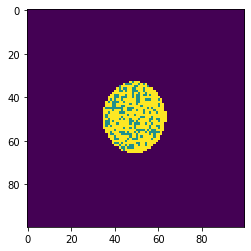

Edge-Ring


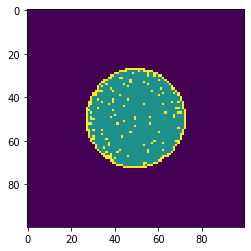

Donut


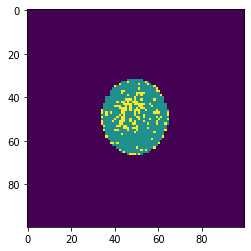

Scratch


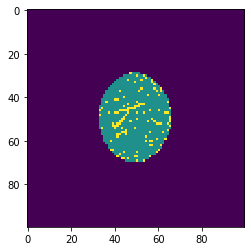

Scratch


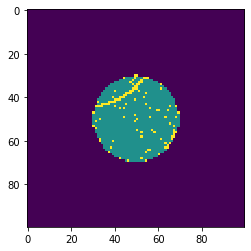

Loc


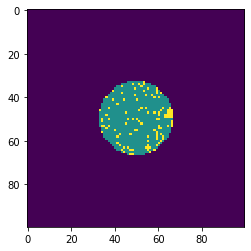

Near-full


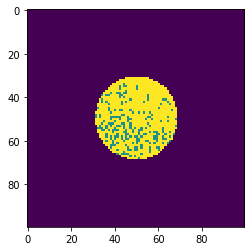

Random


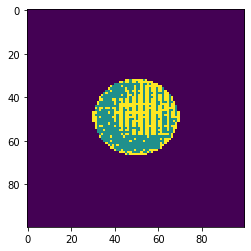

Loc


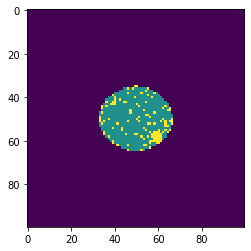

Donut


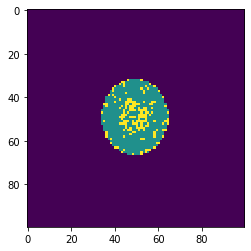

none


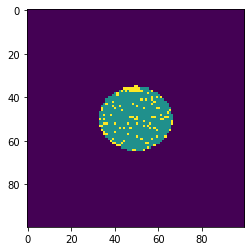

Near-full


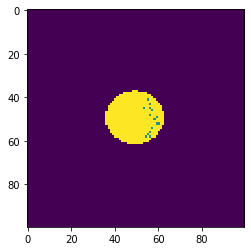

Near-full


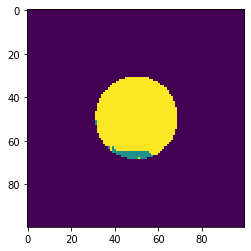

Near-full


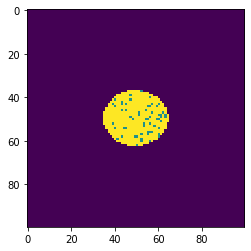

Loc


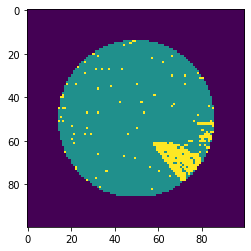

none


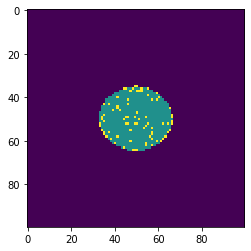

Edge-Loc


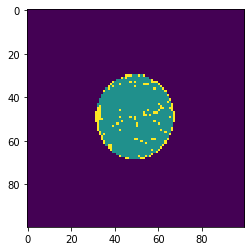

Edge-Ring


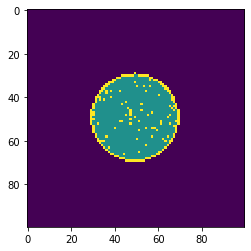

Edge-Ring


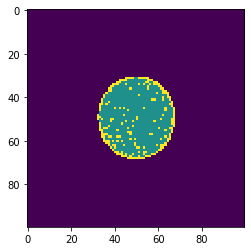

Center


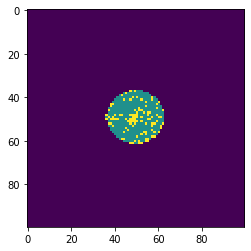

Edge-Loc


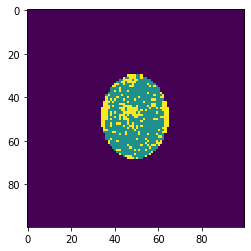

Near-full


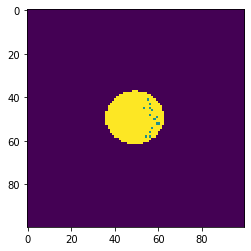

Random


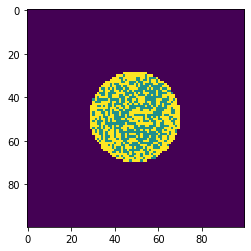

Loc


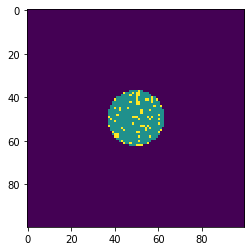

Random


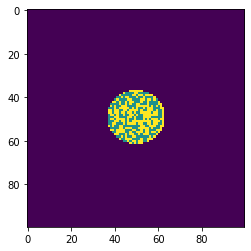

Loc


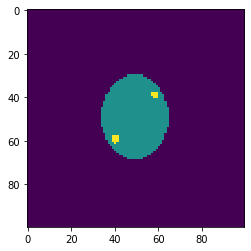

Random


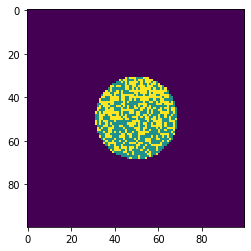

Scratch


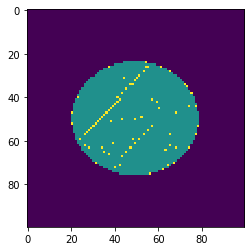

Scratch


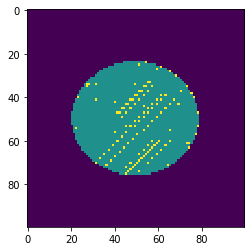

Edge-Ring


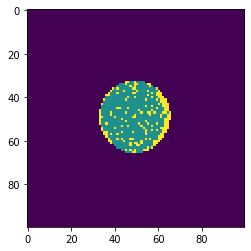

Center


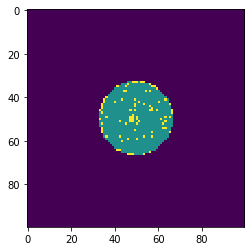

none


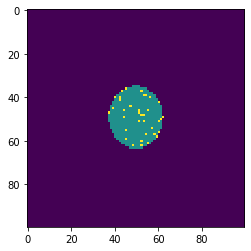

Center


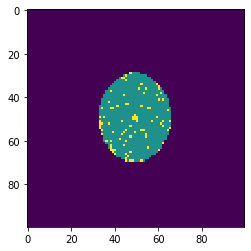

Random


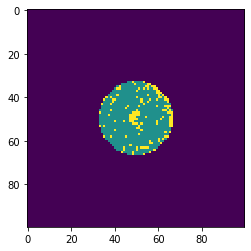

Edge-Ring


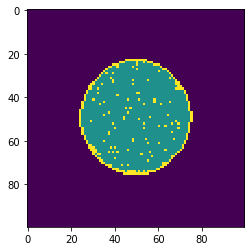

Edge-Ring


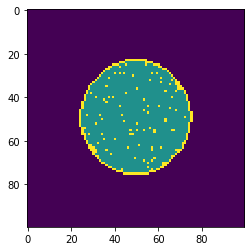

Random


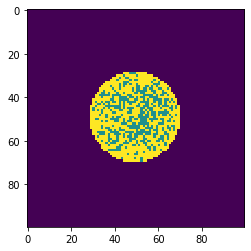

Random


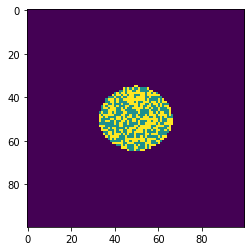

Donut


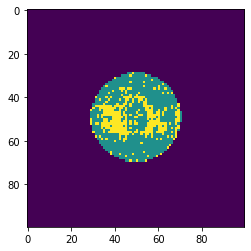

Edge-Ring


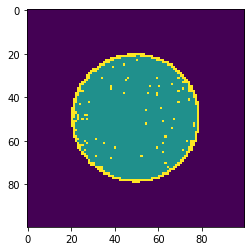

Loc


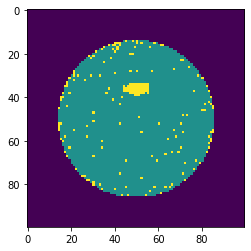

Edge-Loc


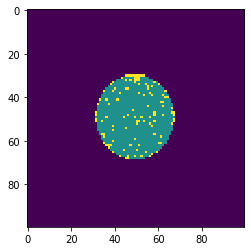

none


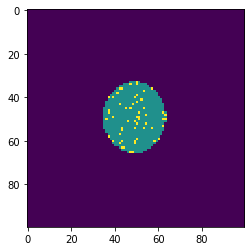

none


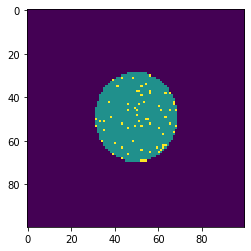

Near-full


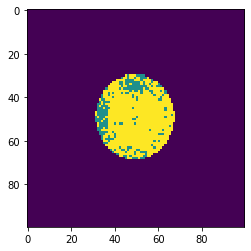

Center


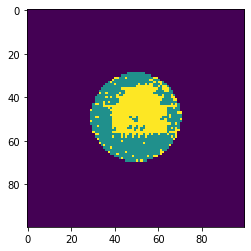

Donut


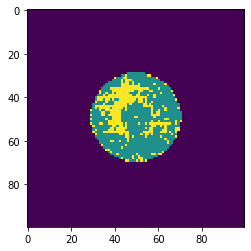

Edge-Ring


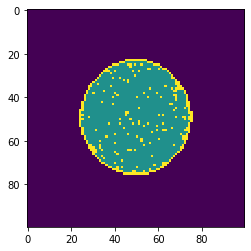

none


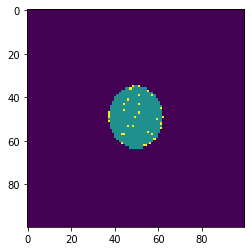

Donut


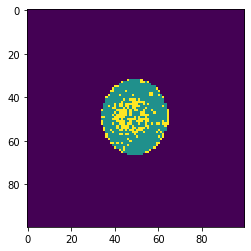

none


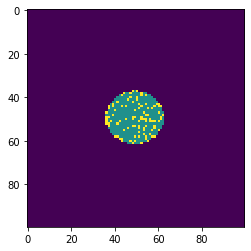

Random


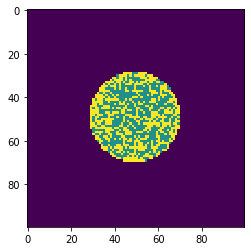

Loc


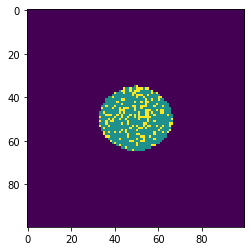

none


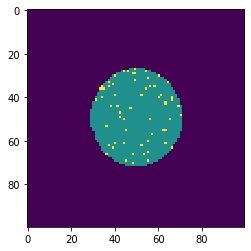

Random


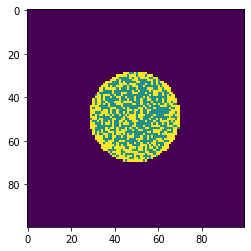

Edge-Ring


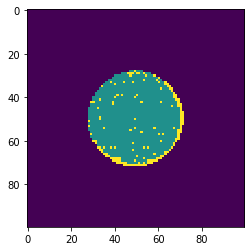

Edge-Ring


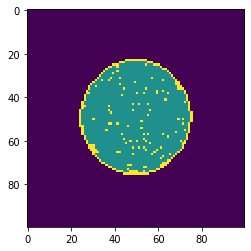

none


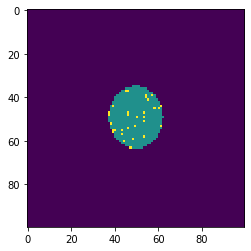

Center


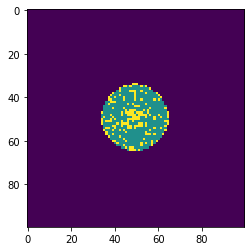

Donut


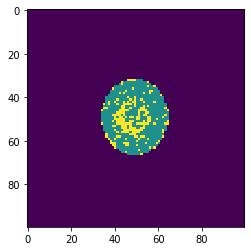

Near-full


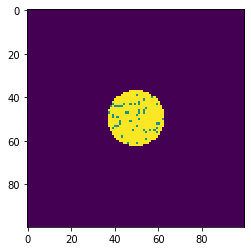

Edge-Ring


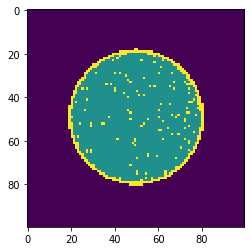

none


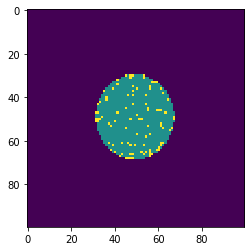

Near-full


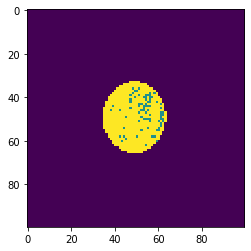

Center


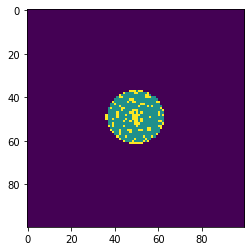

Edge-Loc


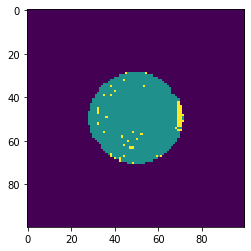

Scratch


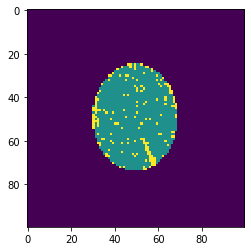

Center


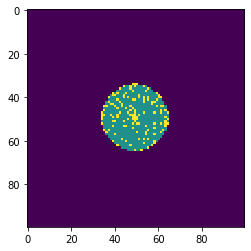

none


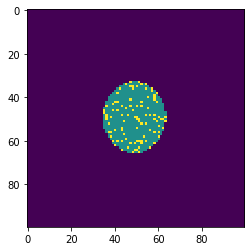

Scratch


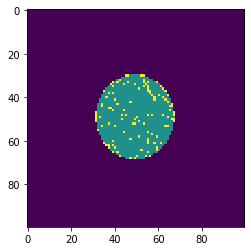

Center


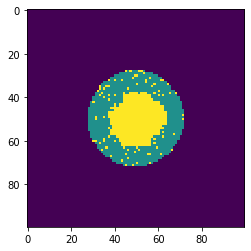

Center


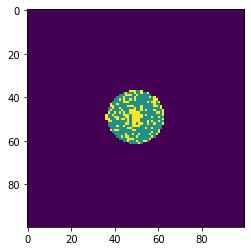

Loc


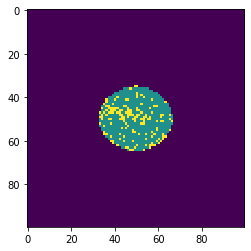

Center


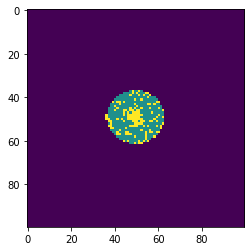

Loc


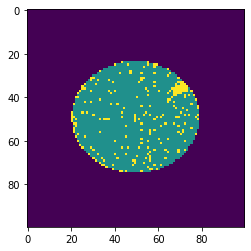

Edge-Loc


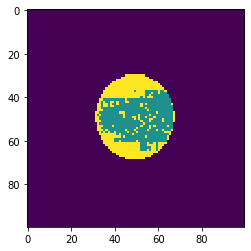

Loc


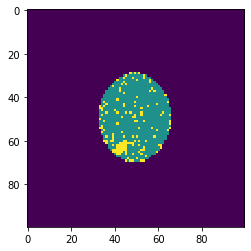

Center


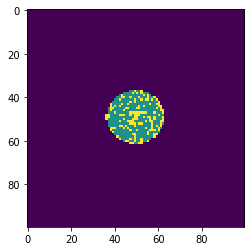

Edge-Loc


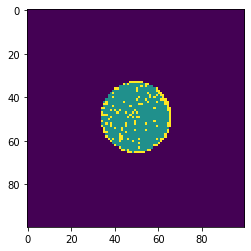

Near-full


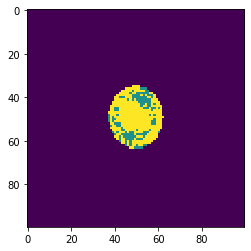

Edge-Loc


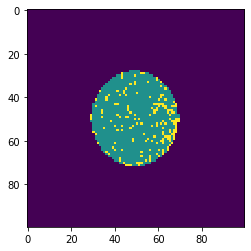

Center


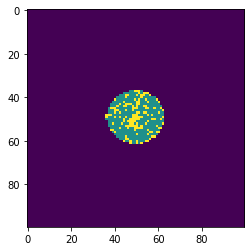

Center


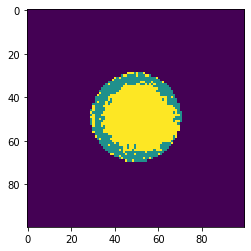

Center


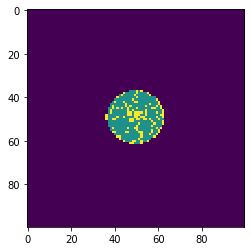

Near-full


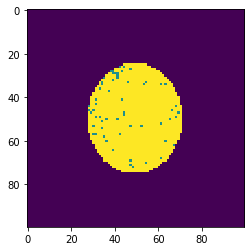

Near-full


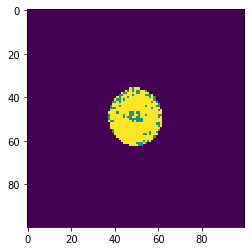

Loc


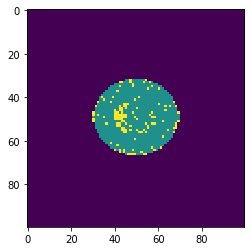

Center


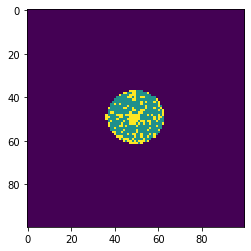

none


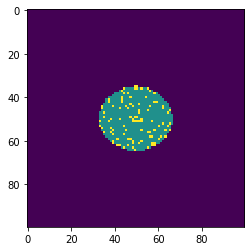

Near-full


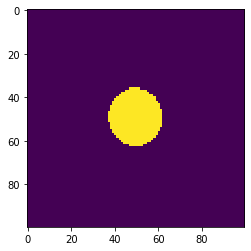

none


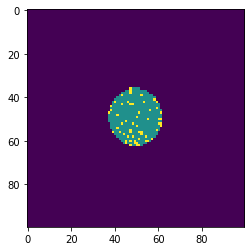

Loc


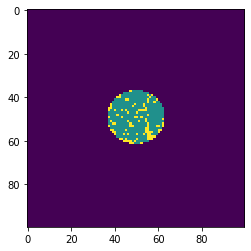

Near-full


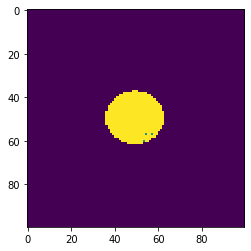

Scratch


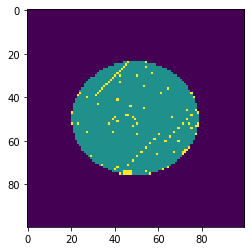

Scratch


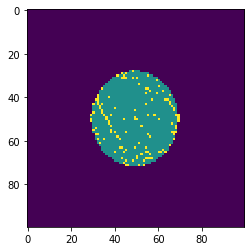

Edge-Ring


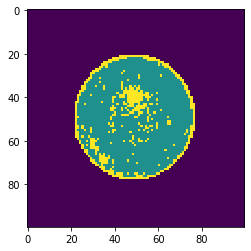

Near-full


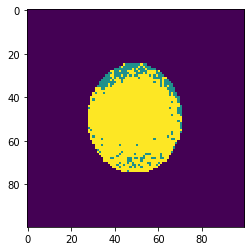

Donut


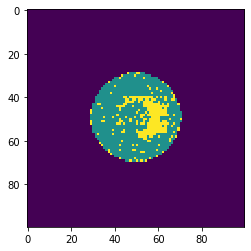

Scratch


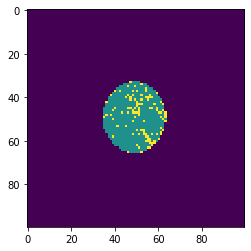

Near-full


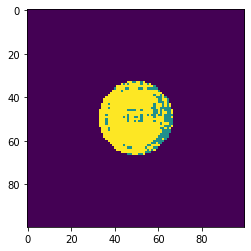

Donut


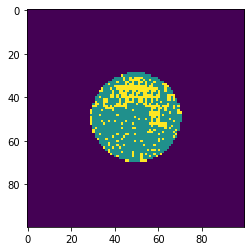

Random


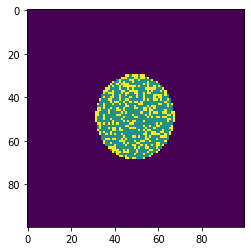

Donut


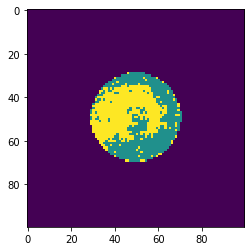

Donut


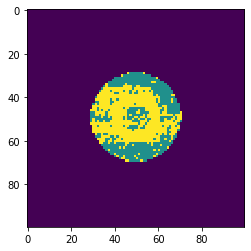

Edge-Ring


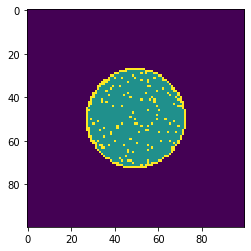

Scratch


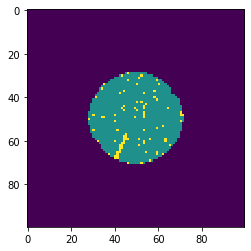

Near-full


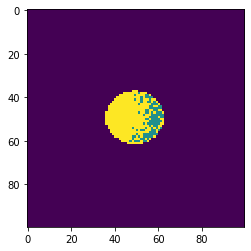

Edge-Ring


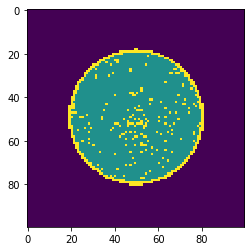

Edge-Loc


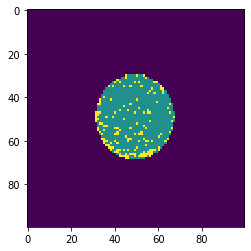

Edge-Ring


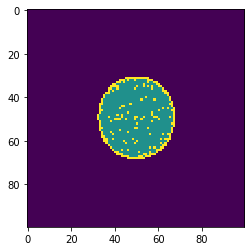

Near-full


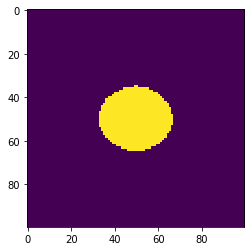

none


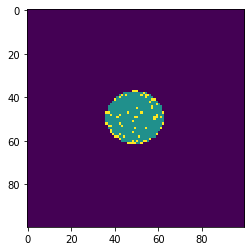

Center


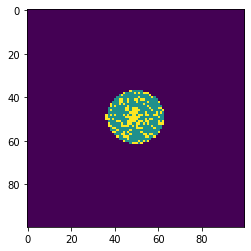

Edge-Ring


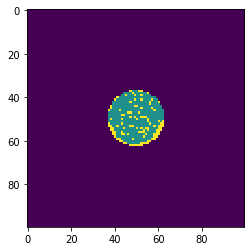

Loc


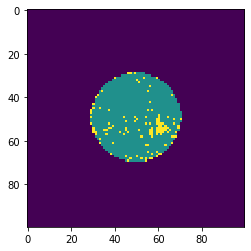

Edge-Ring


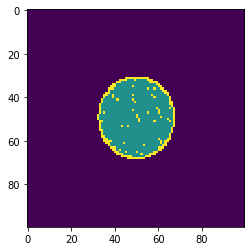

Scratch


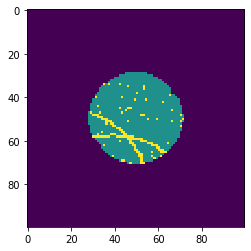

Center


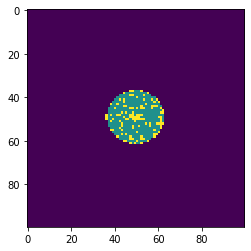

Random


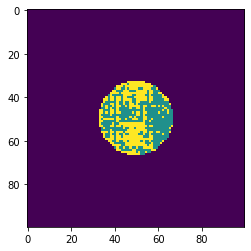

Edge-Ring


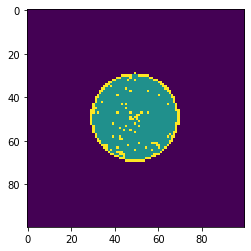

Loc


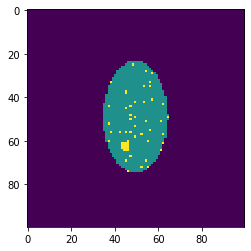

none


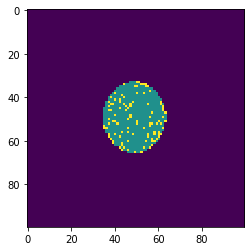

Donut


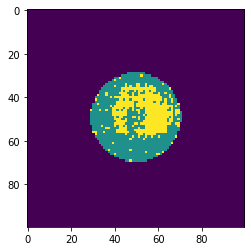

Edge-Ring


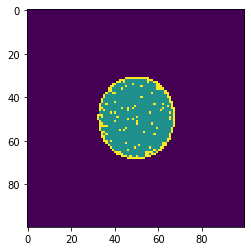

Center


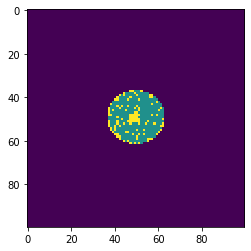

Loc


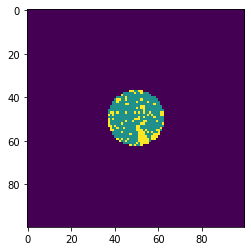

none


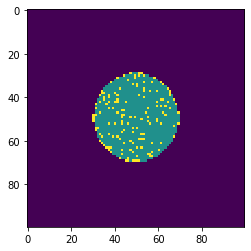

Random


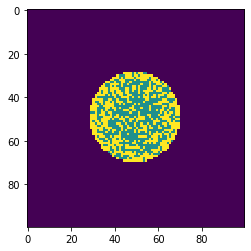

Edge-Loc


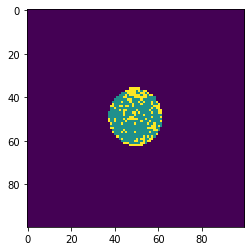

Center


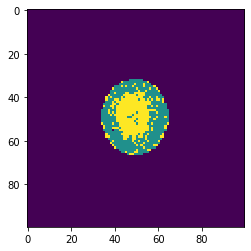

Edge-Loc


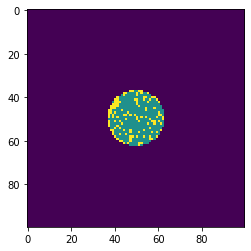

Center


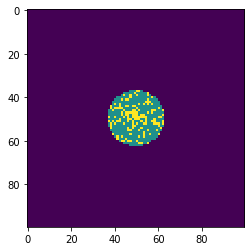

Near-full


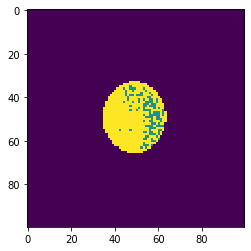

Edge-Ring


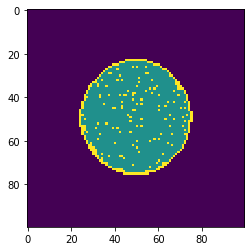

none


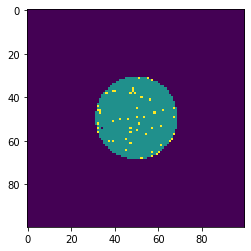

none


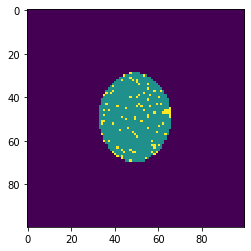

none


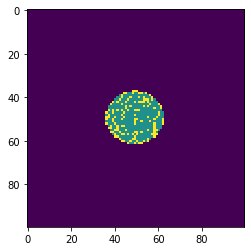

Edge-Ring


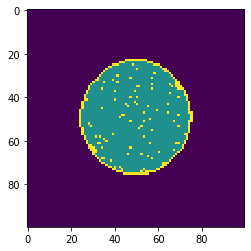

Random


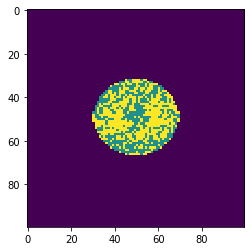

Edge-Ring


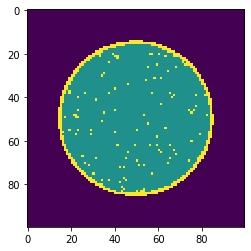

Loc


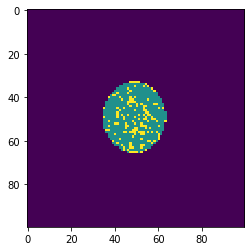

Random


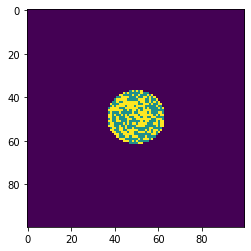

Edge-Loc


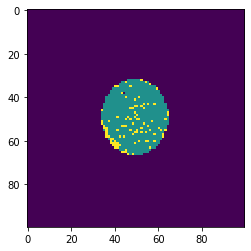

Random


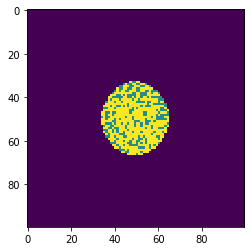

Donut


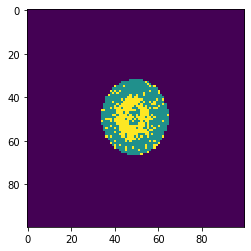

Center


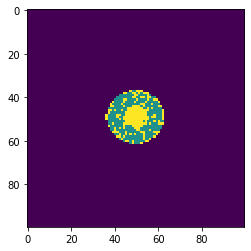

Scratch


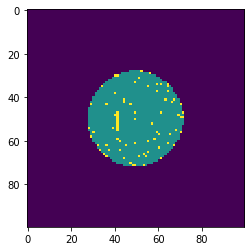

Edge-Loc


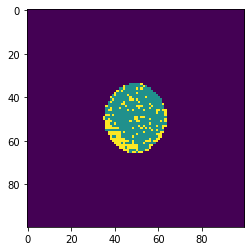

Random


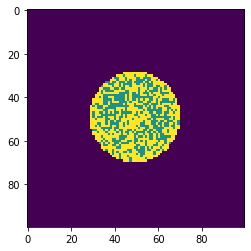

Loc


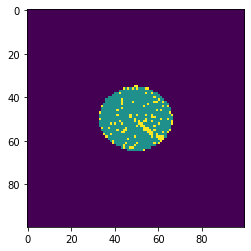

none


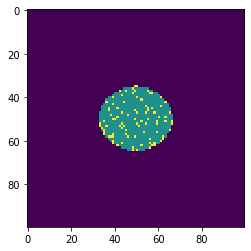

Edge-Ring


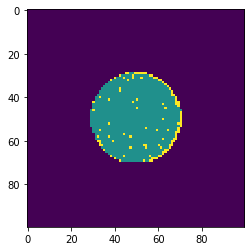

Near-full


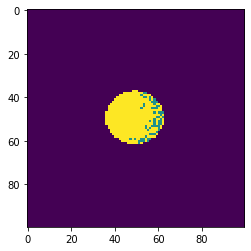

Scratch


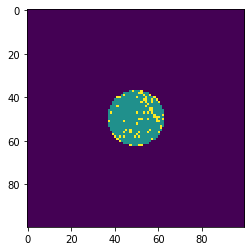

Donut


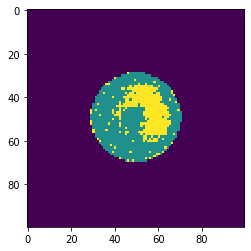

Center


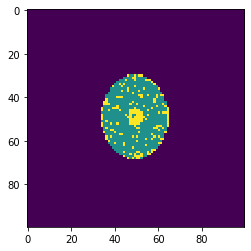

none


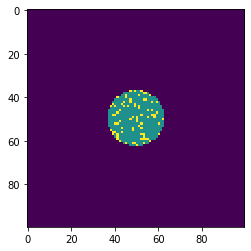

none


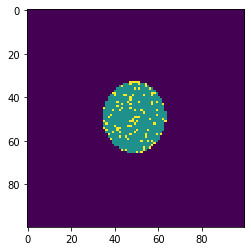

Near-full


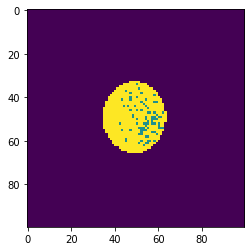

Near-full


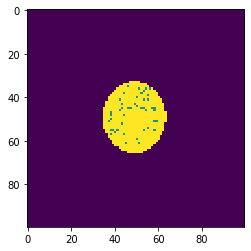

Edge-Ring


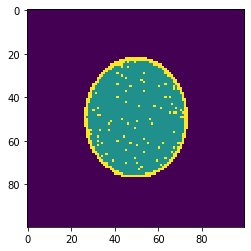

Scratch


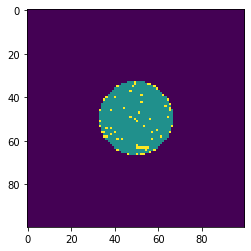

Random


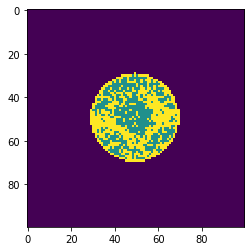

Scratch


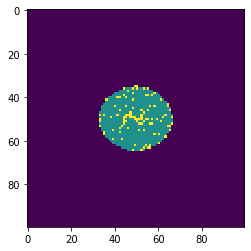

none


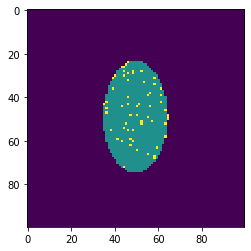

none


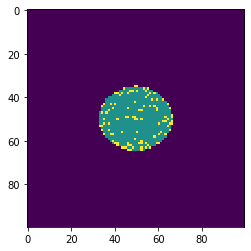

Donut


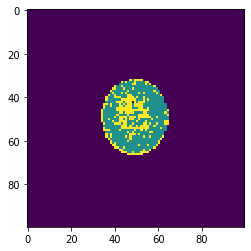

Edge-Ring


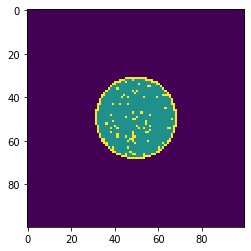

Random


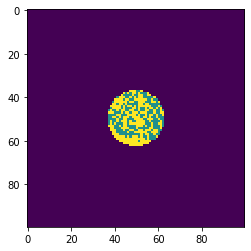

none


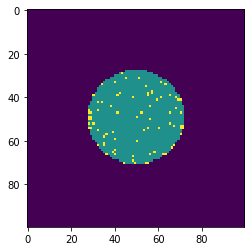

Edge-Loc


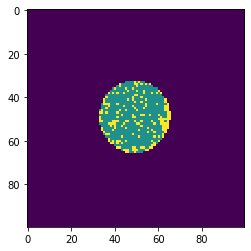

none


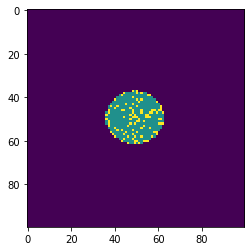

Donut


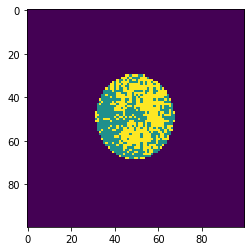

none


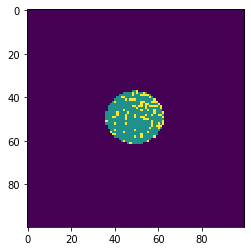

Edge-Ring


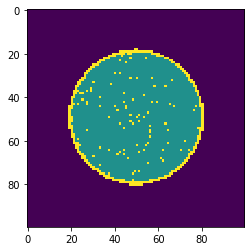

Random


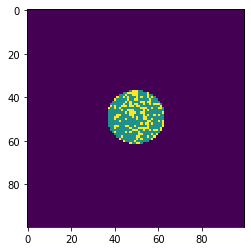

Donut


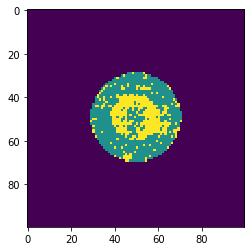

Scratch


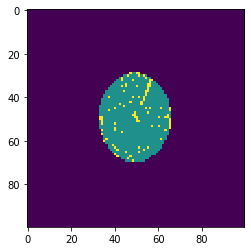

Center


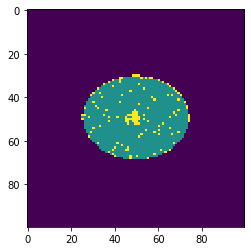

Center


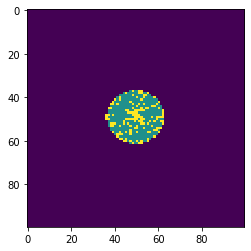

Scratch


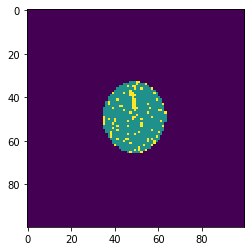

Center


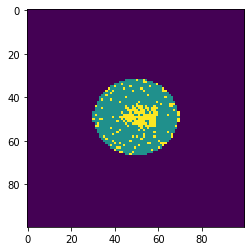

Center


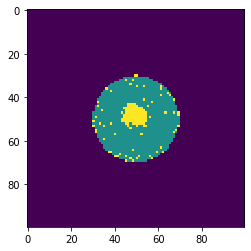

Random


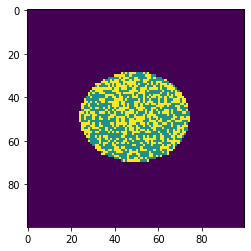

Near-full


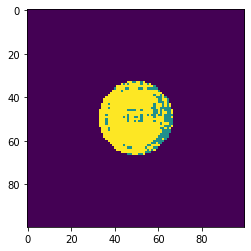

Center


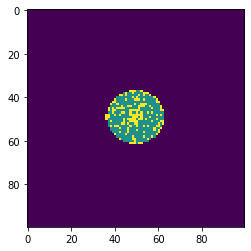

Donut


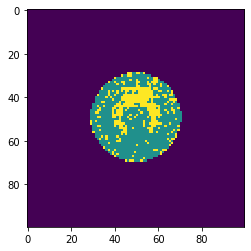

Scratch


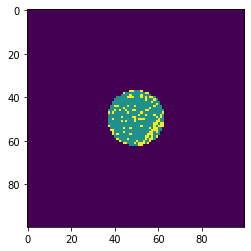

Edge-Loc


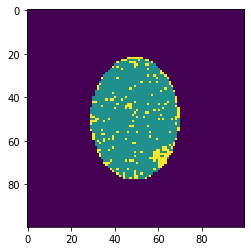

Scratch


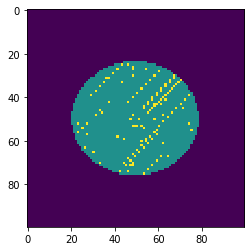

Loc


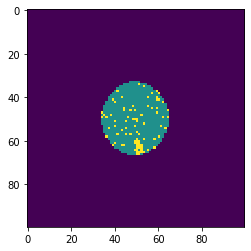

Loc


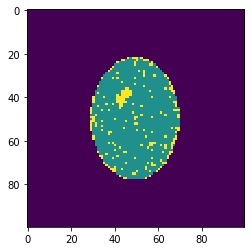

Edge-Ring


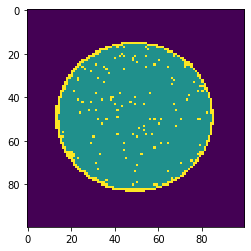

Edge-Ring


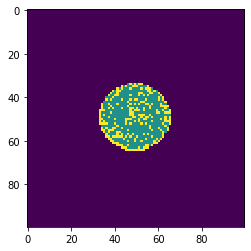

none


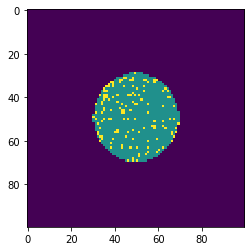

Near-full


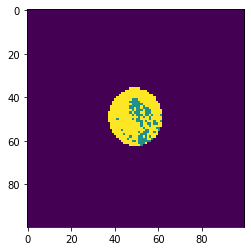

Scratch


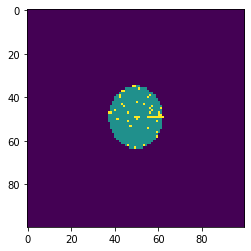

Random


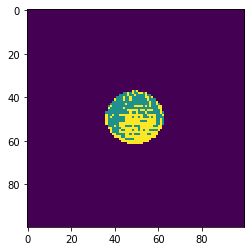

Center


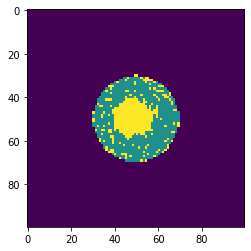

Random


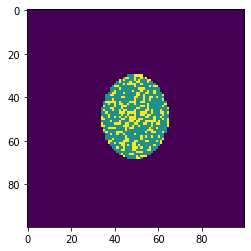

Random


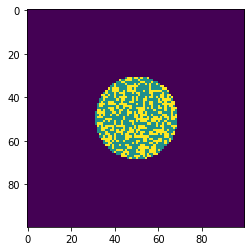

Near-full


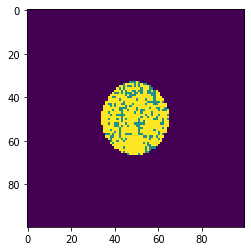

Loc


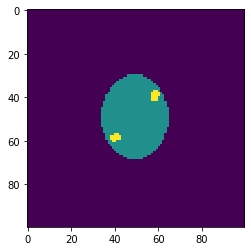

Scratch


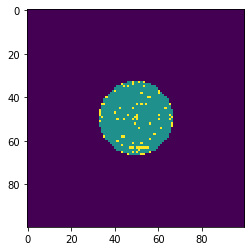

Edge-Loc


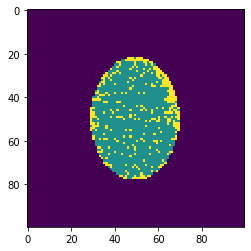

Center


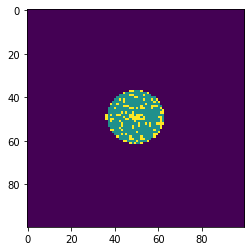

none


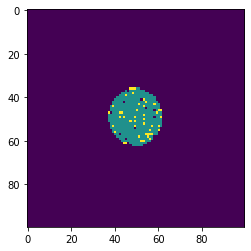

Random


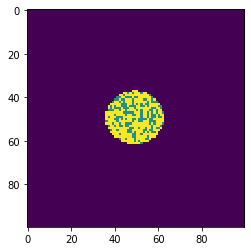

none


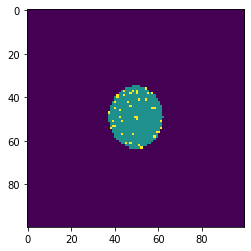

Donut


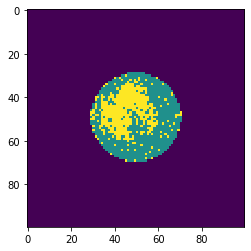

Edge-Ring


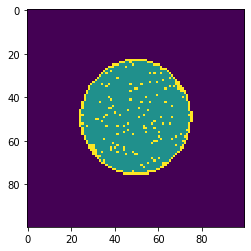

Near-full


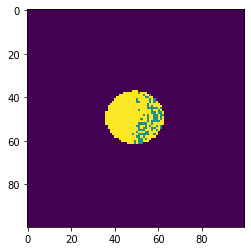

Scratch


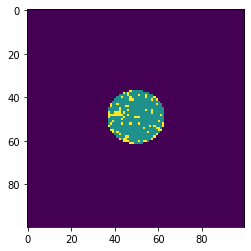

Edge-Ring


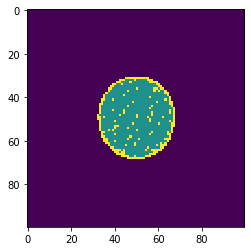

Loc


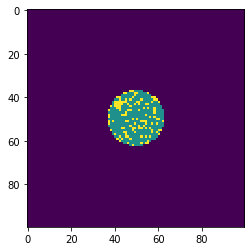

Edge-Ring


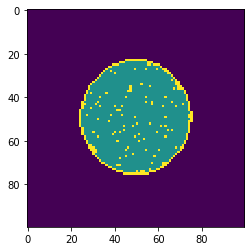

Random


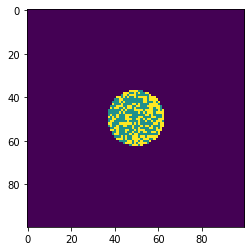

Edge-Ring


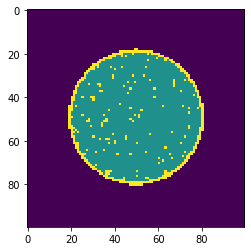

Edge-Ring


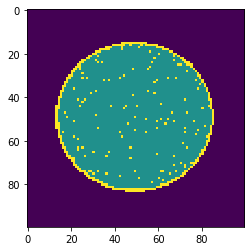

Donut


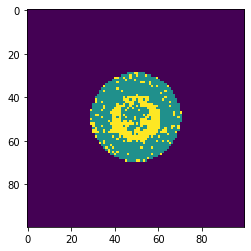

Center


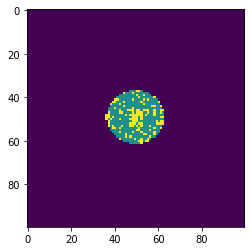

Edge-Loc


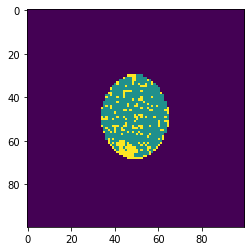

Near-full


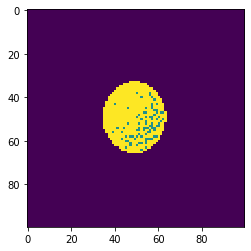

Center


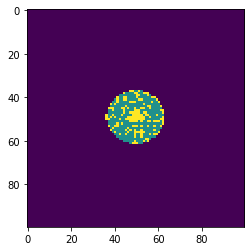

Center


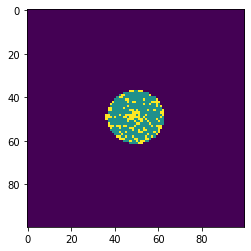

Center


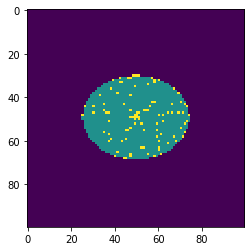

none


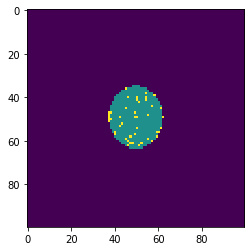

Center


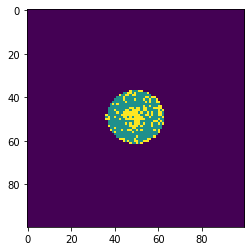

Random


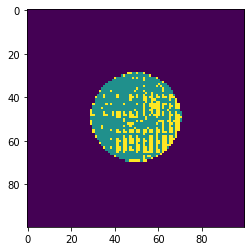

none


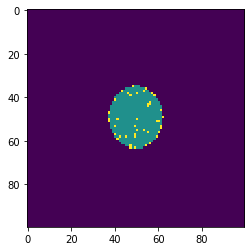

Edge-Loc


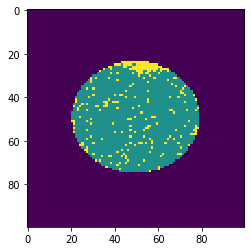

Edge-Loc


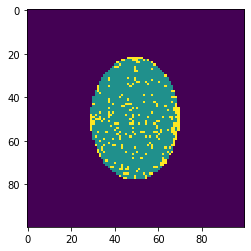

Near-full


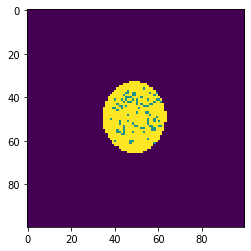

Edge-Ring


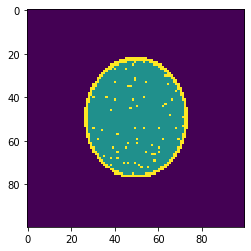

none


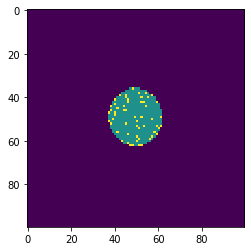

none


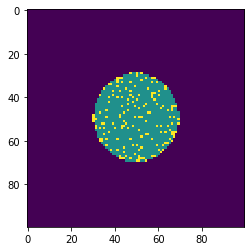

Near-full


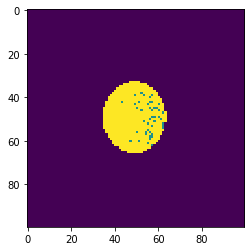

Scratch


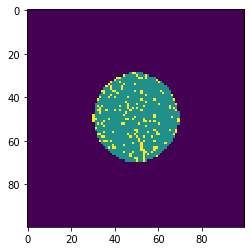

none


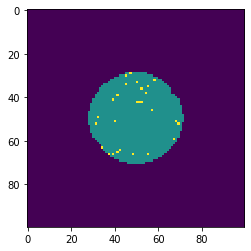

Scratch


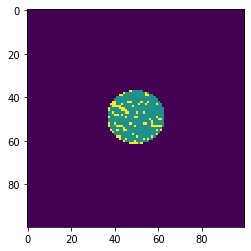

Center


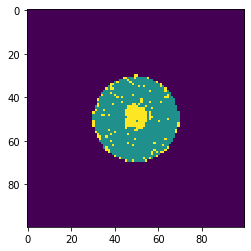

Edge-Ring


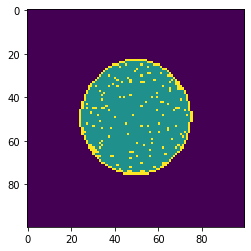

none


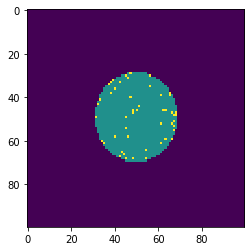

Center


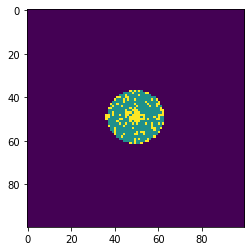

Edge-Ring


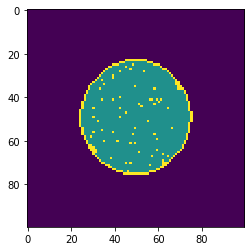

Near-full


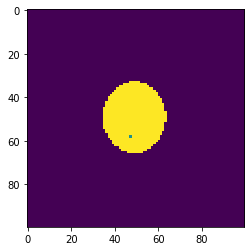

Random


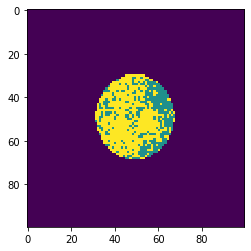

Center


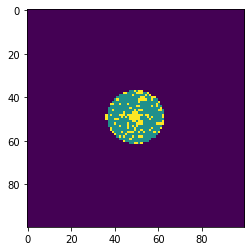

Loc


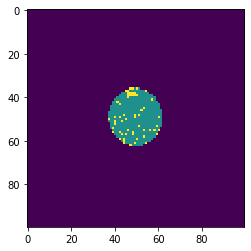

Random


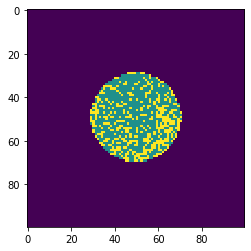

Edge-Loc


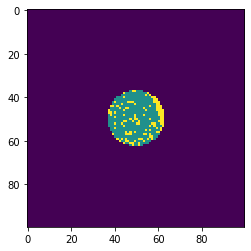

Edge-Loc


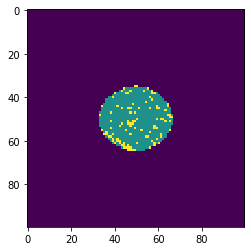

Center


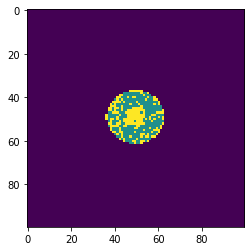

none


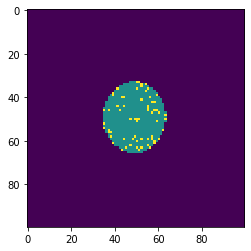

Near-full


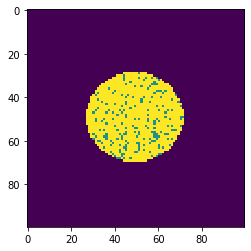

Center


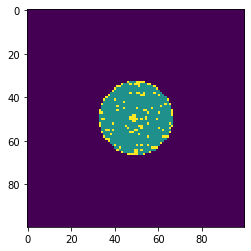

Edge-Loc


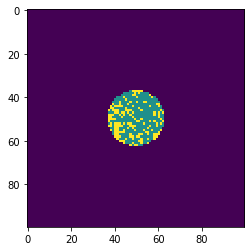

Edge-Ring


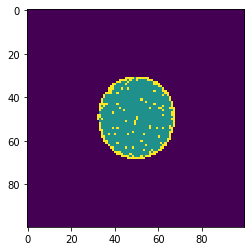

Donut


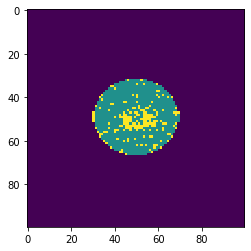

none


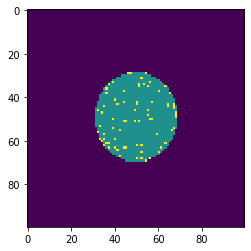

Center


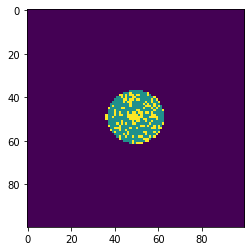

Scratch


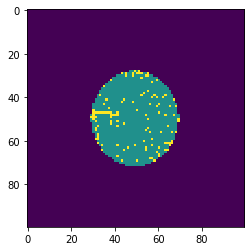

Edge-Ring


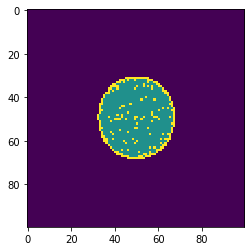

none


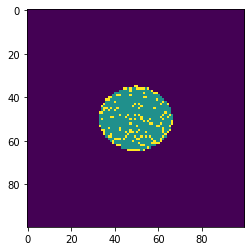

Near-full


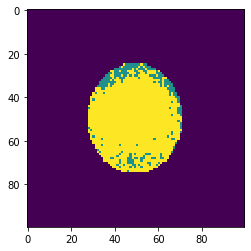

Edge-Ring


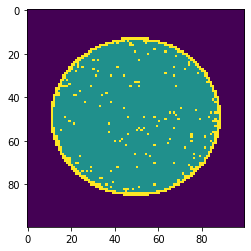

Edge-Ring


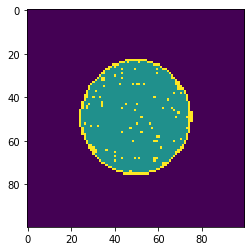

Scratch


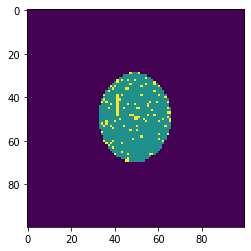

none


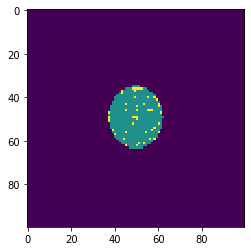

Near-full


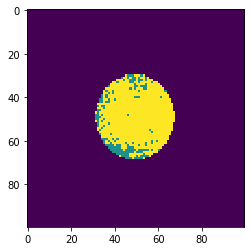

Scratch


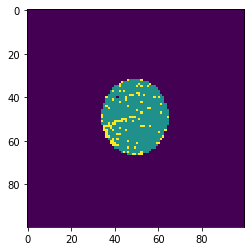

Donut


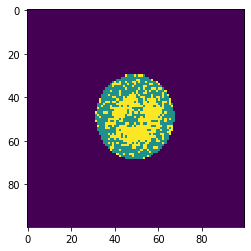

Donut


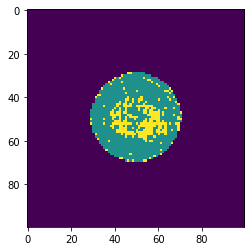

Scratch


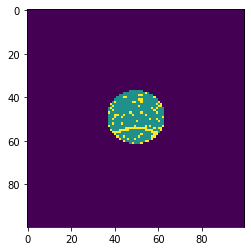

Edge-Loc


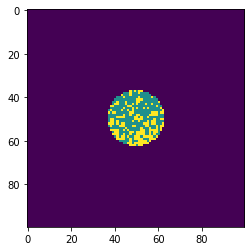

Loc


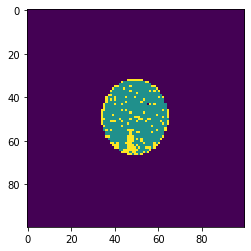

Edge-Loc


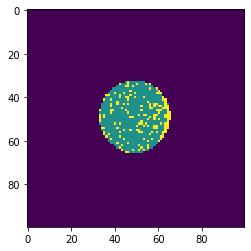

Loc


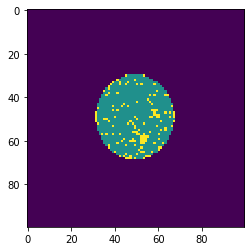

Near-full


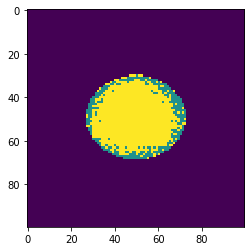

Near-full


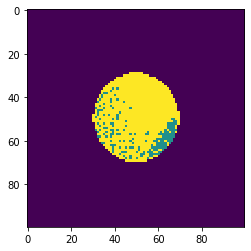

Loc


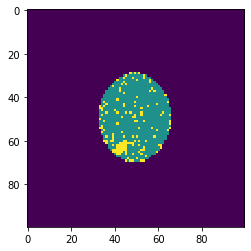

Loc


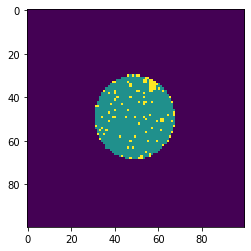

Near-full


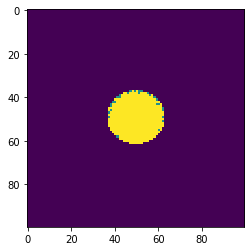

Center


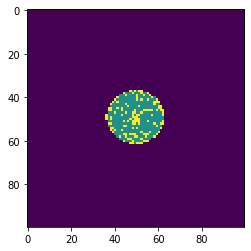

Edge-Ring


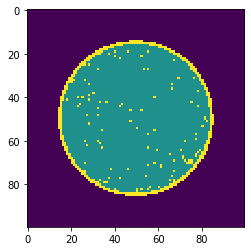

Edge-Ring


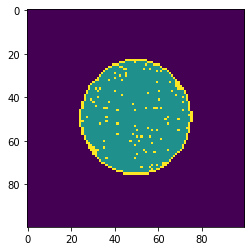

none


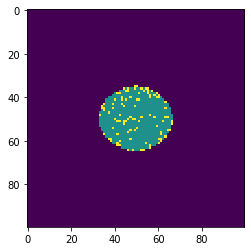

Near-full


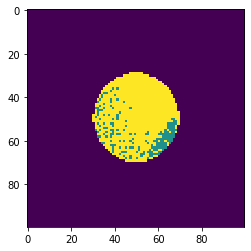

Edge-Loc


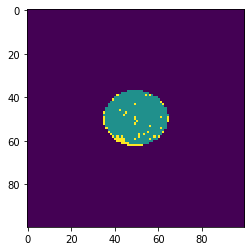

Edge-Ring


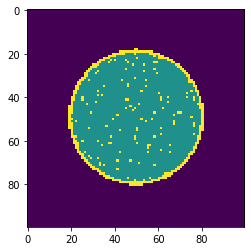

Edge-Loc


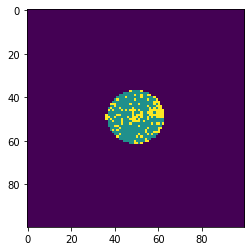

none


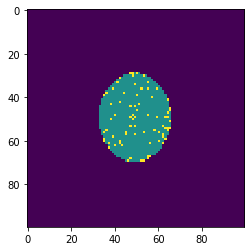

Donut


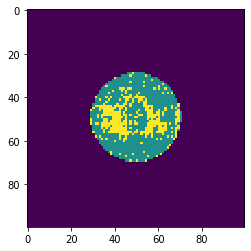

Loc


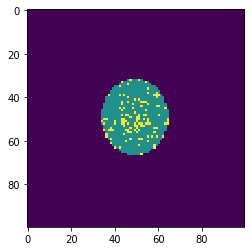

Near-full


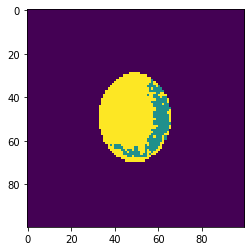

Near-full


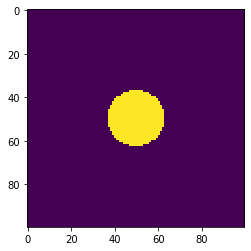

Edge-Loc


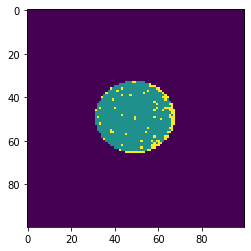

Edge-Loc


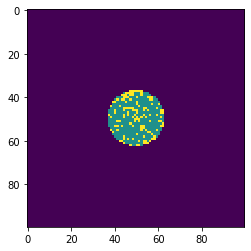

none


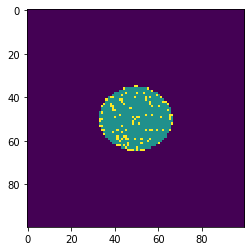

none


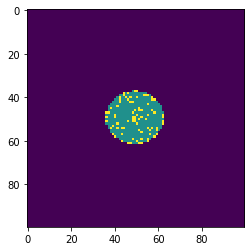

Edge-Ring


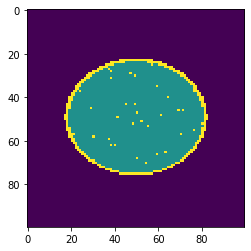

Edge-Ring


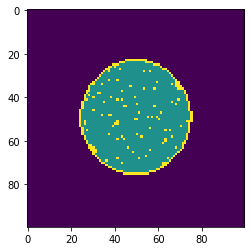

none


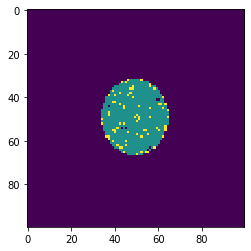

Loc


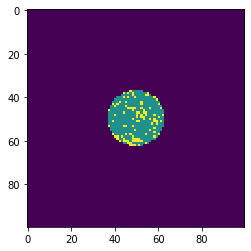

Near-full


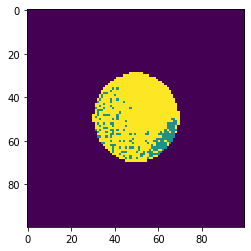

Edge-Loc


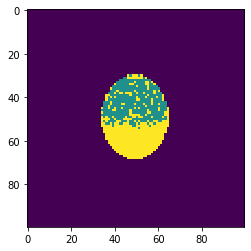

Edge-Ring


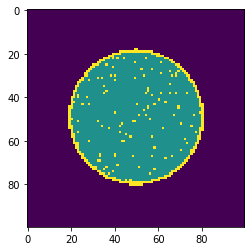

Donut


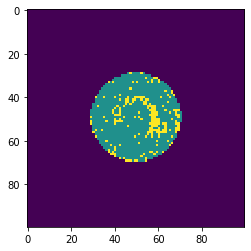

Center


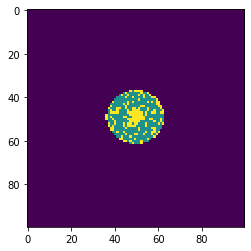

Loc


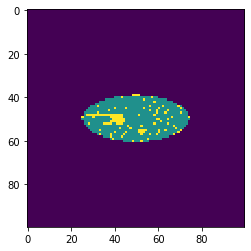

none


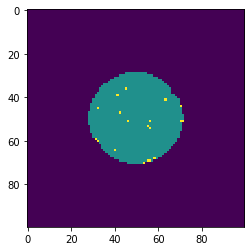

Center


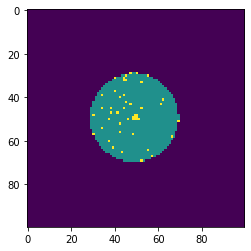

Scratch


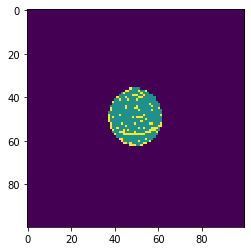

Center


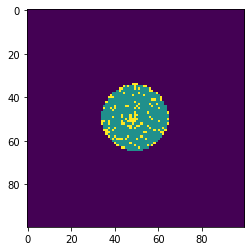

Donut


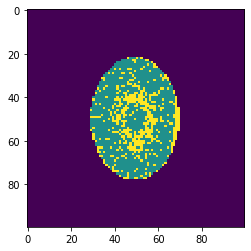

Center


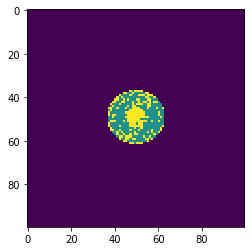

Center


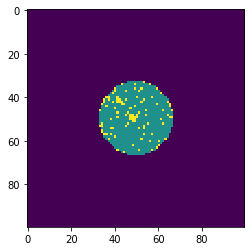

Center


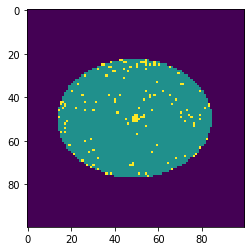

Donut


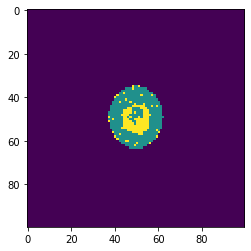

none


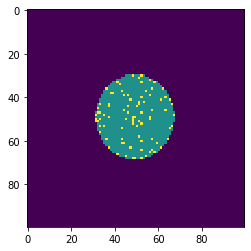

Scratch


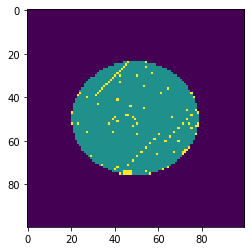

Loc


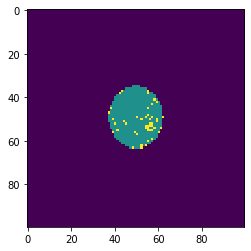

Random


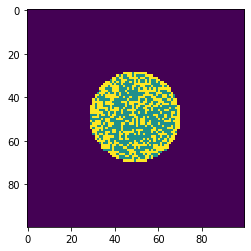

Random


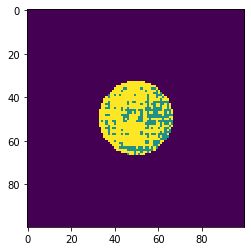

Center


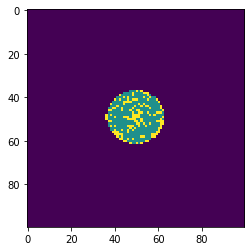

Edge-Ring


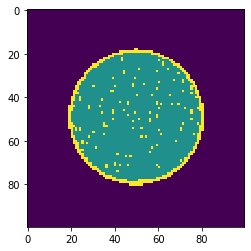

Random


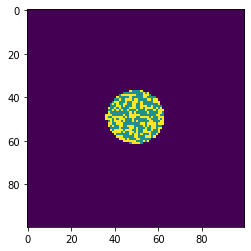

Donut


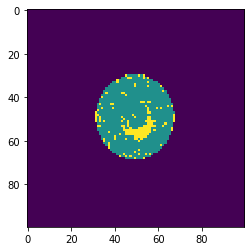

Random


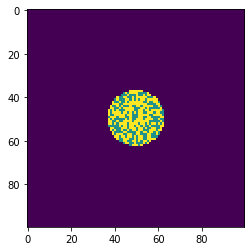

Center


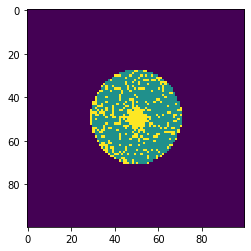

Scratch


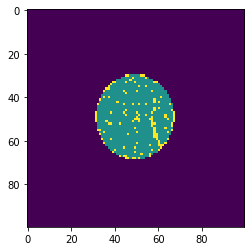

Random


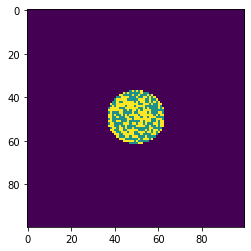

none


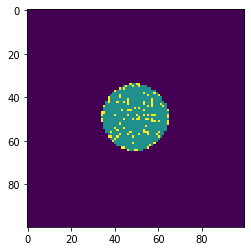

Edge-Ring


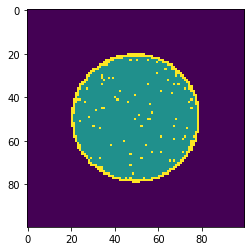

Loc


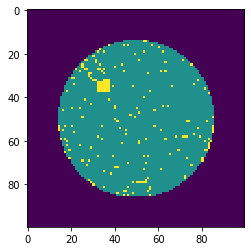

Random


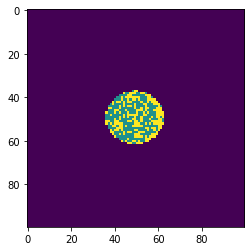

Scratch


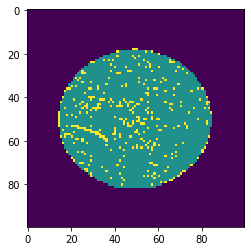

Donut


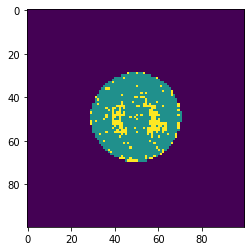

Edge-Ring


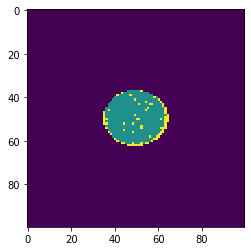

Near-full


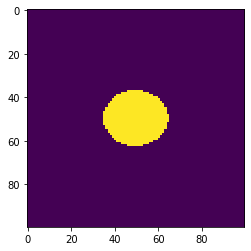

Edge-Loc


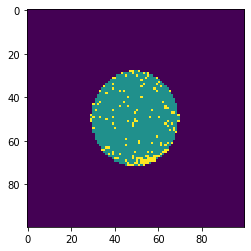

Loc


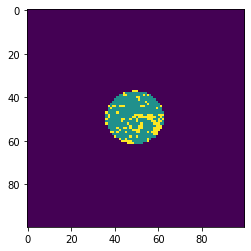

Edge-Loc


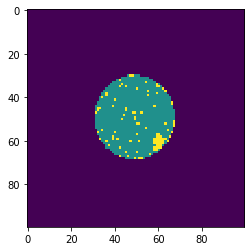

Edge-Ring


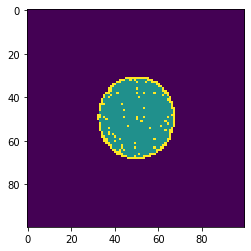

Scratch


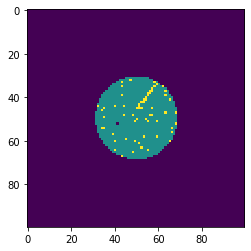

Donut


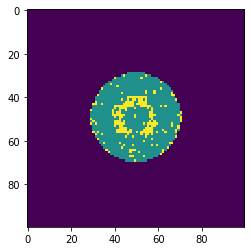

Random


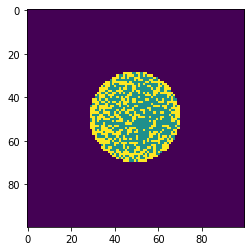

Donut


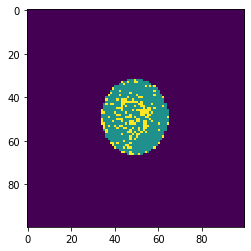

Near-full


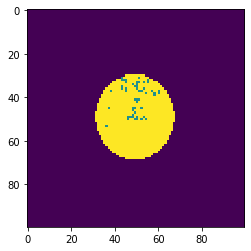

Loc


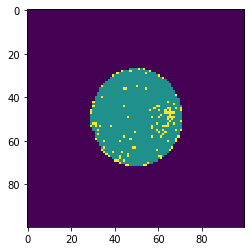

Random


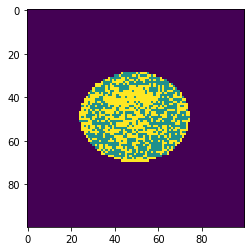

Scratch


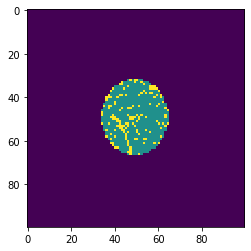

Edge-Loc


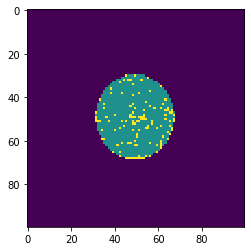

Edge-Ring


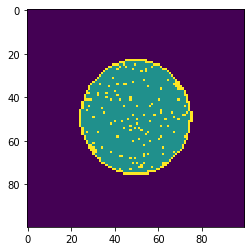

Scratch


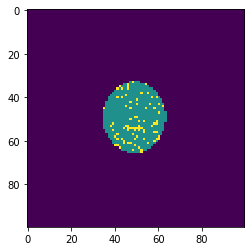

Scratch


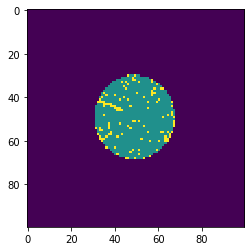

Random


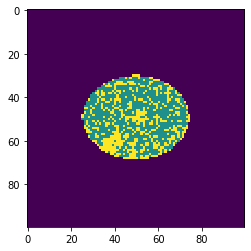

Edge-Loc


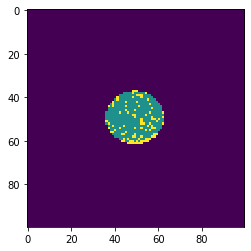

Loc


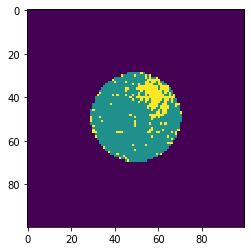

Edge-Ring


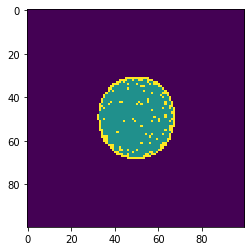

Center


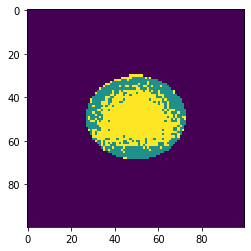

Donut


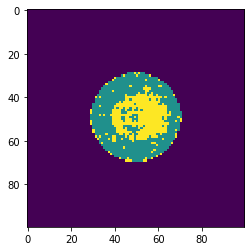

Center


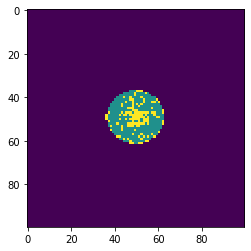

Edge-Ring


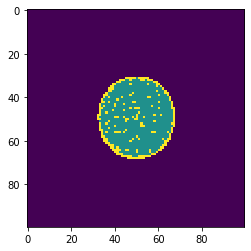

Donut


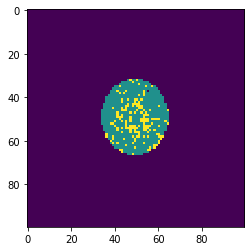

Random


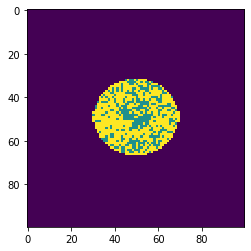

Random


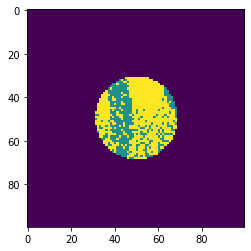

none


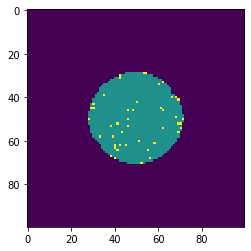

Edge-Loc


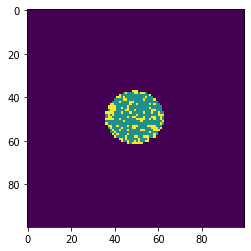

Random


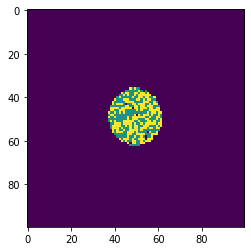

Edge-Ring


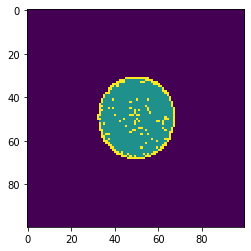

Near-full


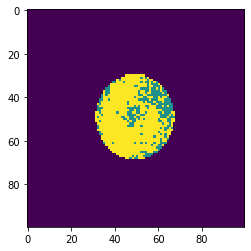

Near-full


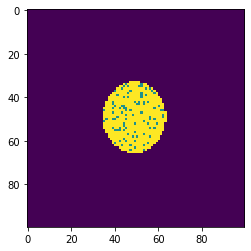

Scratch


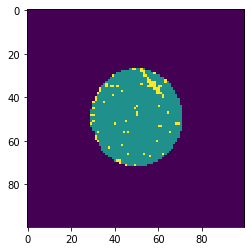

Scratch


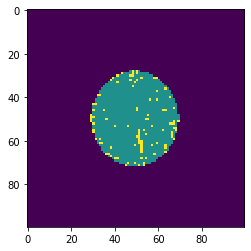

Random


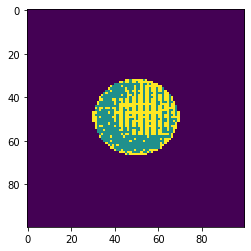

Donut


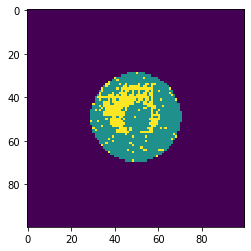

Loc


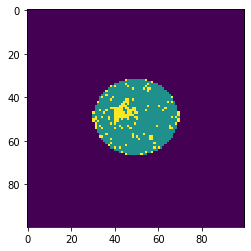

Center


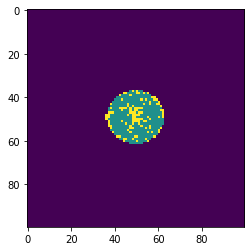

Center


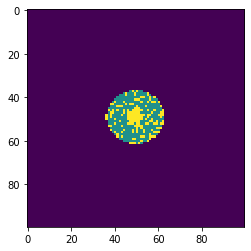

Scratch


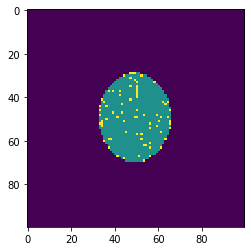

Edge-Ring


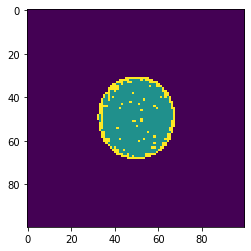

Donut


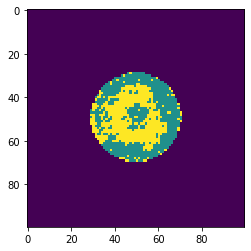

Center


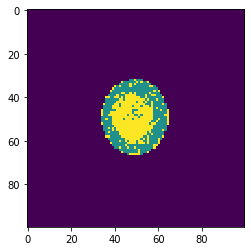

Edge-Ring


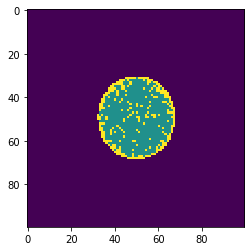

Scratch


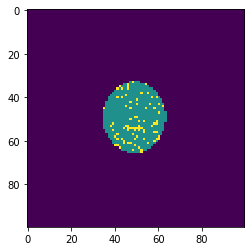

Loc


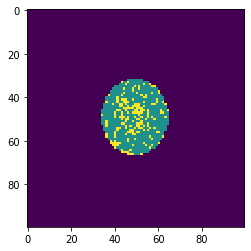

Near-full


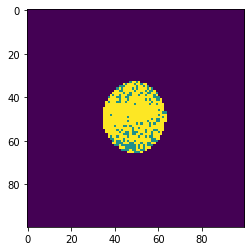

Edge-Ring


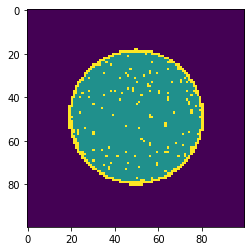

none


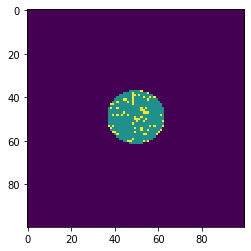

Edge-Loc


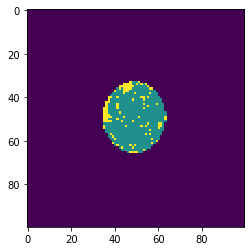

Edge-Loc


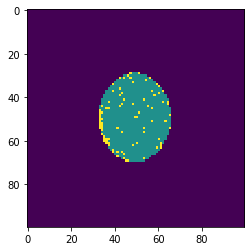

Edge-Loc


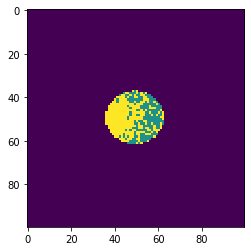

none


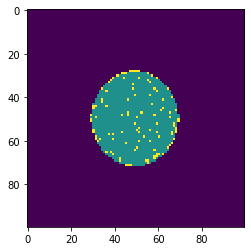

Edge-Loc


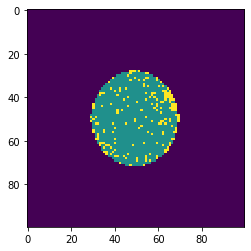

Loc


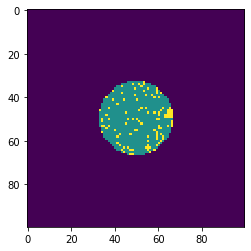

Near-full


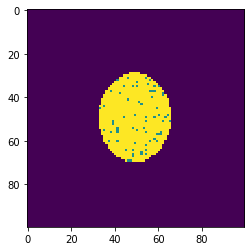

Center


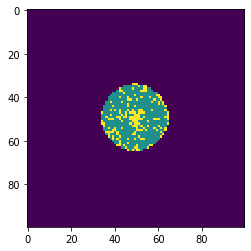

Center


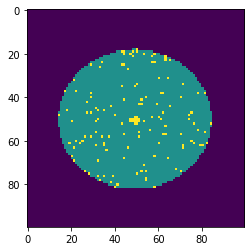

Loc


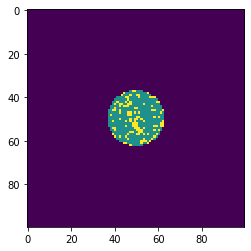

Scratch


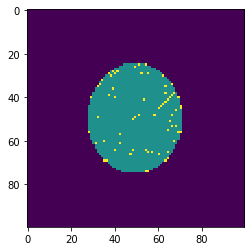

Random


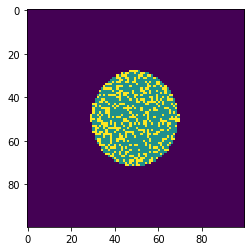

Near-full


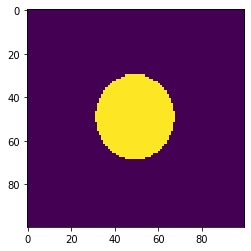

Center


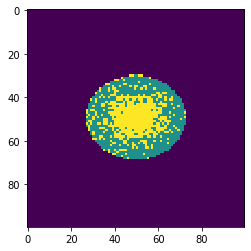

none


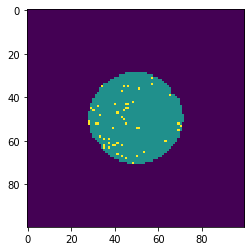

Center


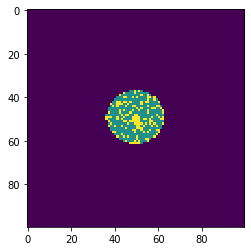

Edge-Ring


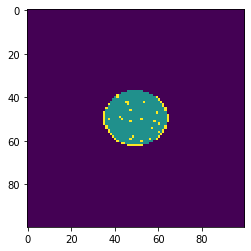

Scratch


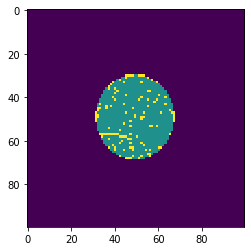

Edge-Ring


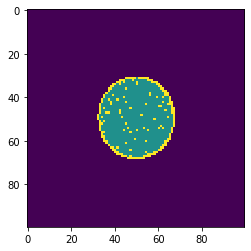

Scratch


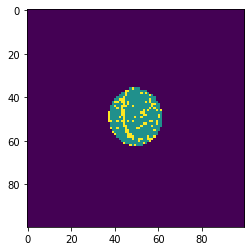

Edge-Ring


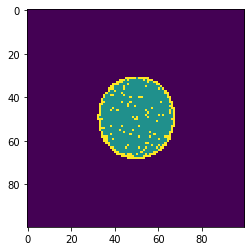

Center


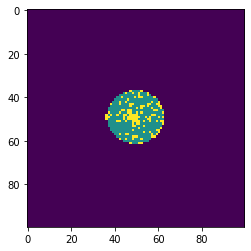

Donut


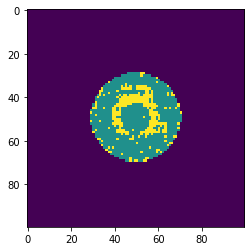

Loc


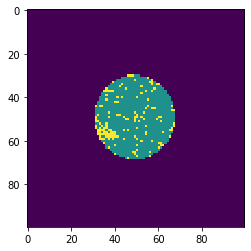

Edge-Ring


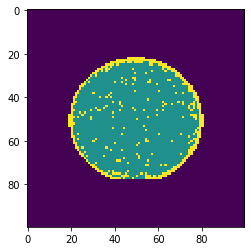

Center


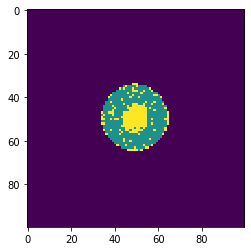

Random


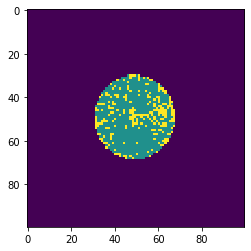

Near-full


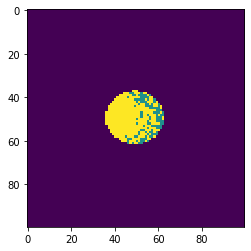

Edge-Ring


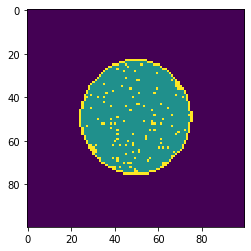

Edge-Ring


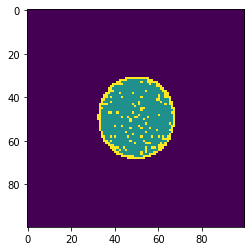

none


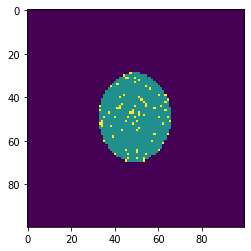

none


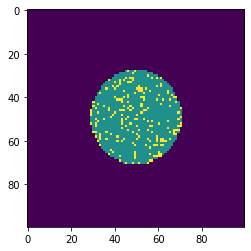

Edge-Ring


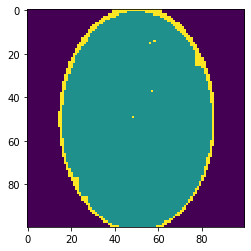

Random


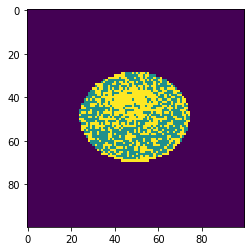

none


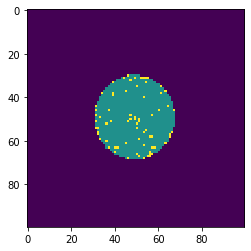

none


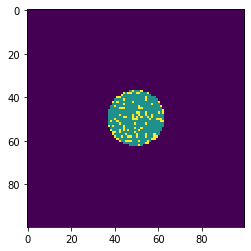

Edge-Loc


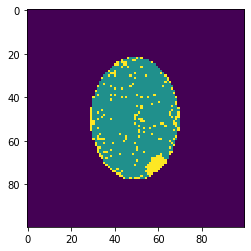

none


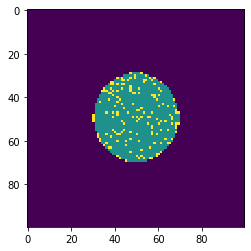

Donut


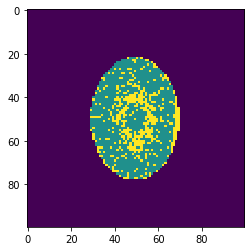

Center


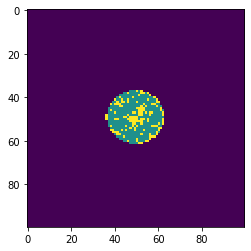

Center


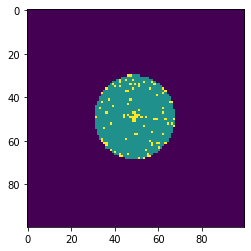

Near-full


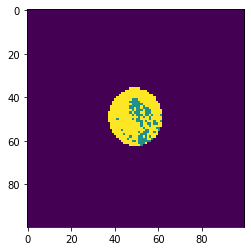

Donut


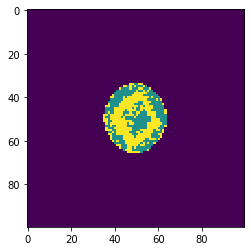

Edge-Ring


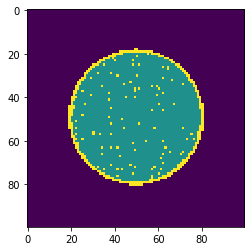

Donut


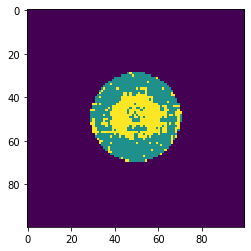

Loc


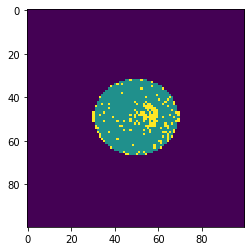

Near-full


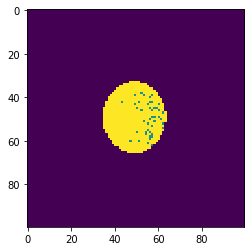

Edge-Loc


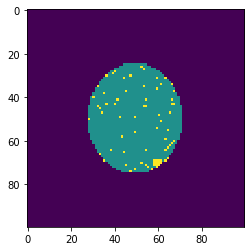

Center


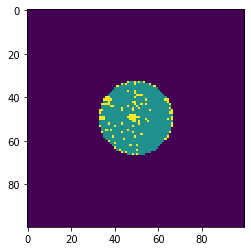

Random


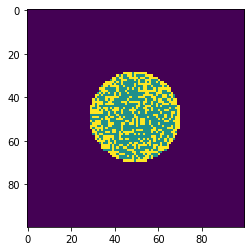

Random


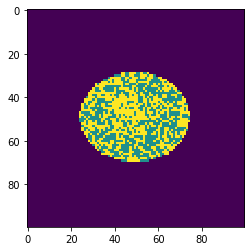

Edge-Ring


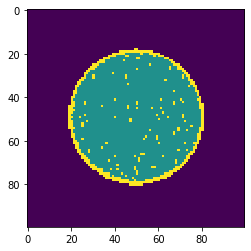

Near-full


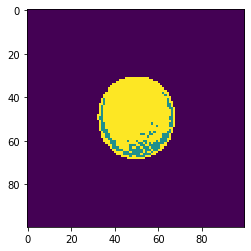

Center


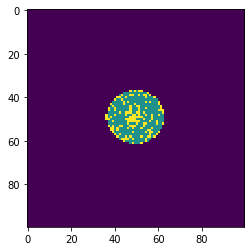

Near-full


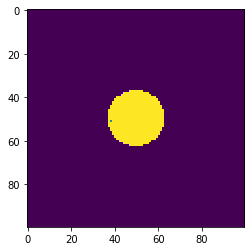

none


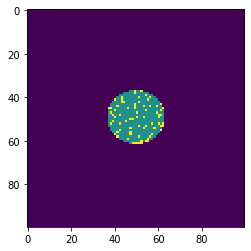

Center


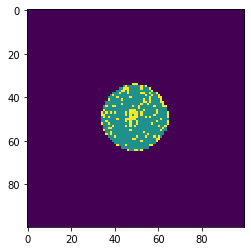

Near-full


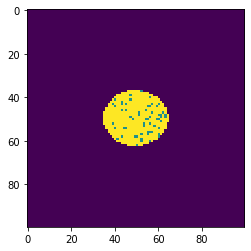

Near-full


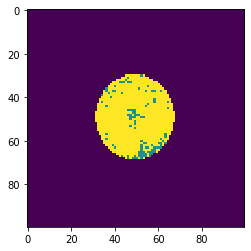

Loc


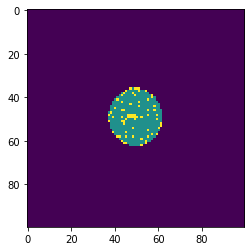

Edge-Loc


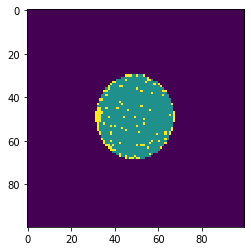

Loc


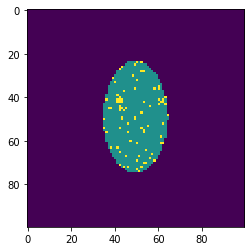

Edge-Ring


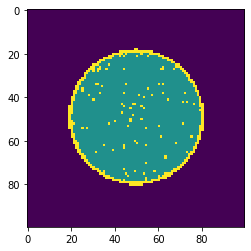

Loc


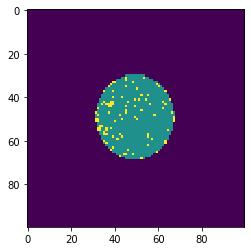

Edge-Loc


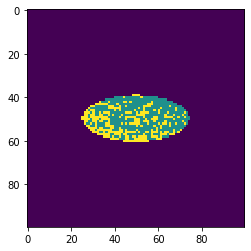

none


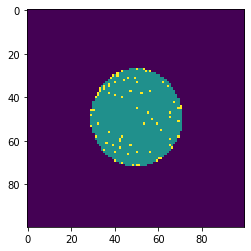

Center


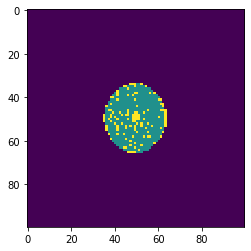

none


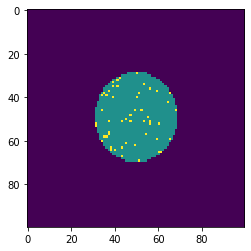

Edge-Loc


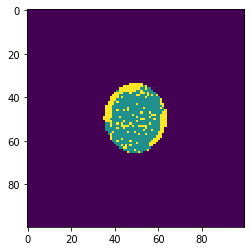

Donut


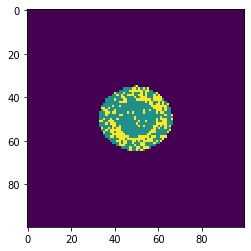

Center


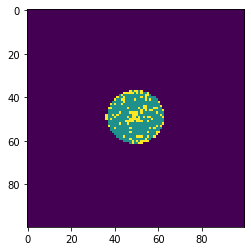

Center


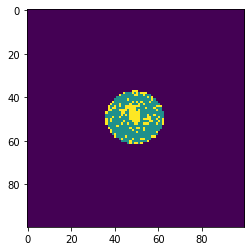

Donut


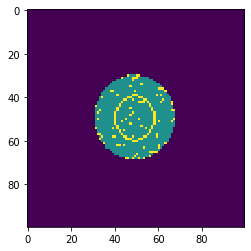

Random


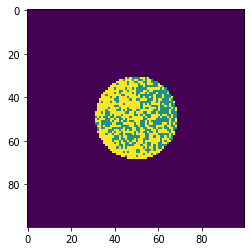

Scratch


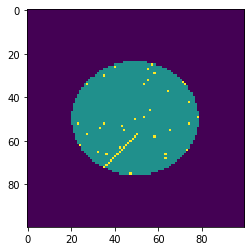

Edge-Loc


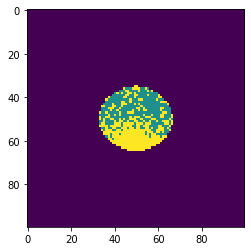

none


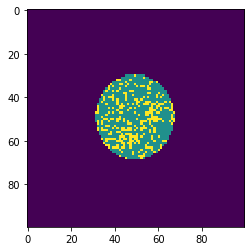

Loc


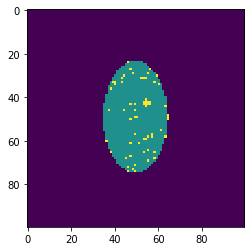

Loc


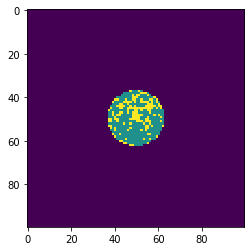

Donut


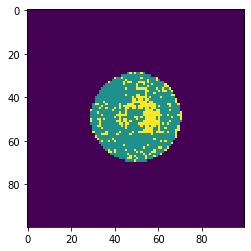

Near-full


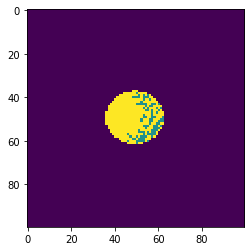

Center


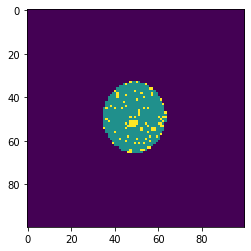

Scratch


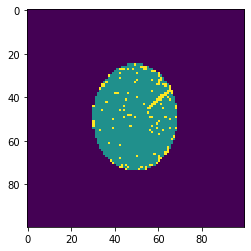

Near-full


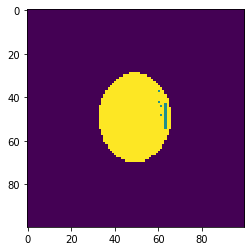

none


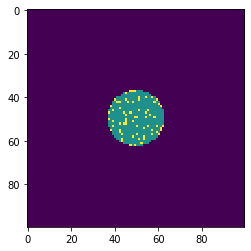

Random


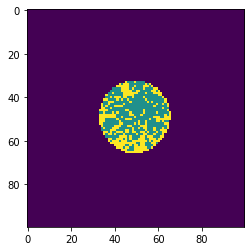

Edge-Ring


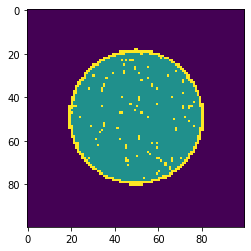

Edge-Ring


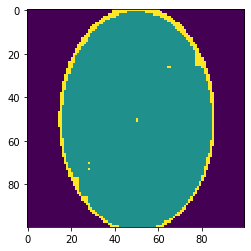

Donut


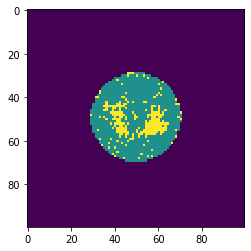

Scratch


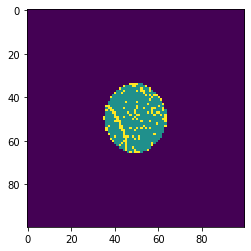

Scratch


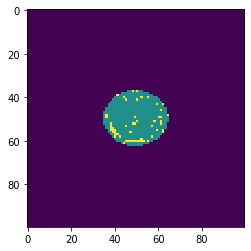

Donut


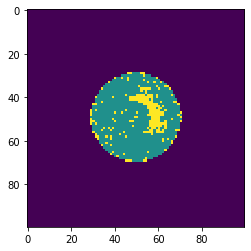

Center


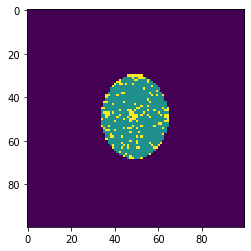

none


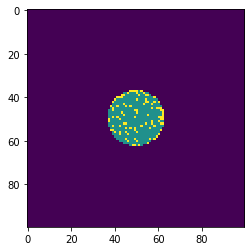

Edge-Ring


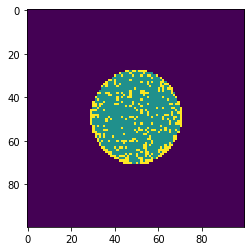

Near-full


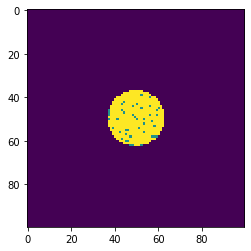

Near-full


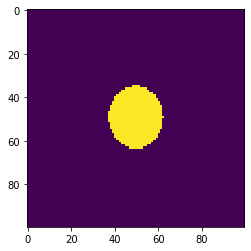

Center


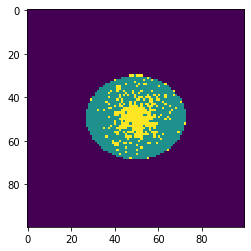

Edge-Ring


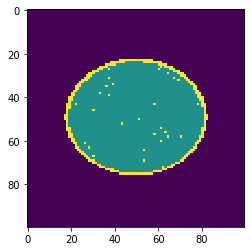

Loc


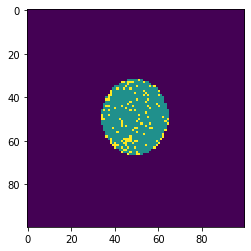

none


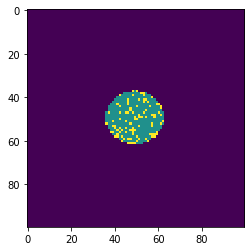

Edge-Ring


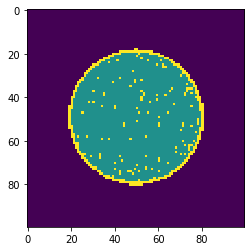

Edge-Loc


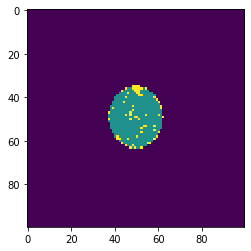

Loc


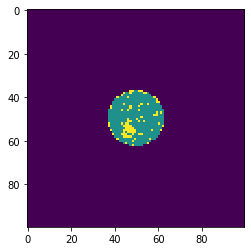

Loc


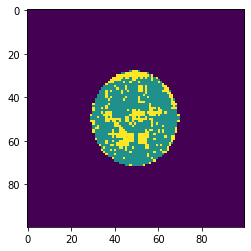

Loc


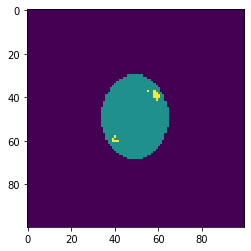

none


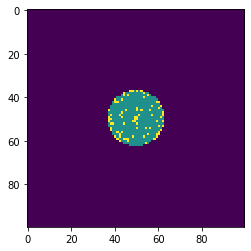

Center


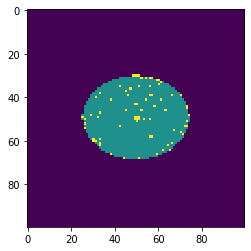

Center


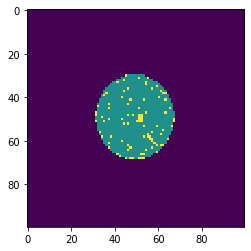

Loc


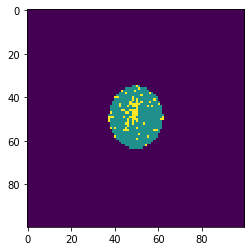

none


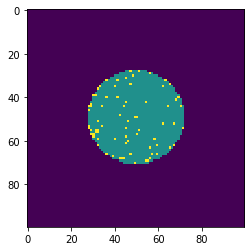

Random


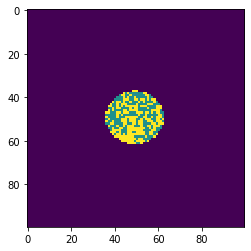

none


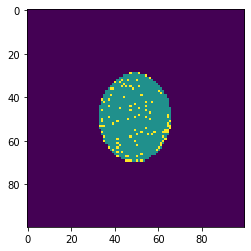

Random


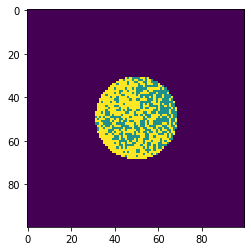

Center


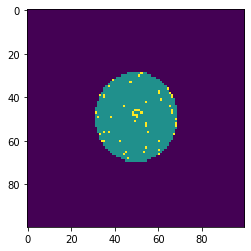

Edge-Ring


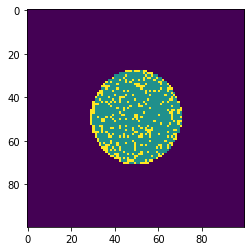

Loc


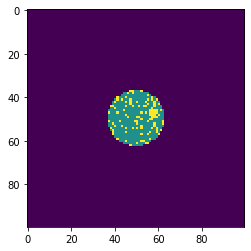

Donut


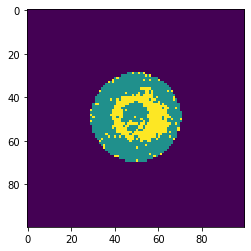

Edge-Loc


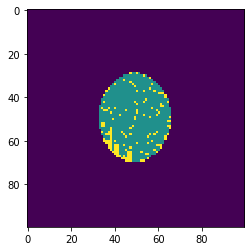

Edge-Ring


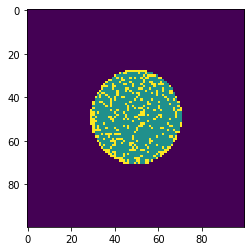

Near-full


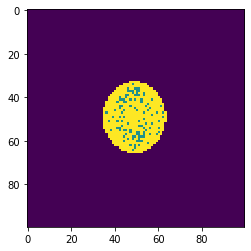

Edge-Loc


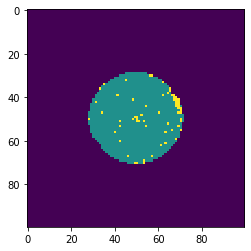

Scratch


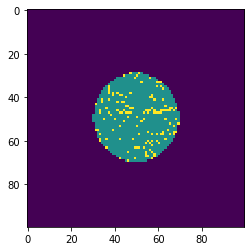

none


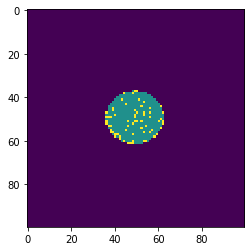

Scratch


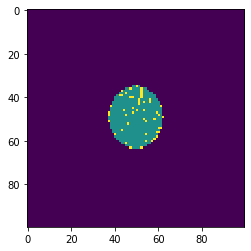

Edge-Ring


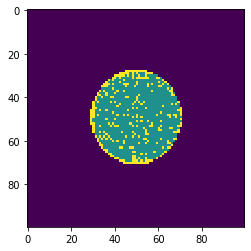

Random


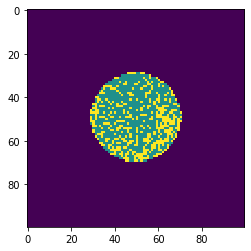

Near-full


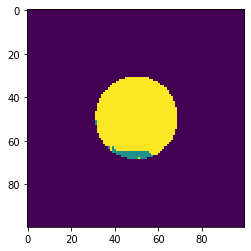

Donut


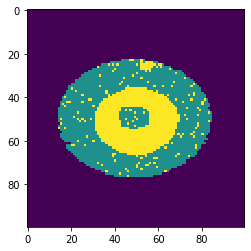

Near-full


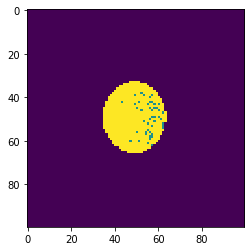

Random


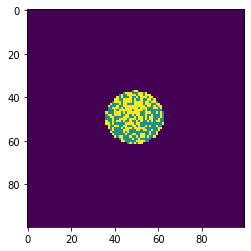

Loc


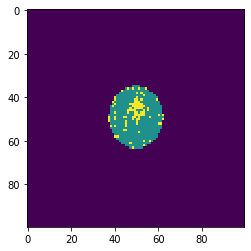

none


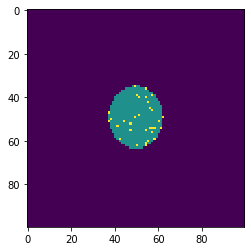

Random


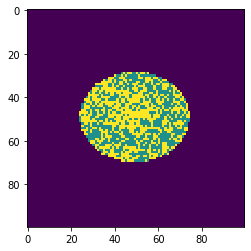

Near-full


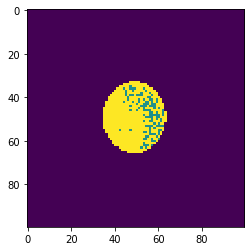

none


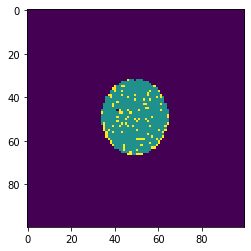

Edge-Loc


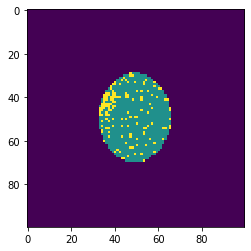

Random


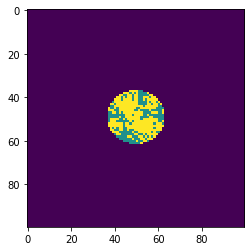

Edge-Loc


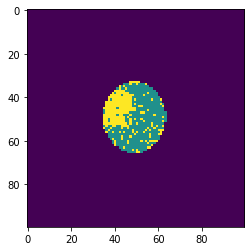

none


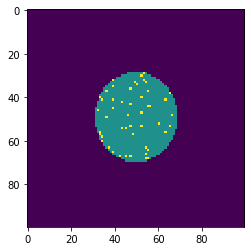

Edge-Ring


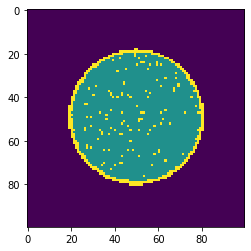

Edge-Ring


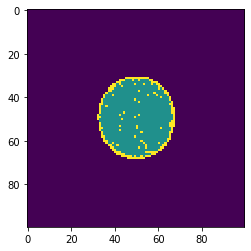

Center


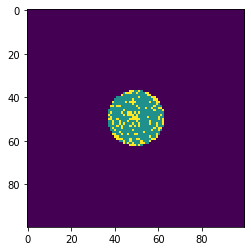

none


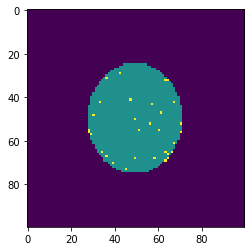

Loc


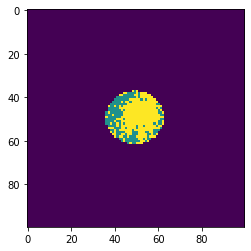

Donut


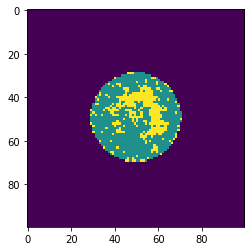

Donut


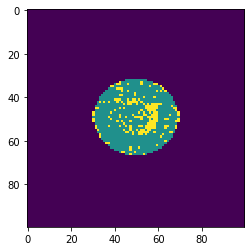

Random


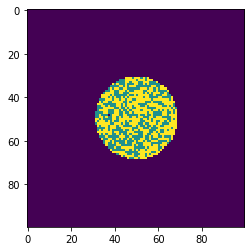

Random


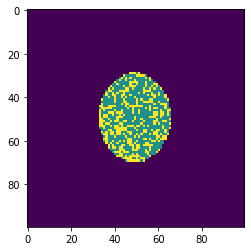

none


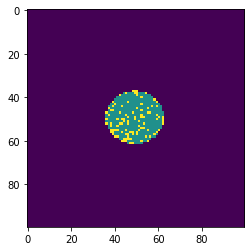

Loc


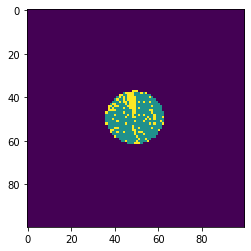

Edge-Ring


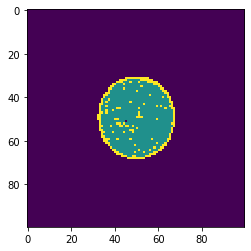

Near-full


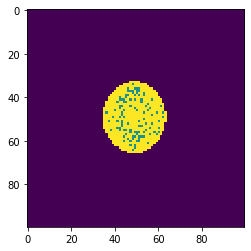

Edge-Loc


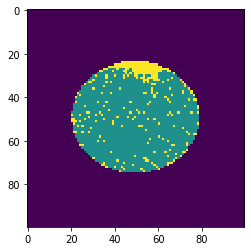

Edge-Ring


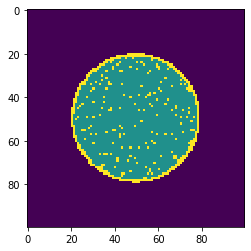

Loc


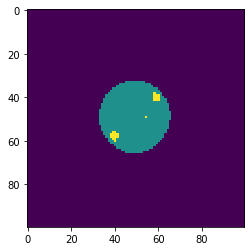

Edge-Ring


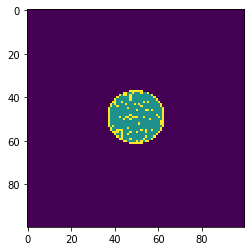

Scratch


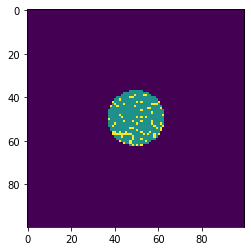

Scratch


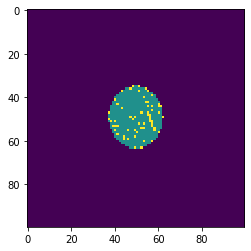

Loc


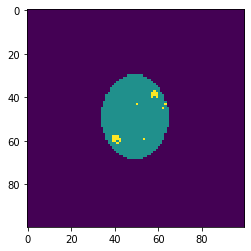

Edge-Loc


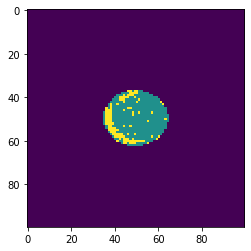

Random


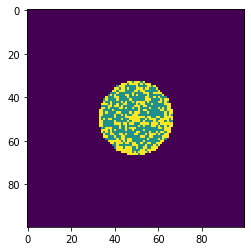

Scratch


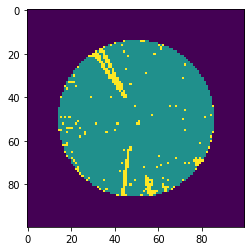

Near-full


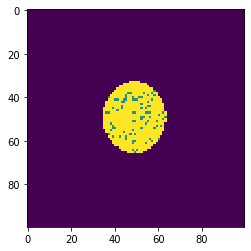

Random


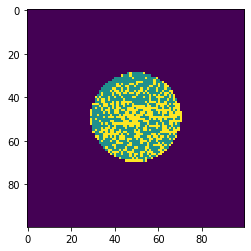

Near-full


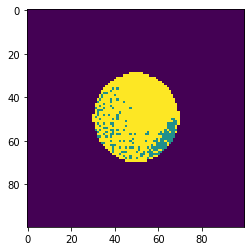

Center


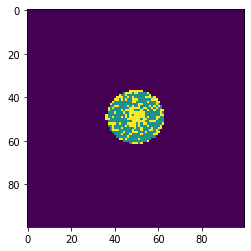

none


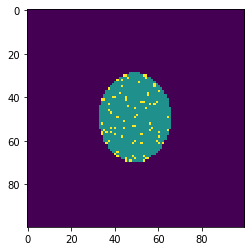

Donut


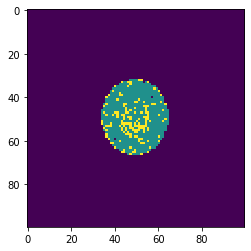

Scratch


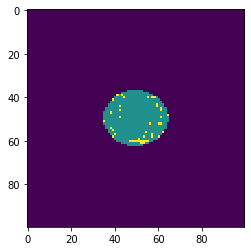

Edge-Loc


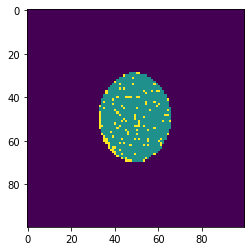

Near-full


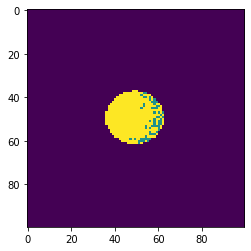

Edge-Ring


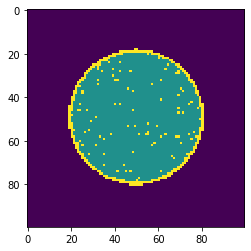

Edge-Ring


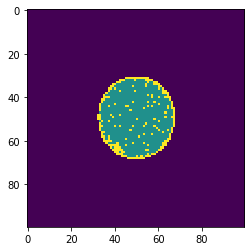

Loc


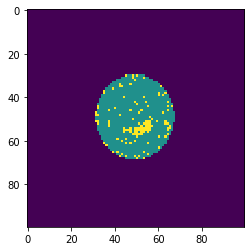

Edge-Ring


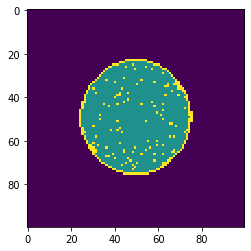

Edge-Loc


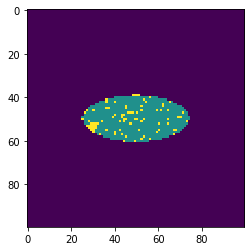

Edge-Ring


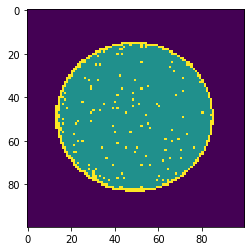

Edge-Loc


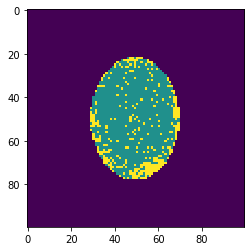

Edge-Loc


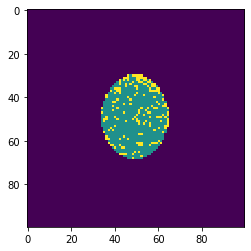

Donut


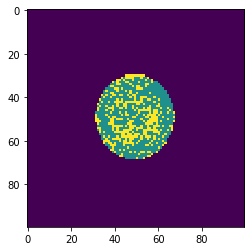

Near-full


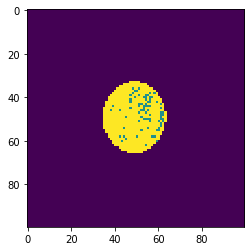

Center


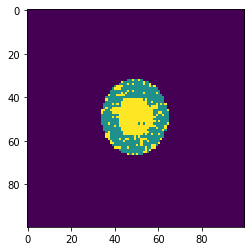

Near-full


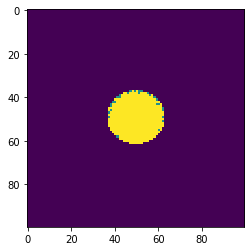

Center


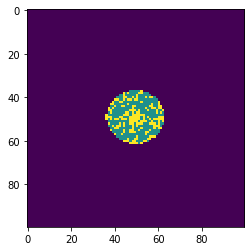

none


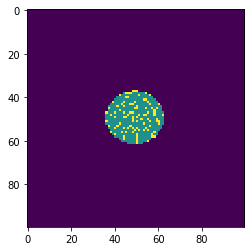

Edge-Ring


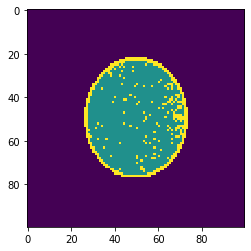

none


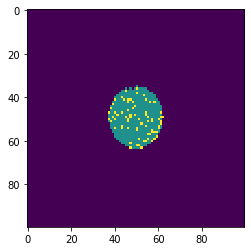

Edge-Loc


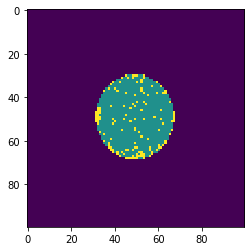

Near-full


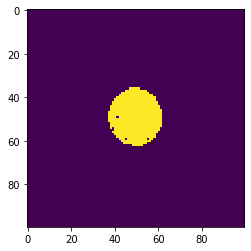

Center


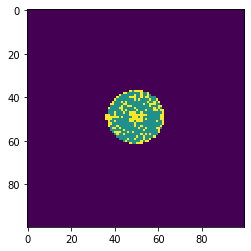

Near-full


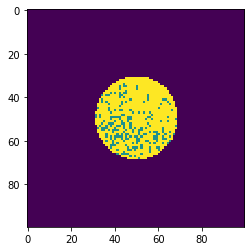

Edge-Ring


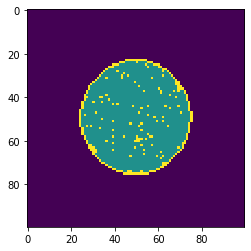

Edge-Ring


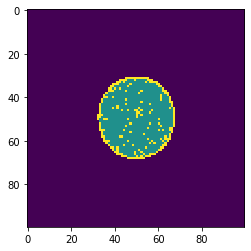

Near-full


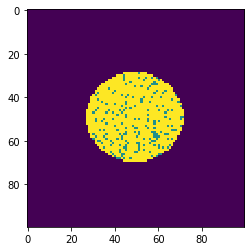

Scratch


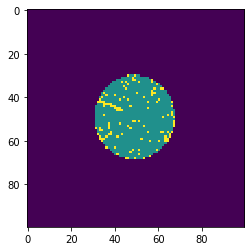

Donut


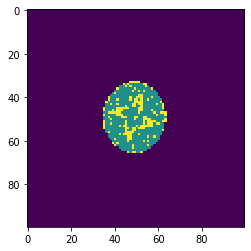

Random


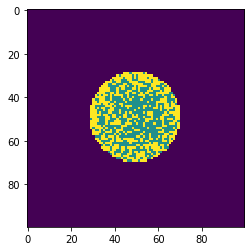

Loc


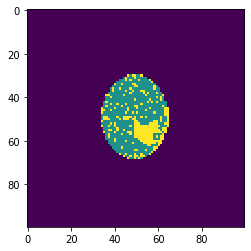

Near-full


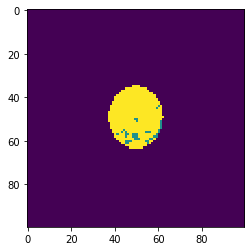

Near-full


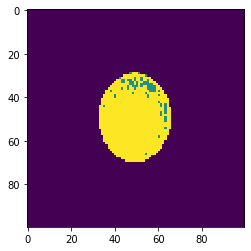

Donut


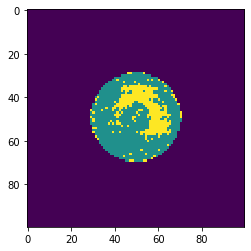

Scratch


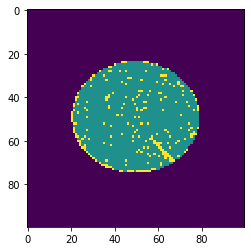

Near-full


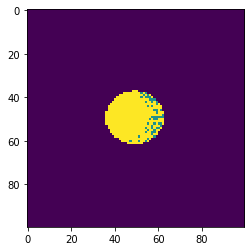

none


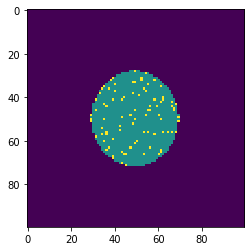

Center


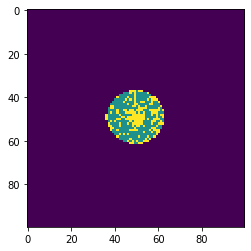

Donut


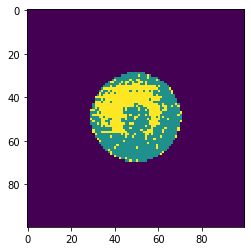

Scratch


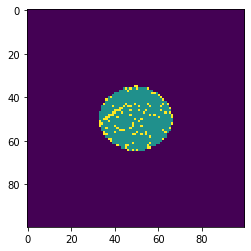

Loc


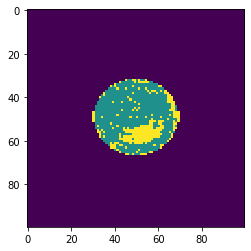

Donut


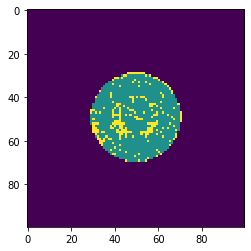

Edge-Loc


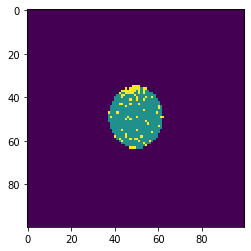

none


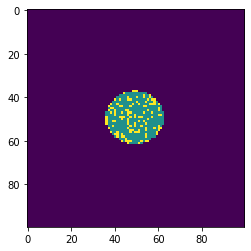

Edge-Ring


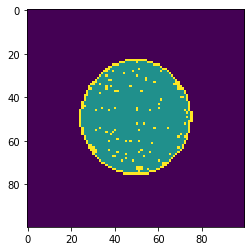

Loc


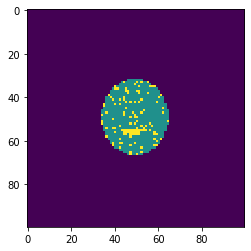

Near-full


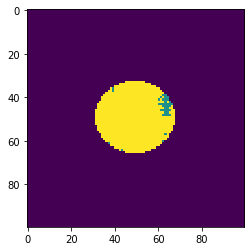

Loc


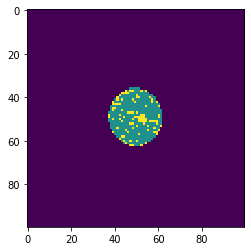

Donut


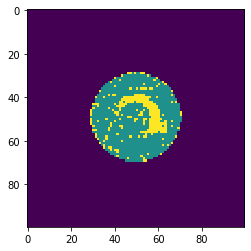

Scratch


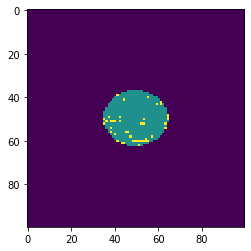

Random


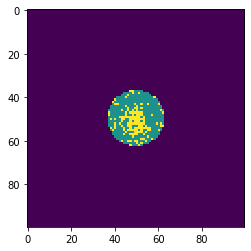

Near-full


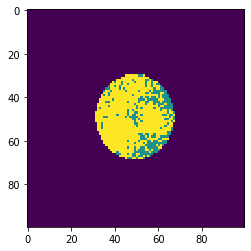

none


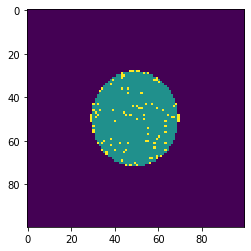

Loc


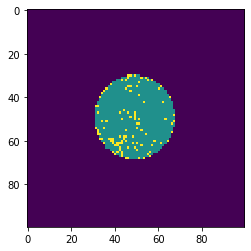

Scratch


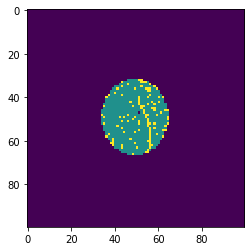

Edge-Loc


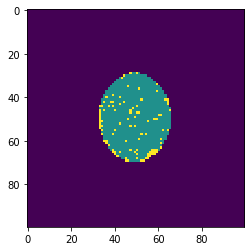

none


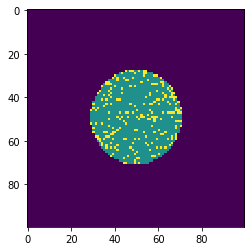

Edge-Loc


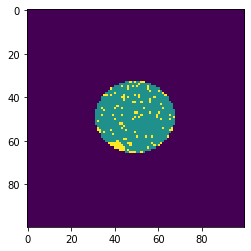

Donut


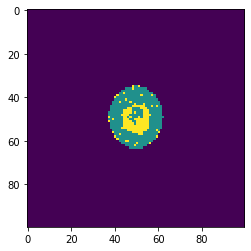

Edge-Loc


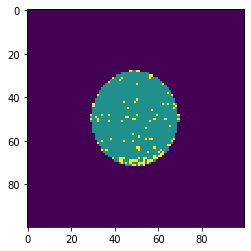

Loc


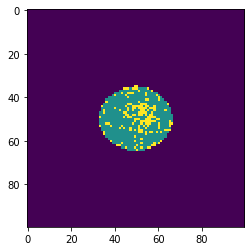

Edge-Ring


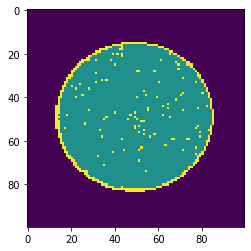

Edge-Ring


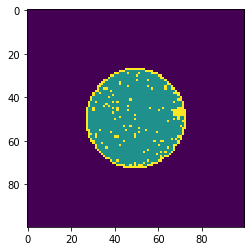

Edge-Ring


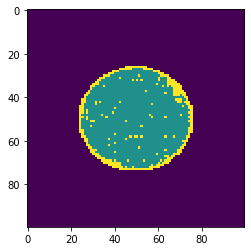

Loc


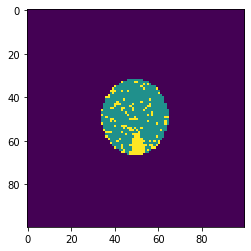

Scratch


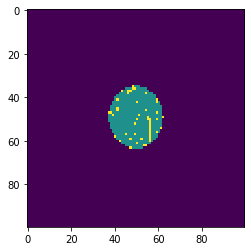

Edge-Ring


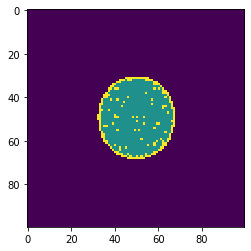

Edge-Ring


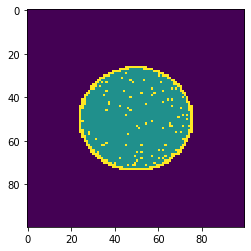

Edge-Loc


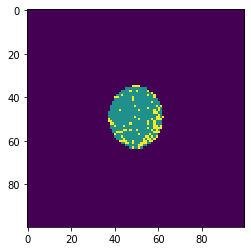

Scratch


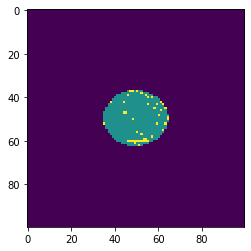

Loc


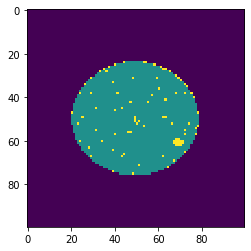

Random


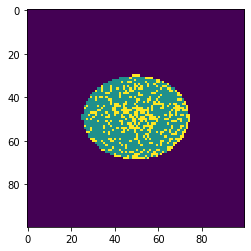

Center


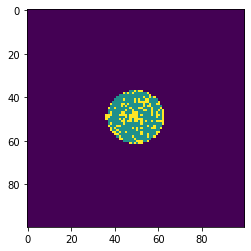

Random


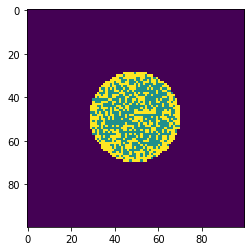

Edge-Ring


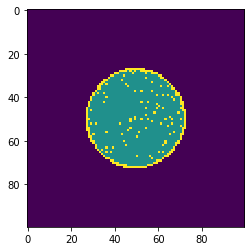

Scratch


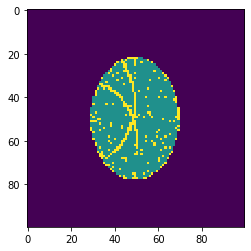

Scratch


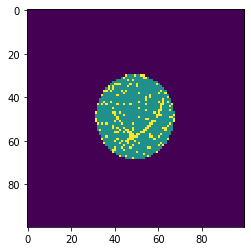

Donut


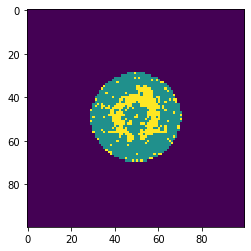

Loc


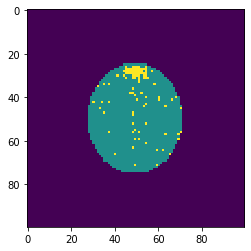

Center


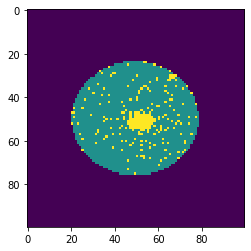

Scratch


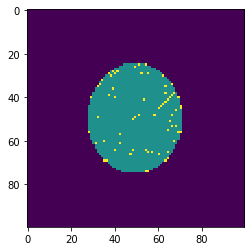

Edge-Loc


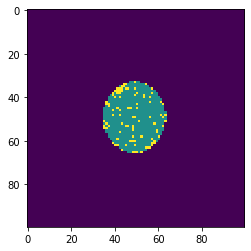

Donut


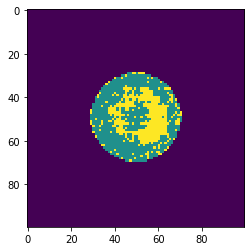

Loc


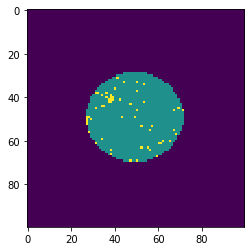

Center


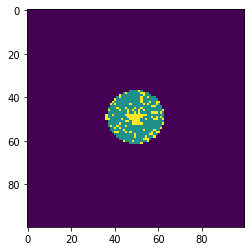

Donut


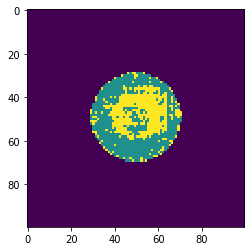

Center


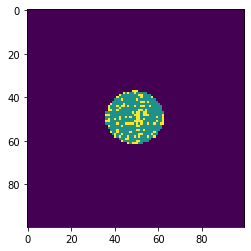

Center


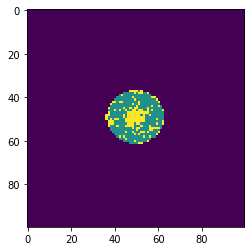

none


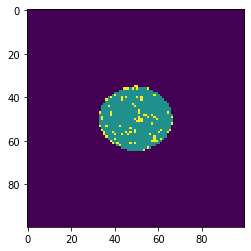

Loc


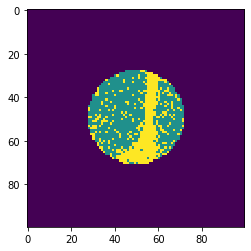

Center


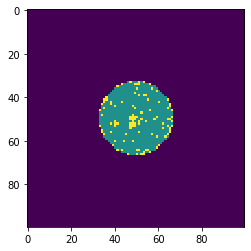

Edge-Ring


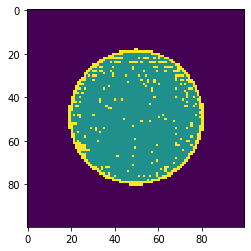

Donut


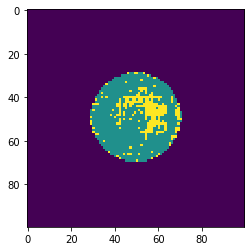

Scratch


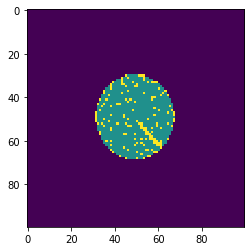

Scratch


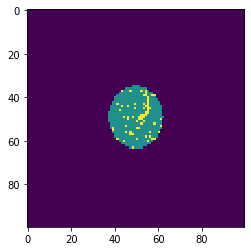

Random


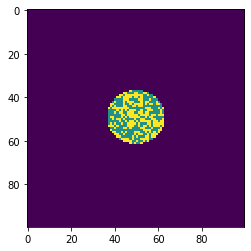

Edge-Ring


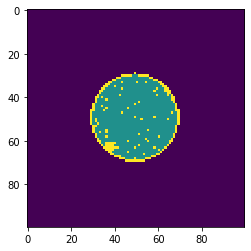

Near-full


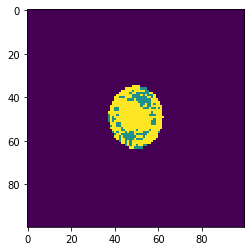

Edge-Loc


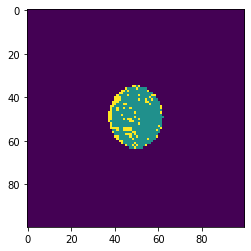

Near-full


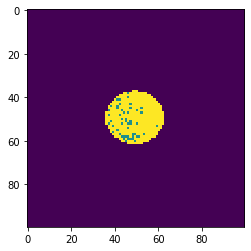

Scratch


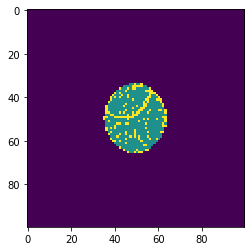

Edge-Ring


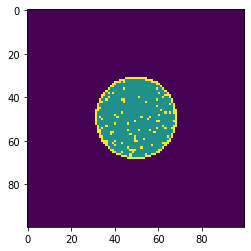

Near-full


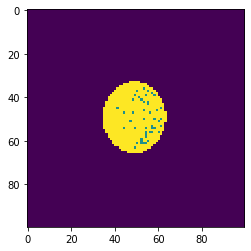

Center


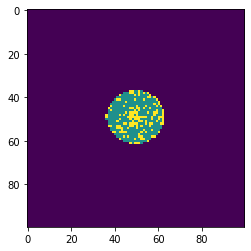

Edge-Ring


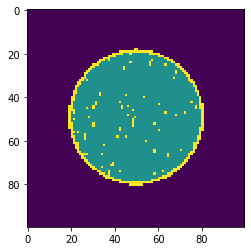

Edge-Ring


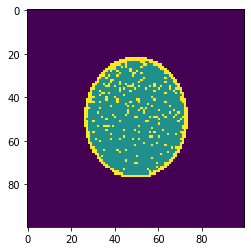

Near-full


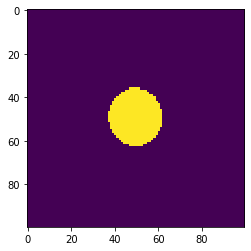

Edge-Ring


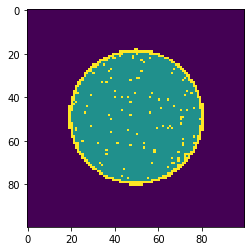

Scratch


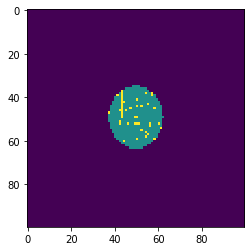

none


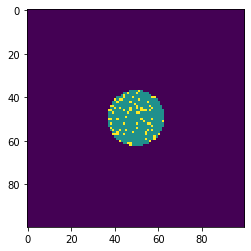

Random


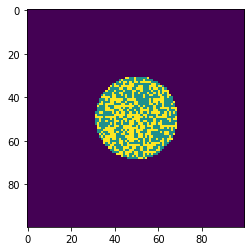

Edge-Loc


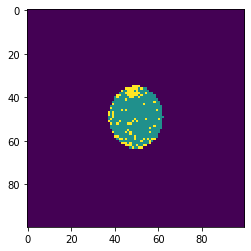

Scratch


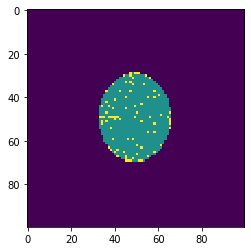

Edge-Ring


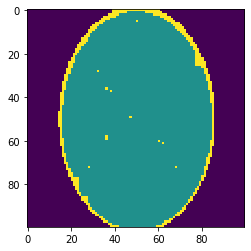

Loc


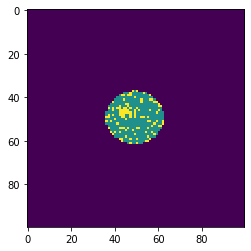

Near-full


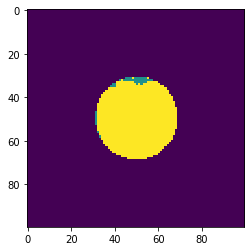

Edge-Loc


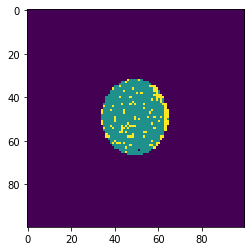

Near-full


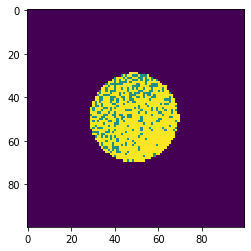

Center


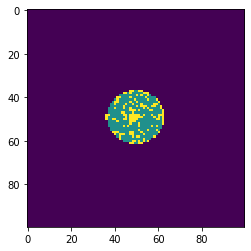

Scratch


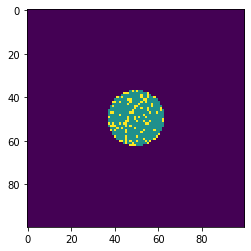

Near-full


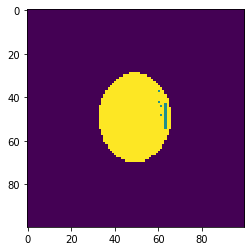

Center


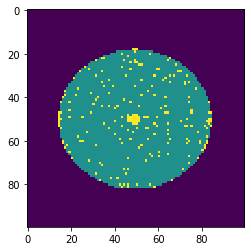

Near-full


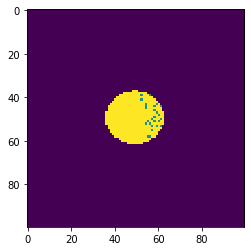

Donut


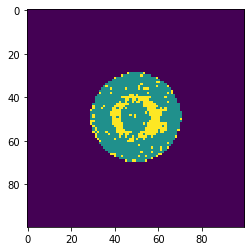

Loc


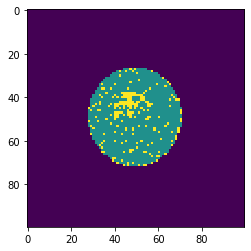

Edge-Loc


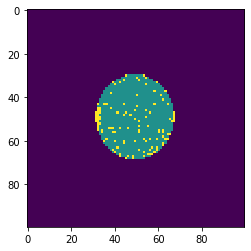

Edge-Loc


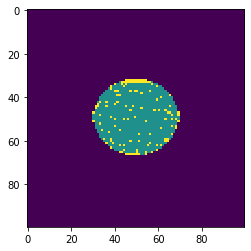

none


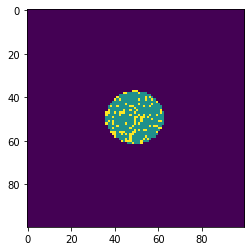

Donut


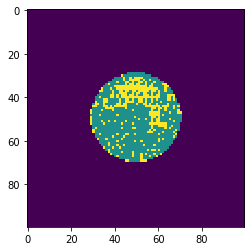

none


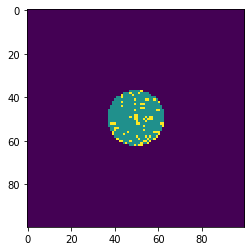

Center


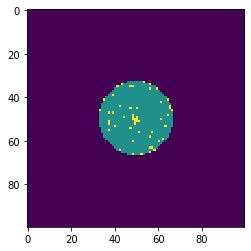

Random


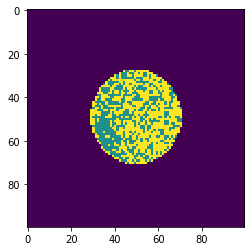

Center


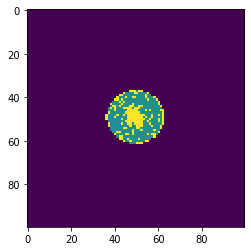

none


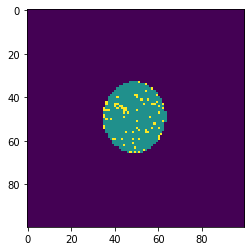

none


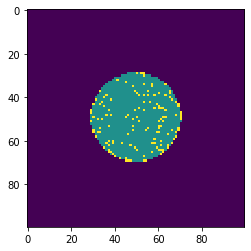

Loc


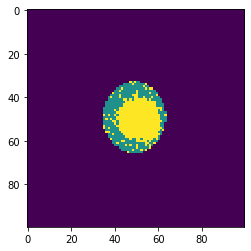

none


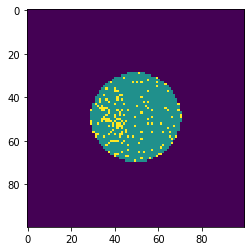

Loc


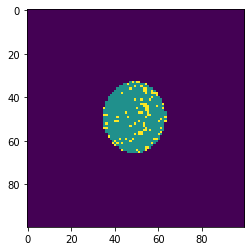

none


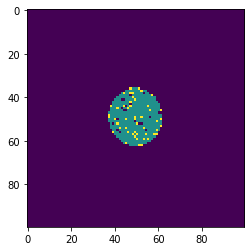

Scratch


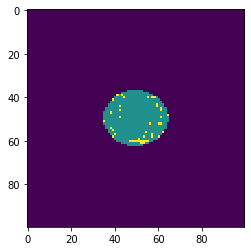

Loc


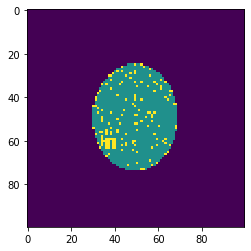

Donut


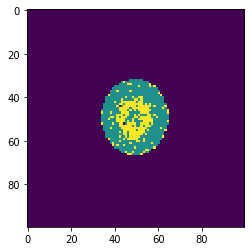

Scratch


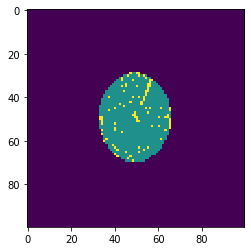

Edge-Ring


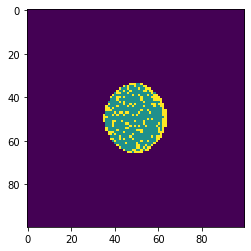

Center


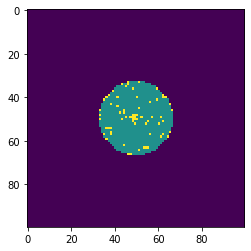

none


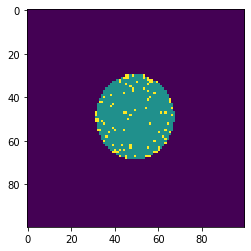

Center


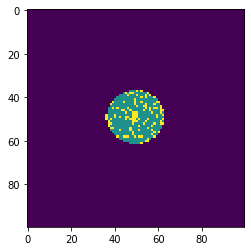

Loc


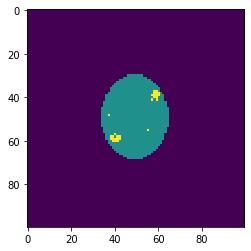

none


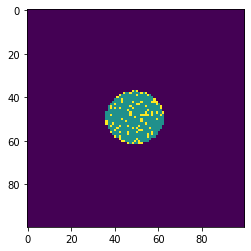

Edge-Loc


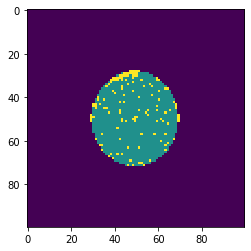

Loc


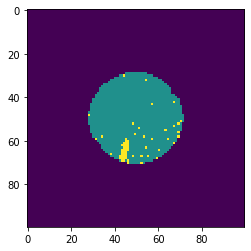

Loc


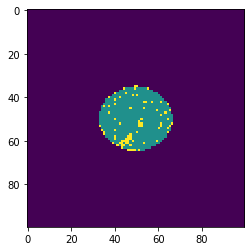

Edge-Ring


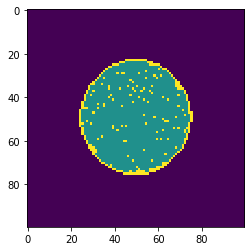

Near-full


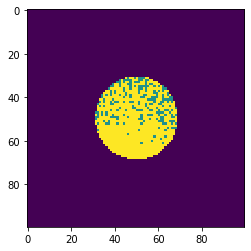

Near-full


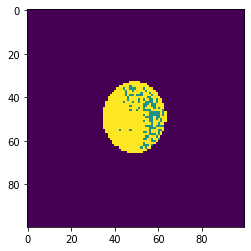

Random


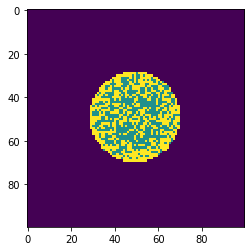

Near-full


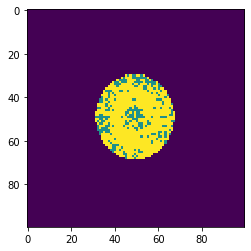

Edge-Loc


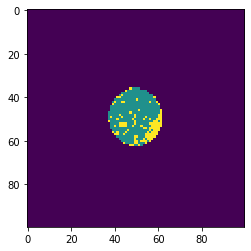

Scratch


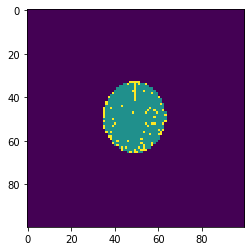

Near-full


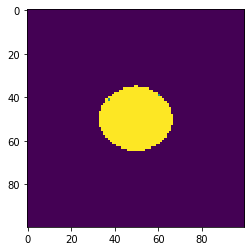

Loc


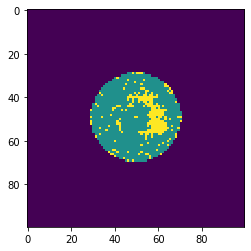

Loc


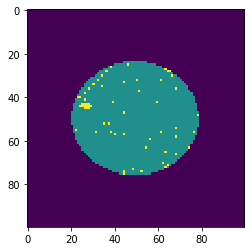

Loc


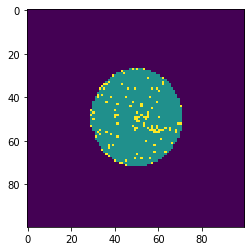

Near-full


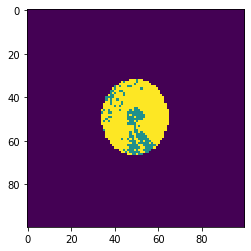

Edge-Ring


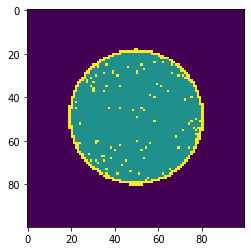

Center


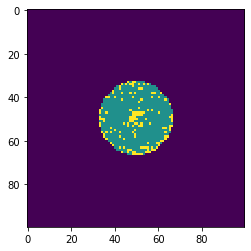

none


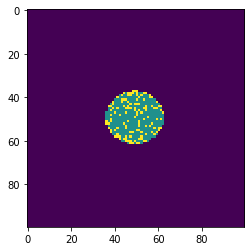

Random


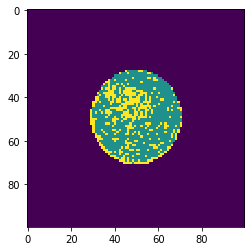

Near-full


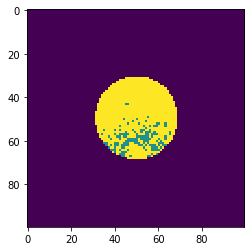

Near-full


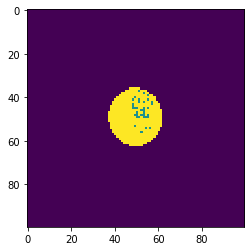

Near-full


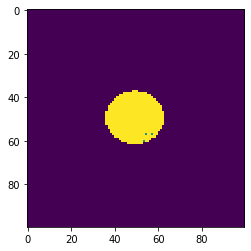

Near-full


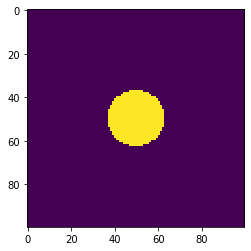

Center


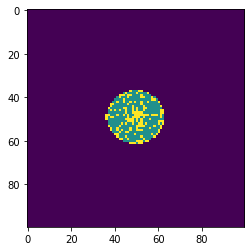

Edge-Loc


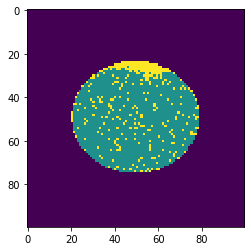

Random


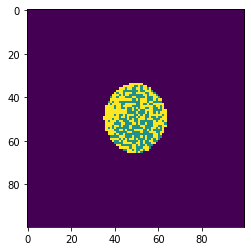

Center


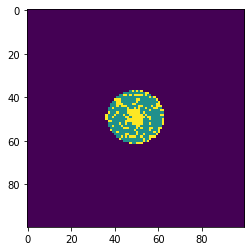

Near-full


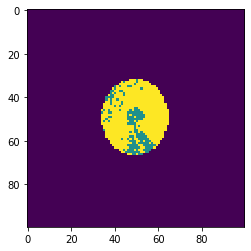

Center


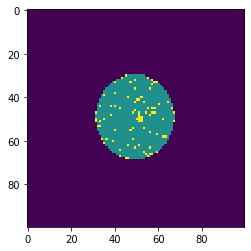

Random


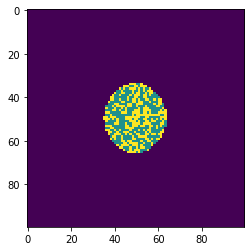

Edge-Ring


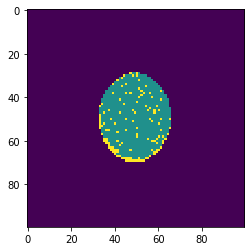

Edge-Ring


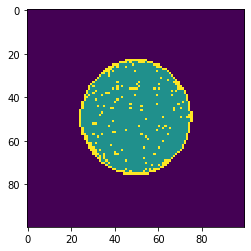

none


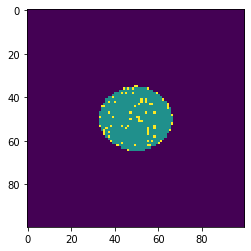

none


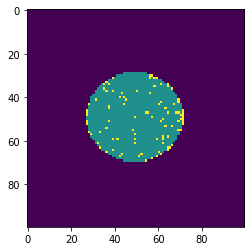

Edge-Ring


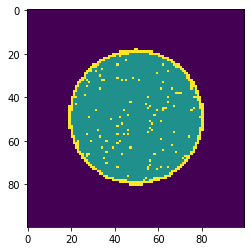

Scratch


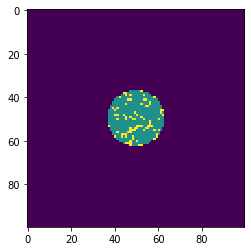

Donut


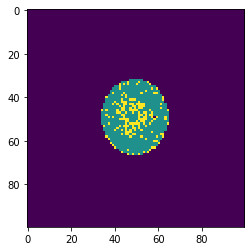

Scratch


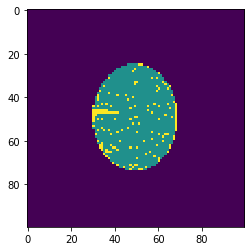

Center


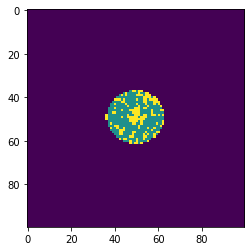

Loc


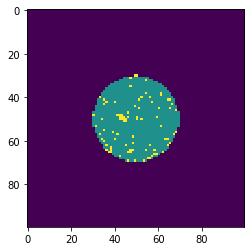

Loc


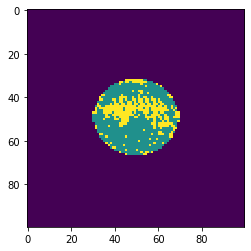

Loc


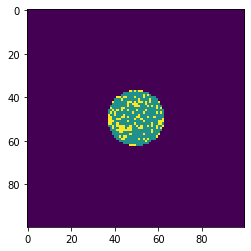

Near-full


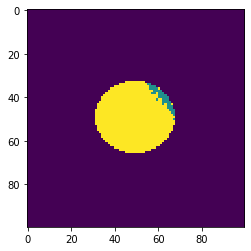

Random


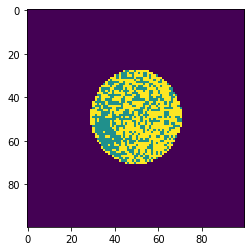

Edge-Ring


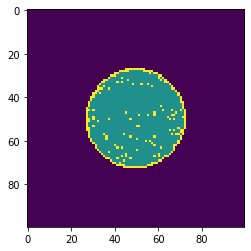

none


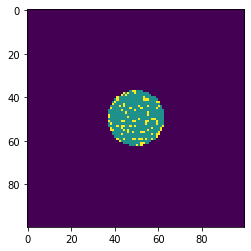

Edge-Loc


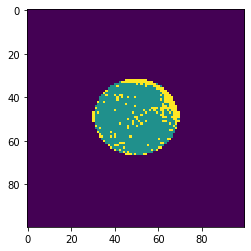

Edge-Loc


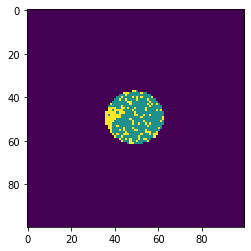

Near-full


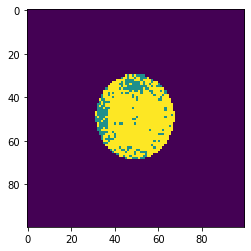

Edge-Ring


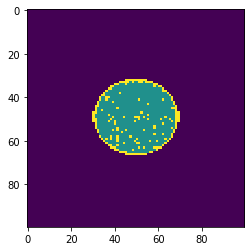

Donut


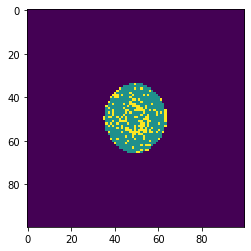

Edge-Loc


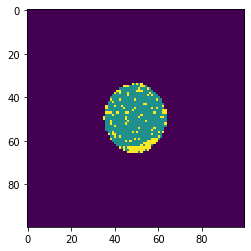

Scratch


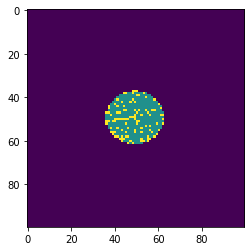

none


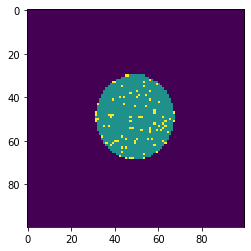

Center


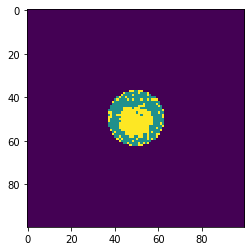

none


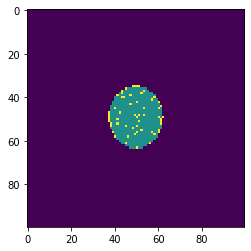

Edge-Loc


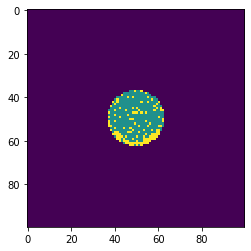

Center


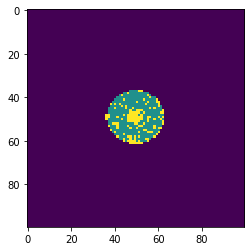

Scratch


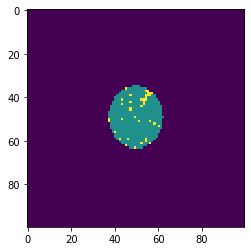

Loc


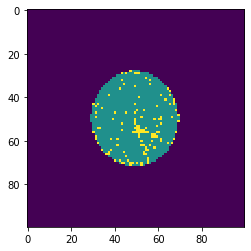

none


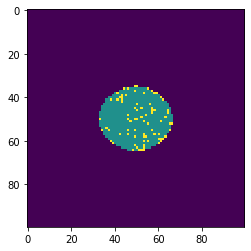

Donut


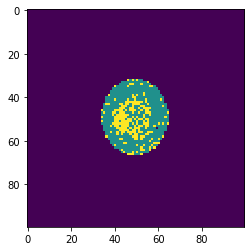

Donut


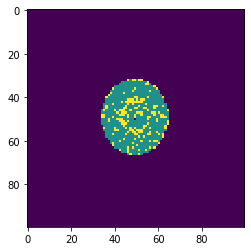

Random


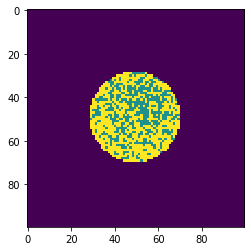

none


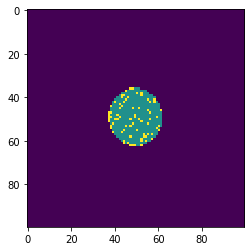

Scratch


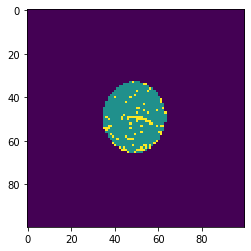

Near-full


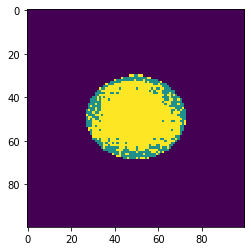

Random


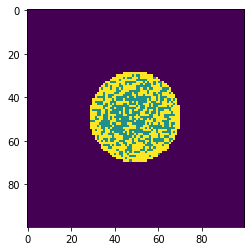

Edge-Ring


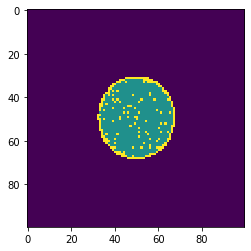

Donut


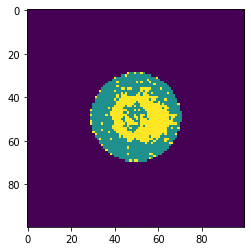

Loc


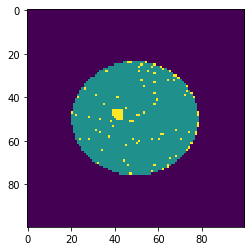

Donut


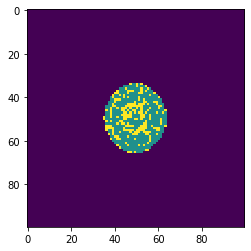

Edge-Ring


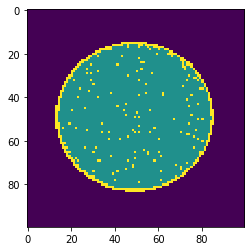

Random


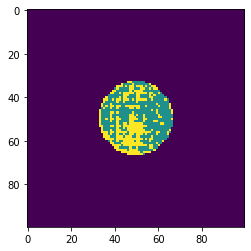

Edge-Ring


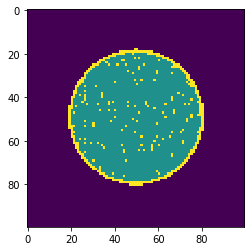

none


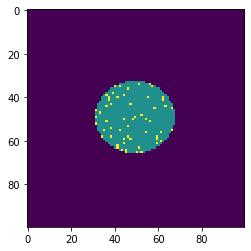

Loc


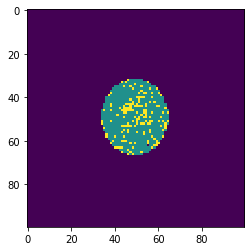

Donut


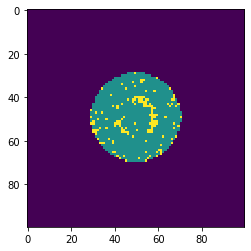

Edge-Ring


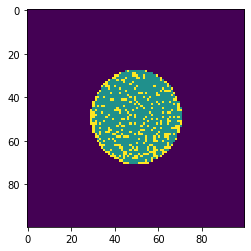

Edge-Ring


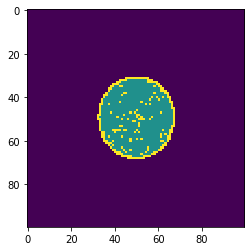

Edge-Ring


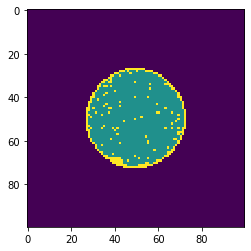

Loc


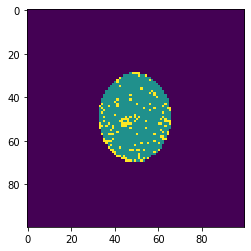

Loc


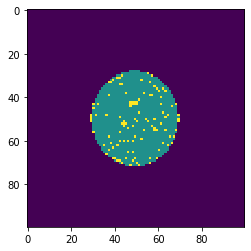

Near-full


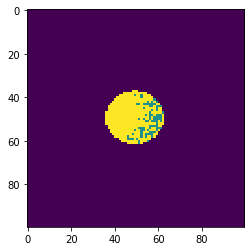

Random


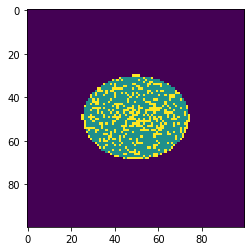

none


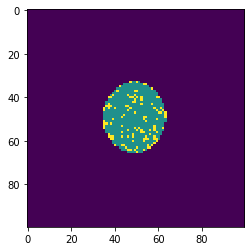

Donut


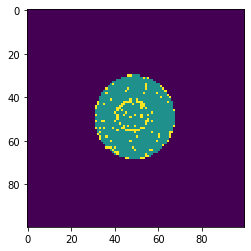

Random


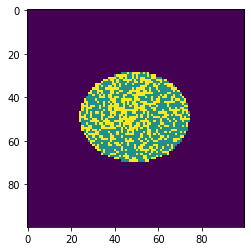

Loc


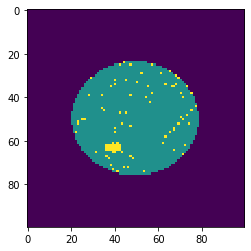

Near-full


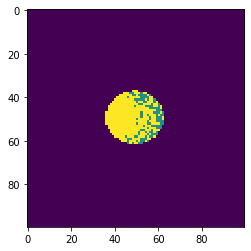

Random


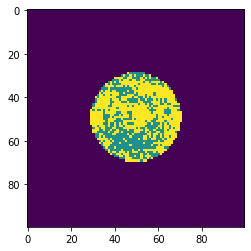

Random


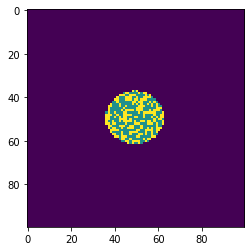

Center


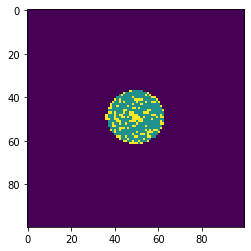

Random


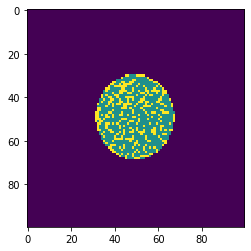

Near-full


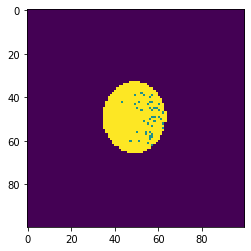

Loc


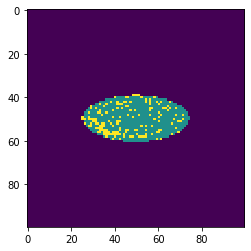

Edge-Ring


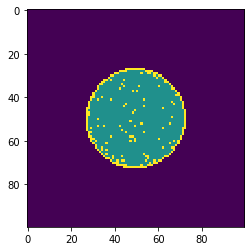

Loc


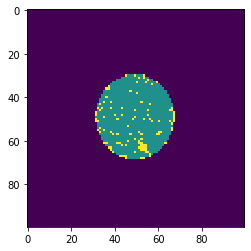

Random


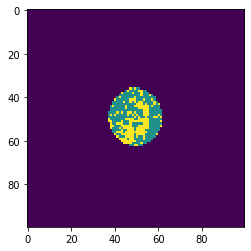

Loc


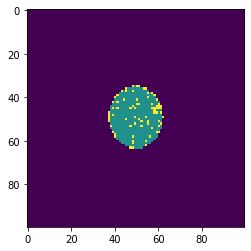

none


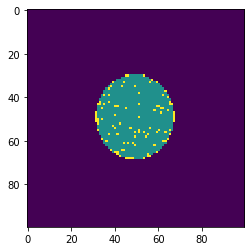

Near-full


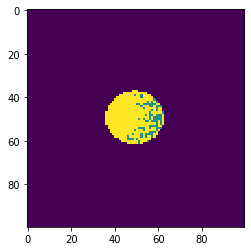

Scratch


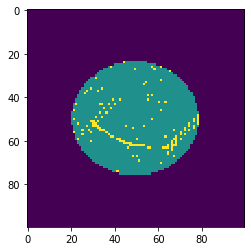

Near-full


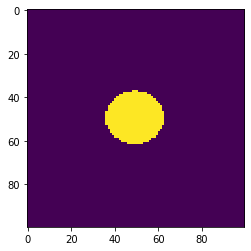

Center


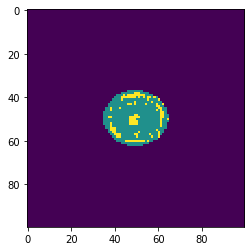

Random


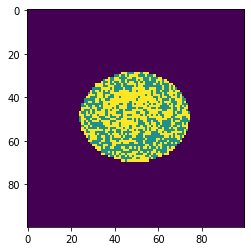

Center


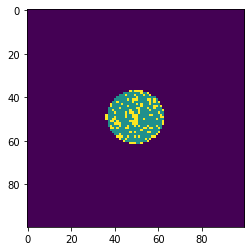

none


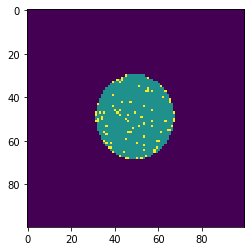

Random


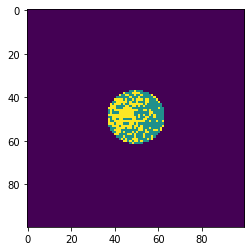

Center


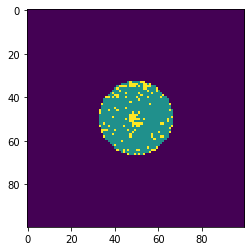

Scratch


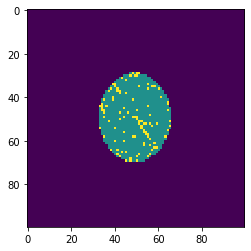

Random


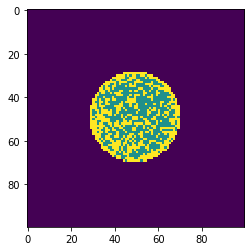

Scratch


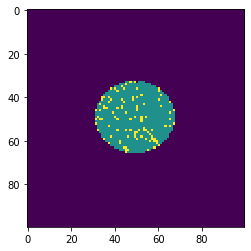

none


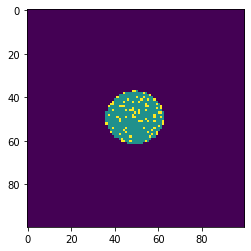

Random


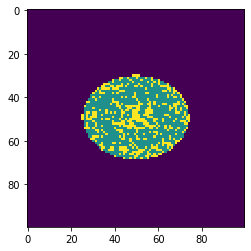

Loc


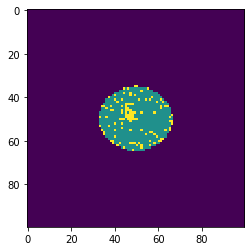

Near-full


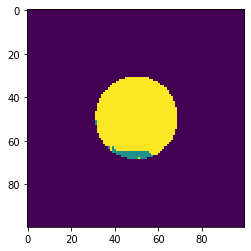

Loc


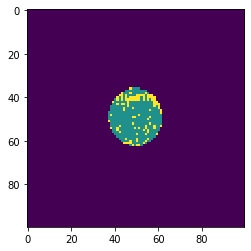

Loc


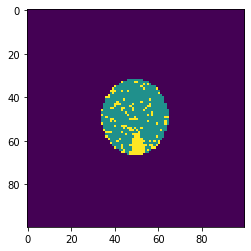

none


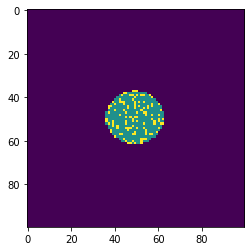

Random


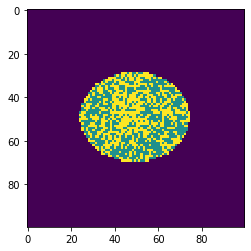

none


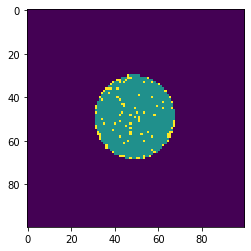

Edge-Loc


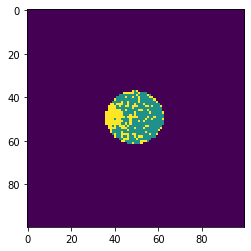

Center


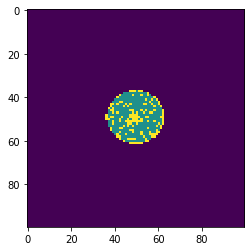

Edge-Ring


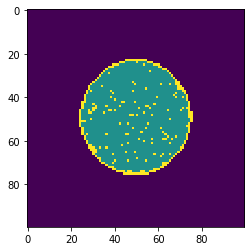

Edge-Ring


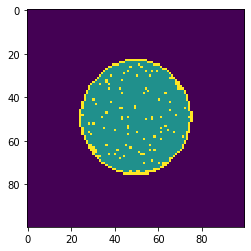

Center


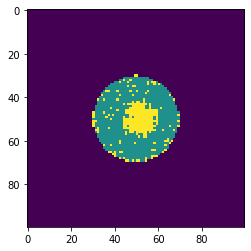

Near-full


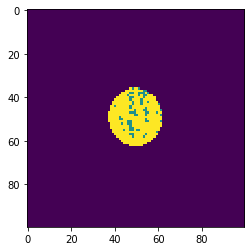

Near-full


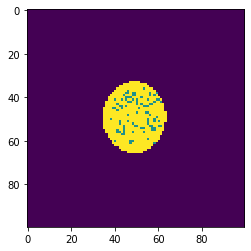

none


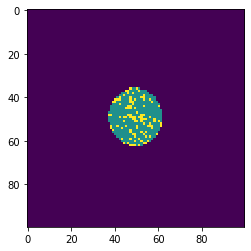

Donut


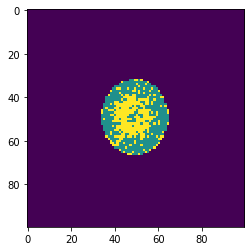

Near-full


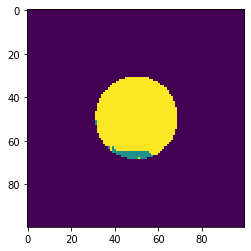

Center


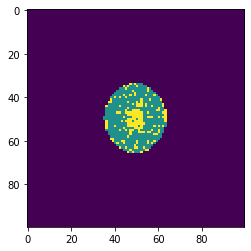

Edge-Ring


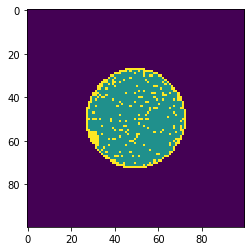

Scratch


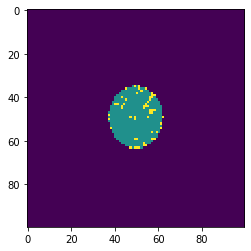

Loc


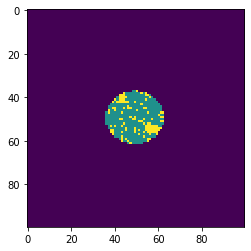

Near-full


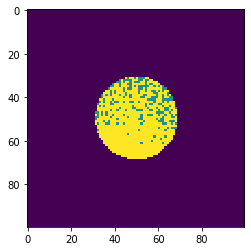

Scratch


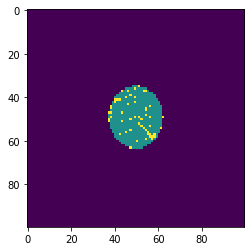

none


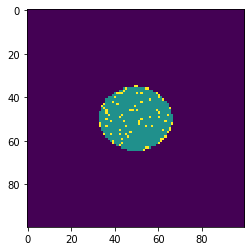

Center


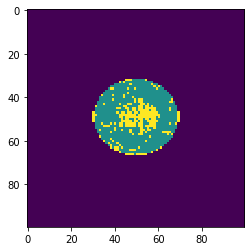

Edge-Ring


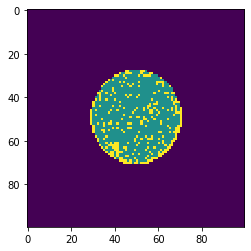

Near-full


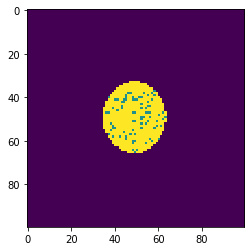

Near-full


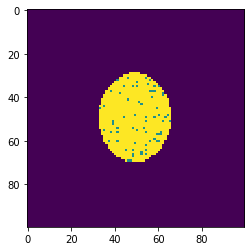

Center


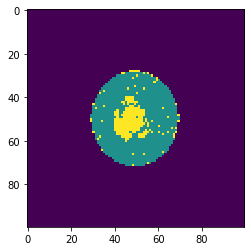

Near-full


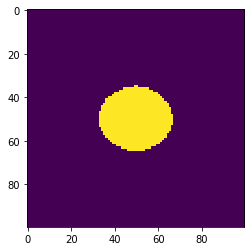

Scratch


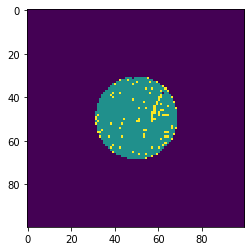

Center


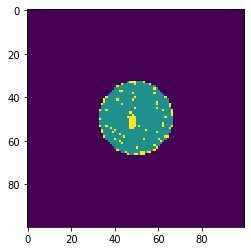

Center


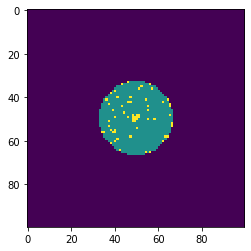

Near-full


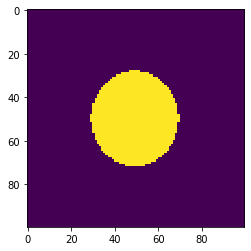

Near-full


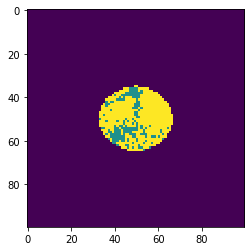

none


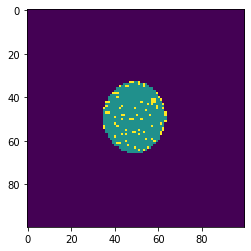

Near-full


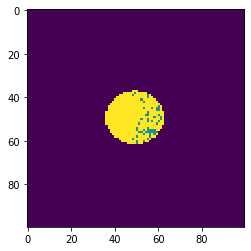

Loc


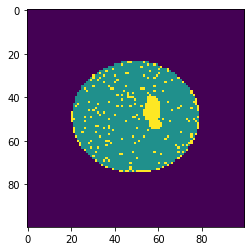

Center


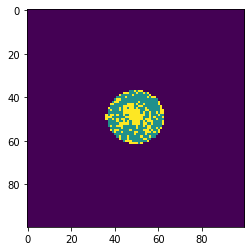

Donut


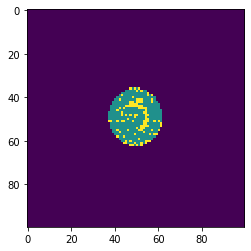

Edge-Loc


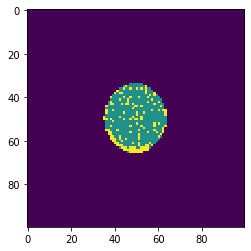

Random


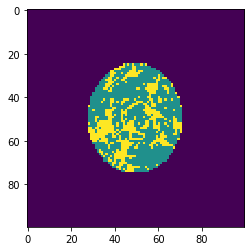

Scratch


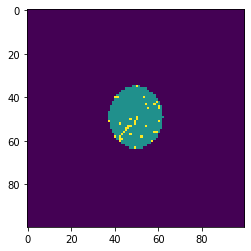

Edge-Loc


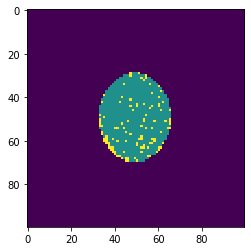

Edge-Ring


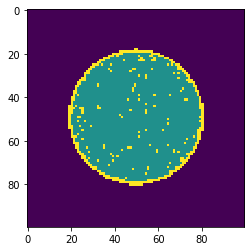

Edge-Ring


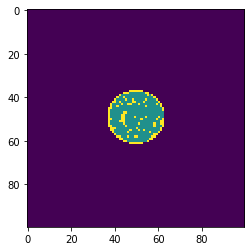

none


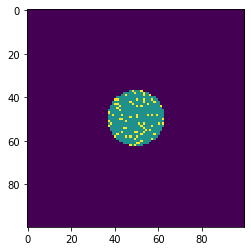

none


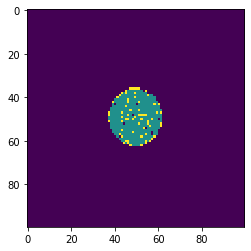

Near-full


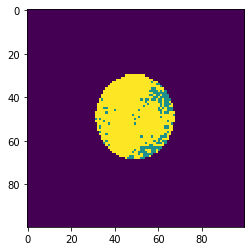

Edge-Loc


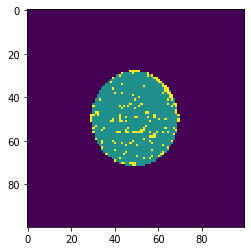

Edge-Loc


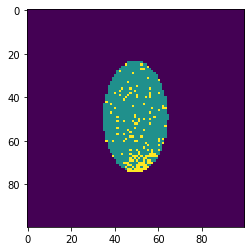

Donut


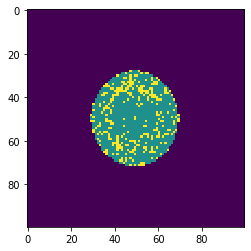

Edge-Loc


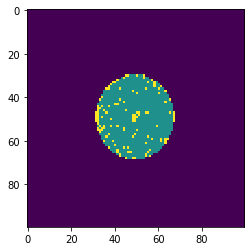

Donut


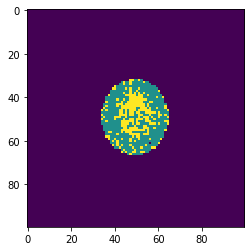

Edge-Loc


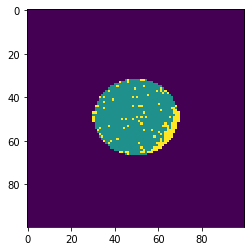

Near-full


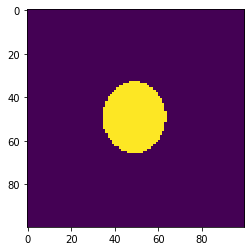

Donut


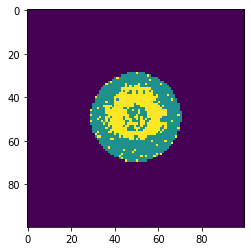

none


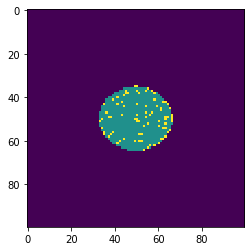

Edge-Loc


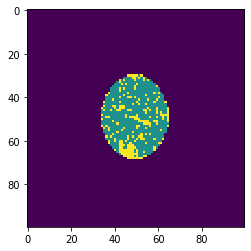

Loc


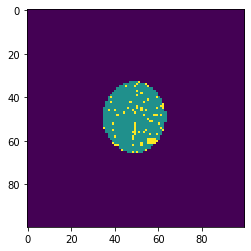

Loc


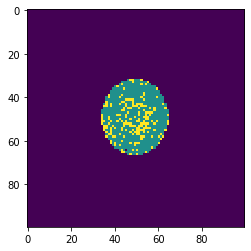

Edge-Loc


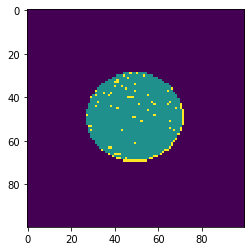

Scratch


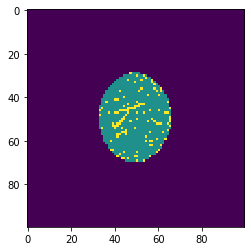

Edge-Loc


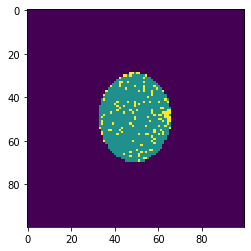

Loc


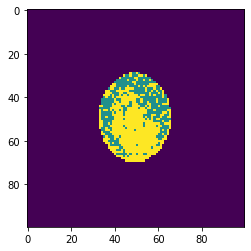

Loc


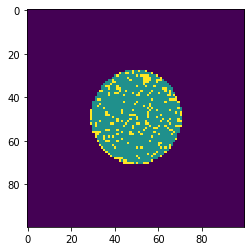

none


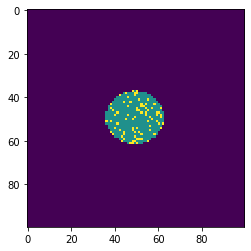

none


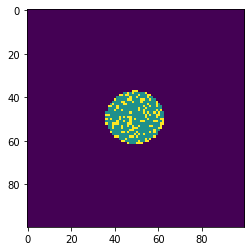

Edge-Ring


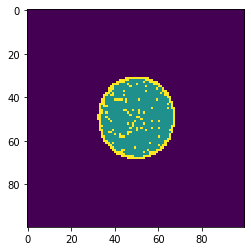

Near-full


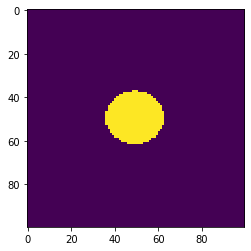

Loc


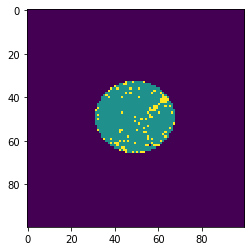

Loc


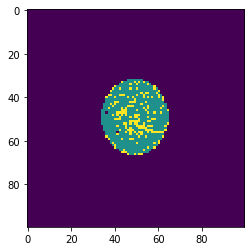

Center


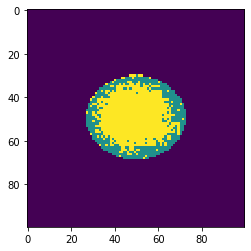

Loc


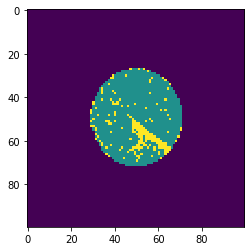

Edge-Ring


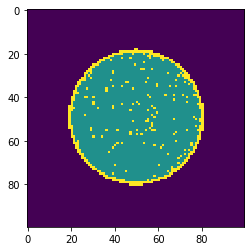

none


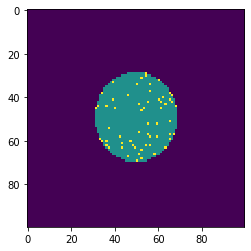

Donut


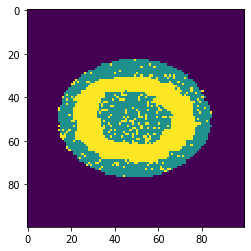

none


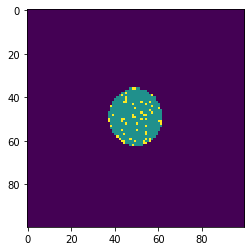

Loc


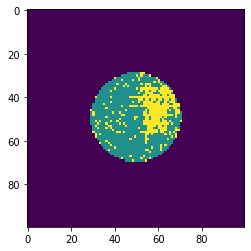

Donut


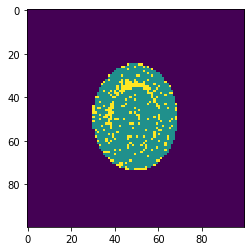

Near-full


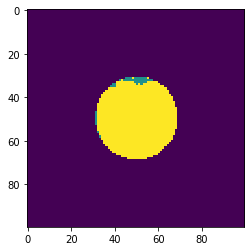

Random


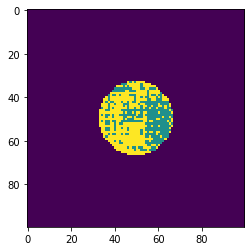

Random


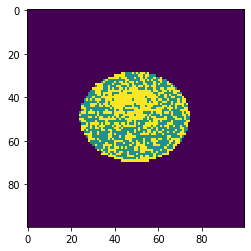

Center


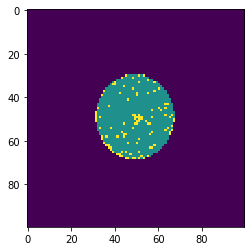

Edge-Ring


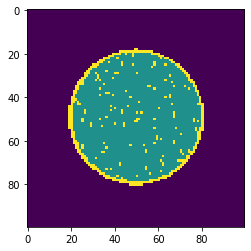

none


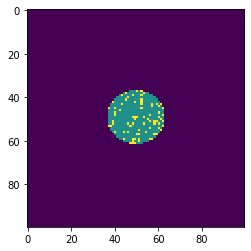

Near-full


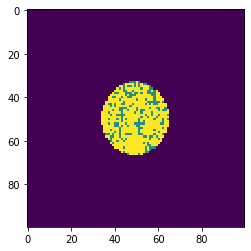

Edge-Loc


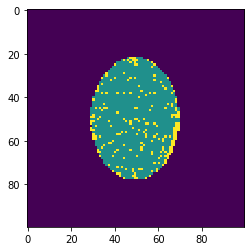

Edge-Loc


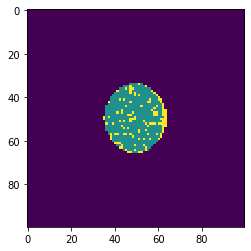

Scratch


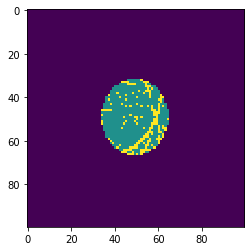

Edge-Loc


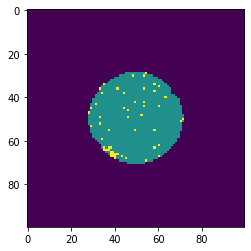

Edge-Loc


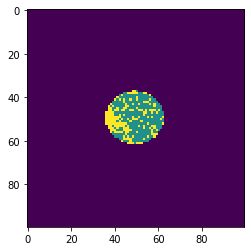

Scratch


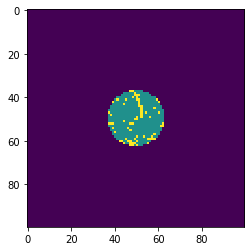

Donut


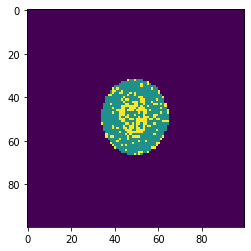

Donut


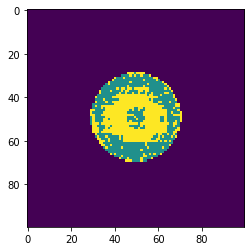

none


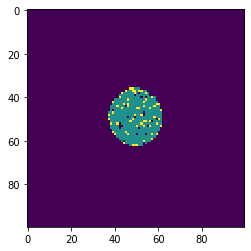

Edge-Ring


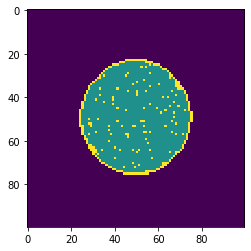

Near-full


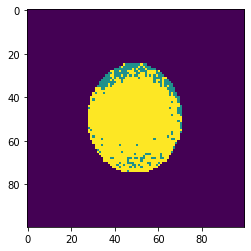

none


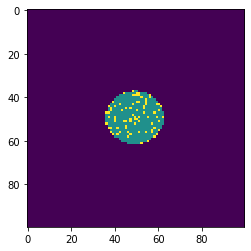

none


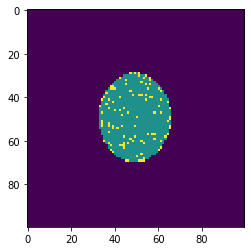

Edge-Ring


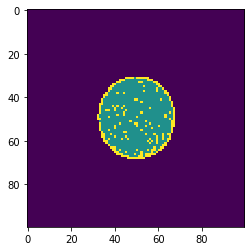

Near-full


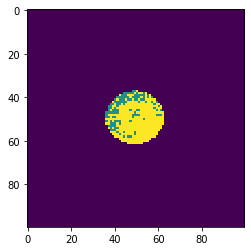

Center


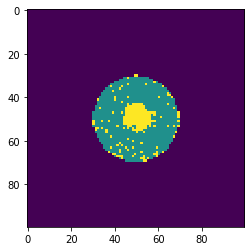

Random


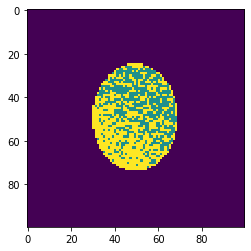

Scratch


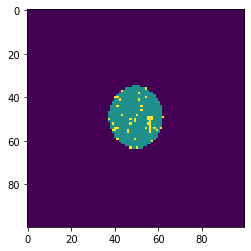

Random


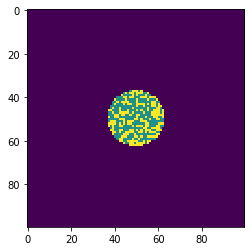

Near-full


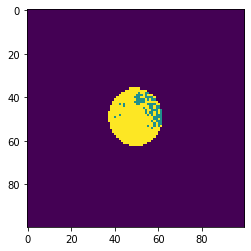

Loc


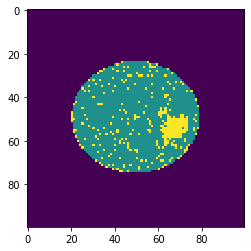

Random


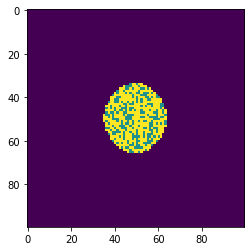

Random


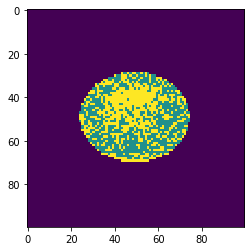

Edge-Ring


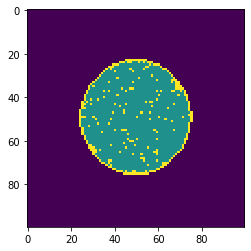

Edge-Loc


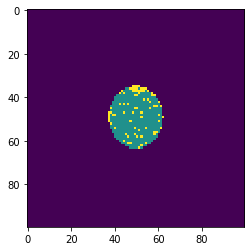

Center


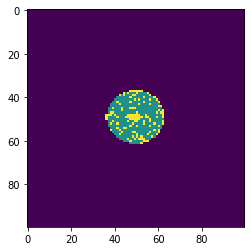

Loc


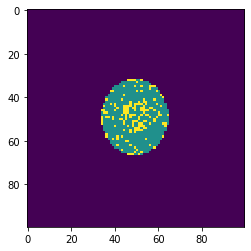

Random


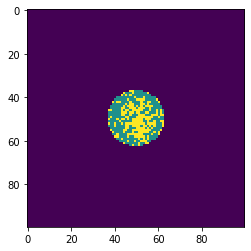

Loc


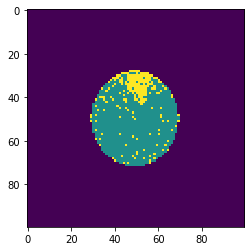

none


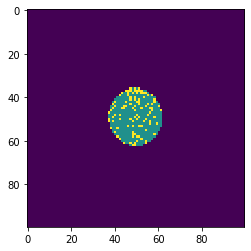

Edge-Ring


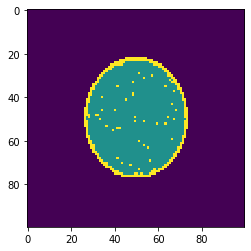

Random


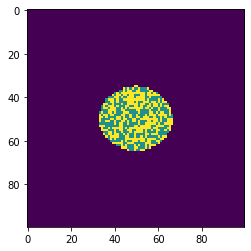

Loc


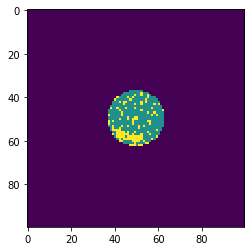

Near-full


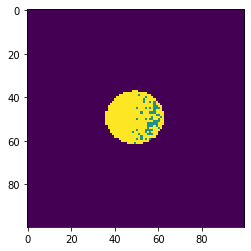

Donut


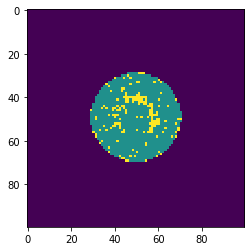

Loc


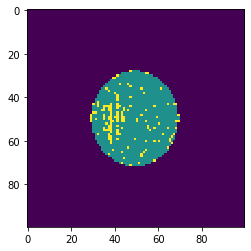

Center


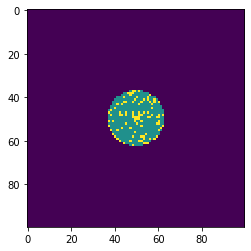

Edge-Ring


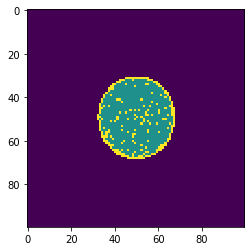

Edge-Ring


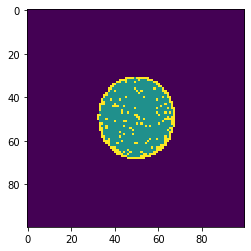

Edge-Ring


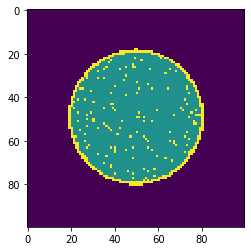

Edge-Ring


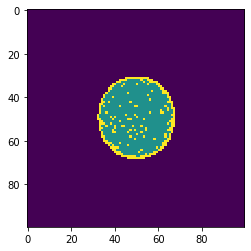

Edge-Ring


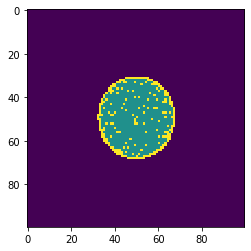

Edge-Loc


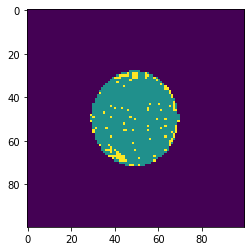

Donut


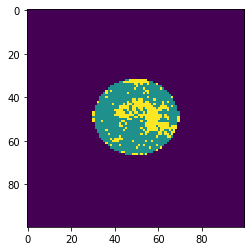

Edge-Ring


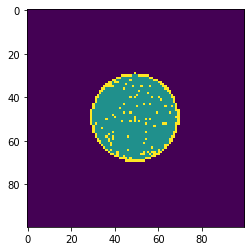

Random


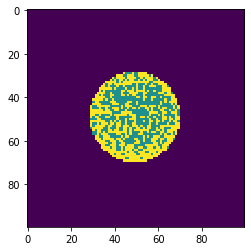

Center


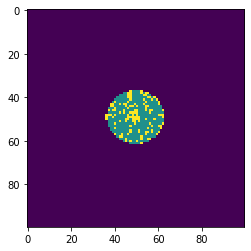

Edge-Ring


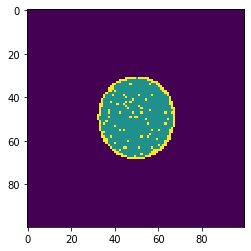

none


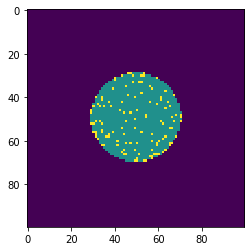

Loc


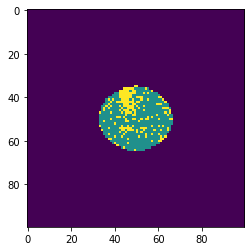

Loc


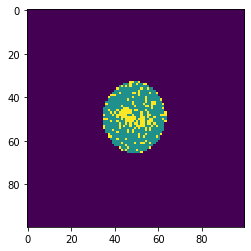

Scratch


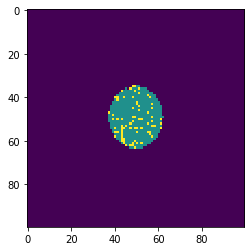

Loc


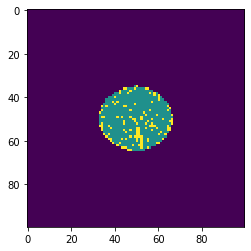

Near-full


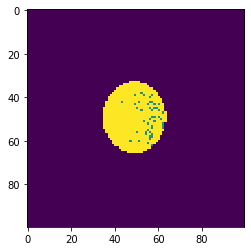

Random


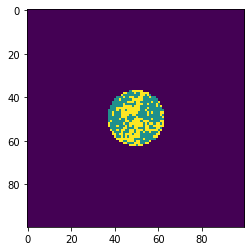

Edge-Loc


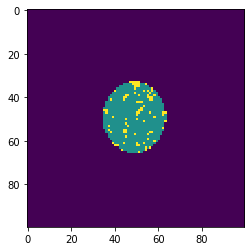

Donut


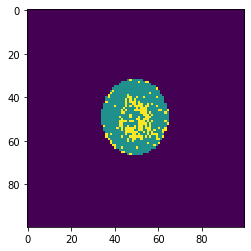

Loc


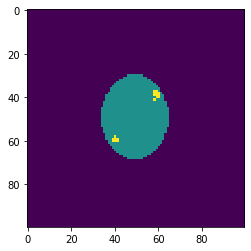

Center


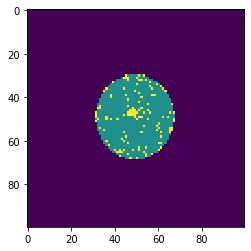

Edge-Ring


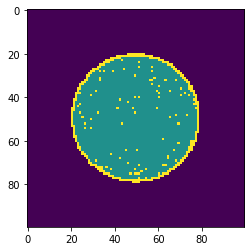

Near-full


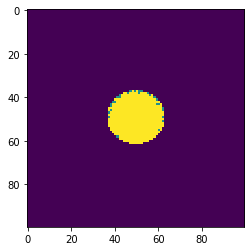

Near-full


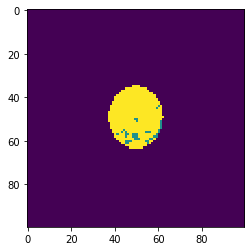

Near-full


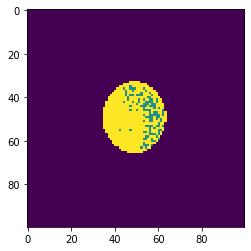

Center


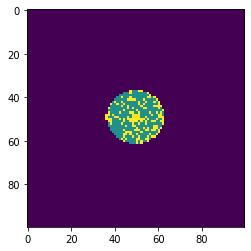

Near-full


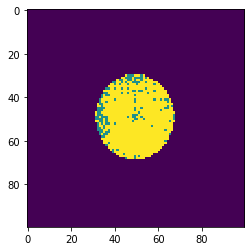

Edge-Ring


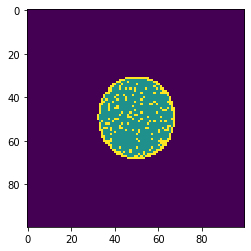

Donut


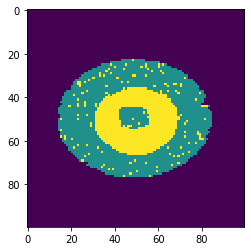

Center


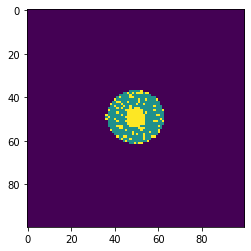

Center


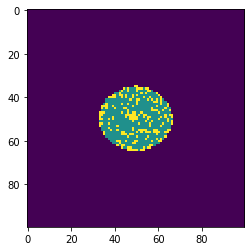

Edge-Loc


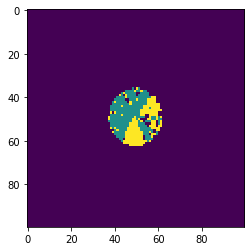

Center


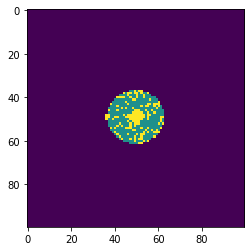

Donut


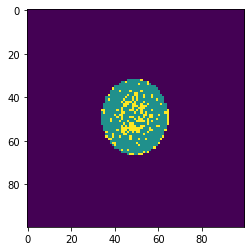

Loc


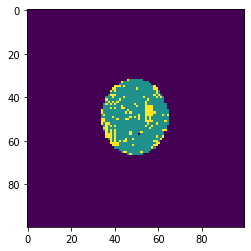

Random


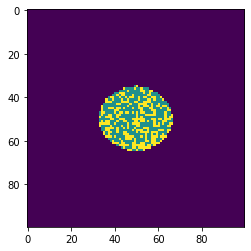

Edge-Loc


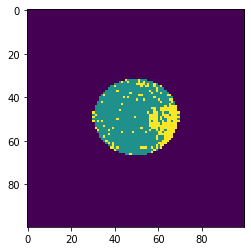

Random


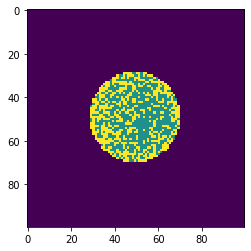

Edge-Ring


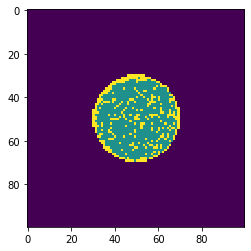

Edge-Loc


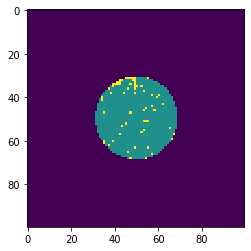

Random


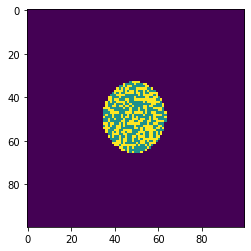

none


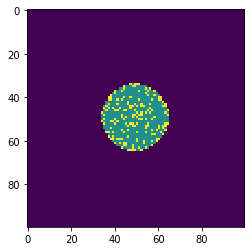

Donut


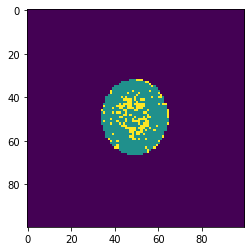

none


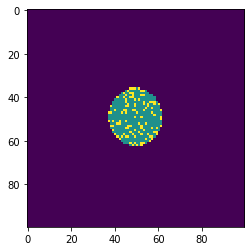

Loc


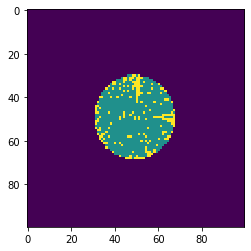

Edge-Ring


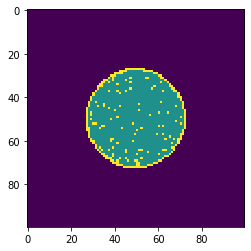

Donut


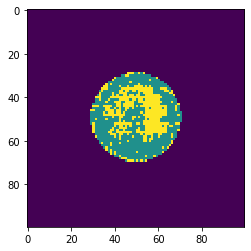

Center


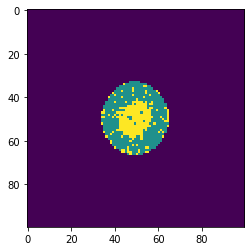

Edge-Ring


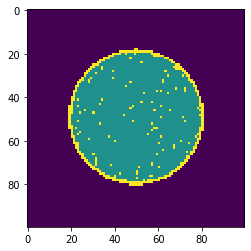

Edge-Loc


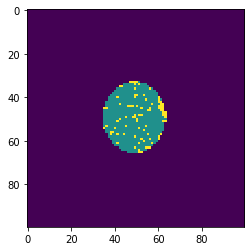

none


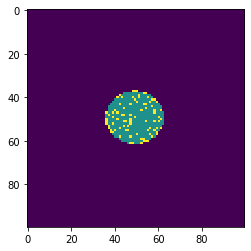

Edge-Loc


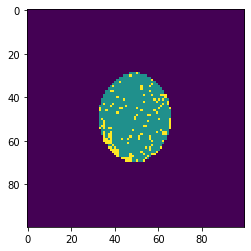

Edge-Ring


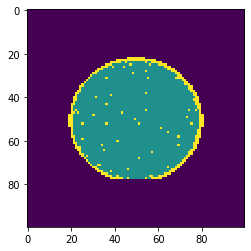

Scratch


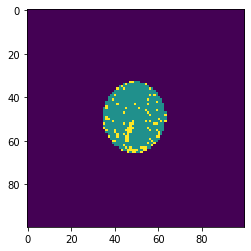

Center


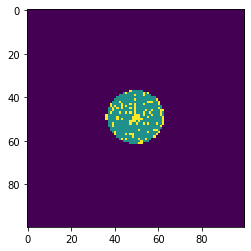

Edge-Ring


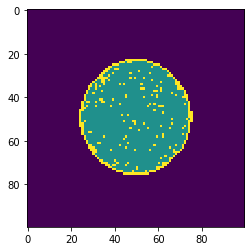

Center


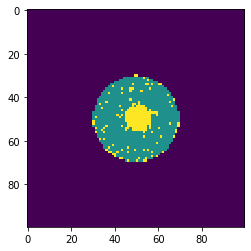

Near-full


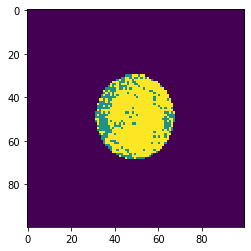

Center


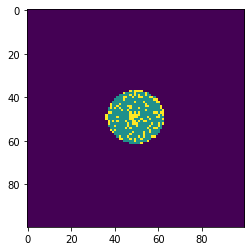

Near-full


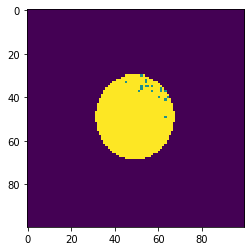

Scratch


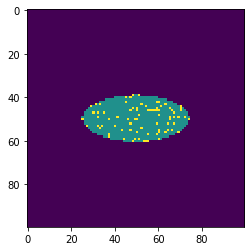

Near-full


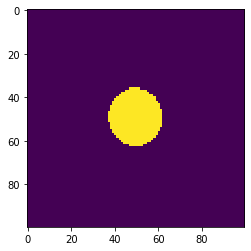

Edge-Ring


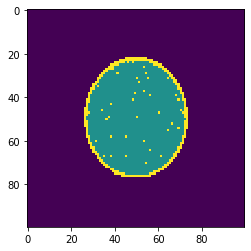

Edge-Loc


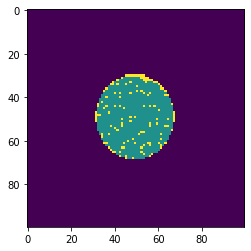

Center


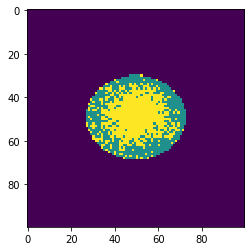

Near-full


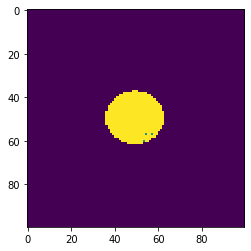

none


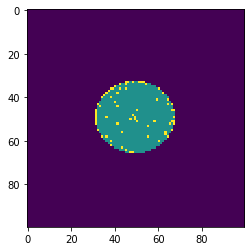

Random


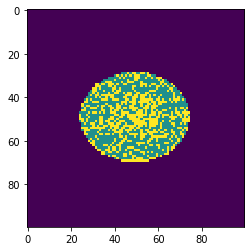

Center


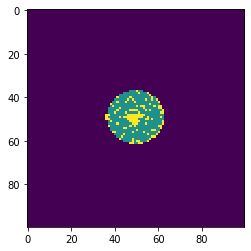

Edge-Loc


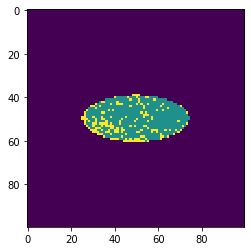

Center


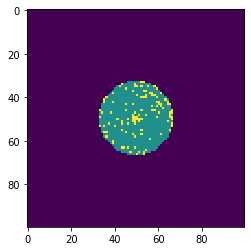

Loc


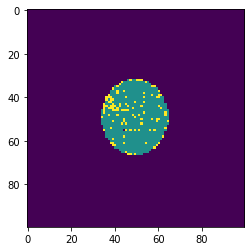

Loc


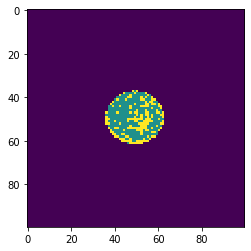

Donut


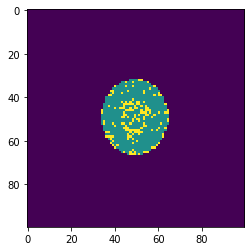

Donut


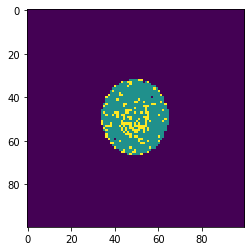

Center


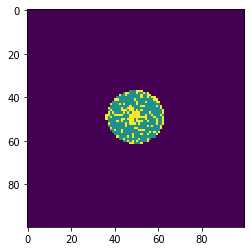

Loc


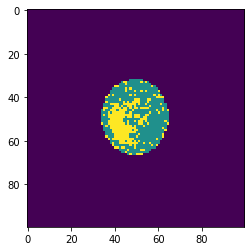

Scratch


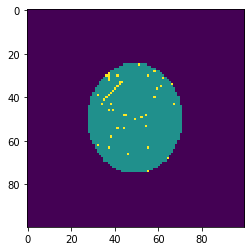

Center


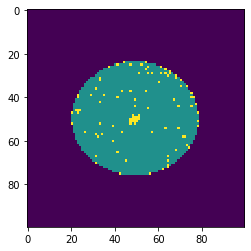

Center


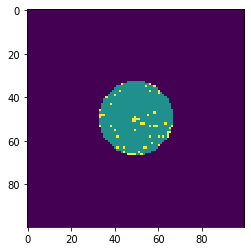

Donut


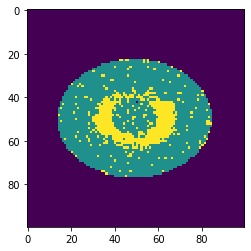

Edge-Ring


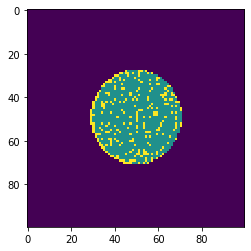

Donut


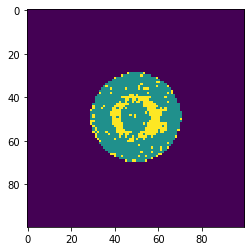

Scratch


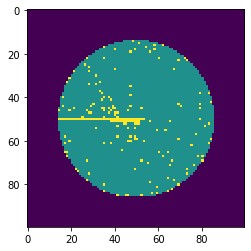

Scratch


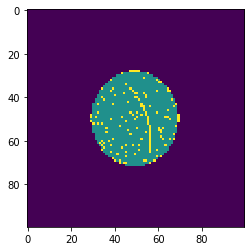

Center


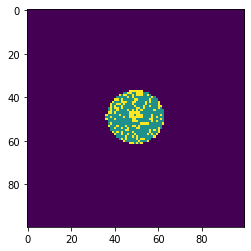

Edge-Ring


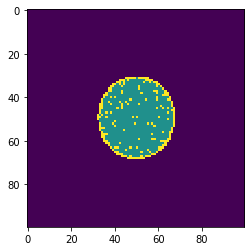

Random


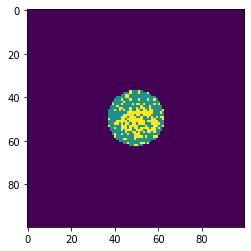

Donut


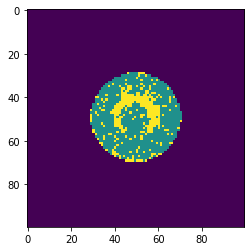

Edge-Loc


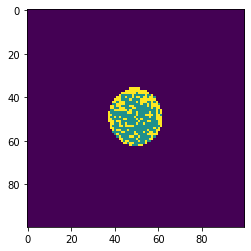

Edge-Ring


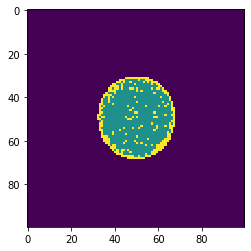

Loc


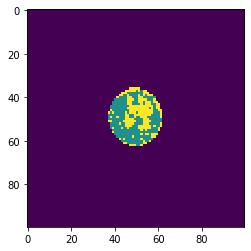

Edge-Loc


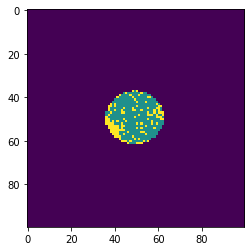

Edge-Ring


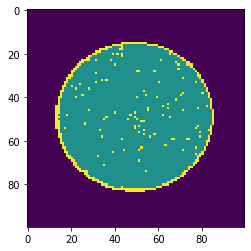

none


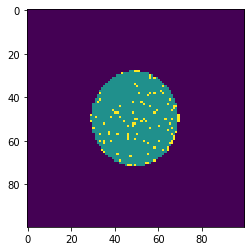

Center


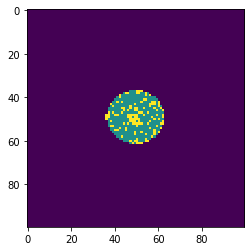

Edge-Ring


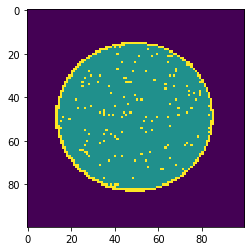

Random


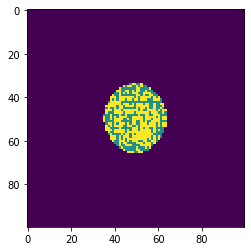

none


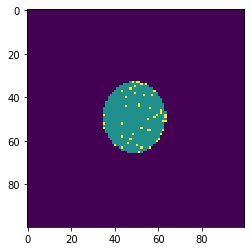

Edge-Loc


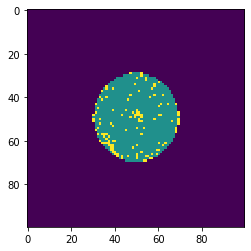

Edge-Loc


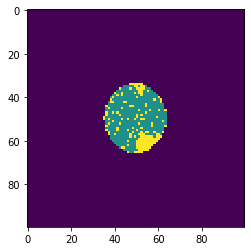

Loc


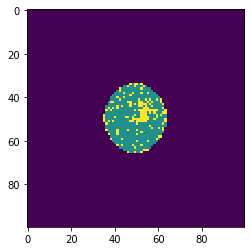

Edge-Ring


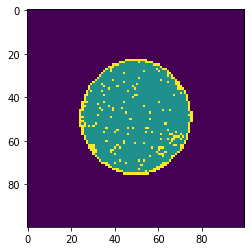

none


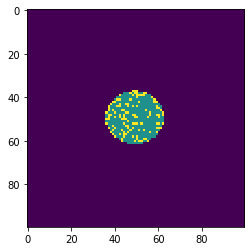

Scratch


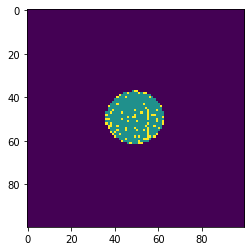

Loc


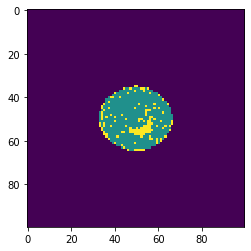

Edge-Loc


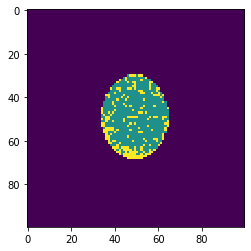

Donut


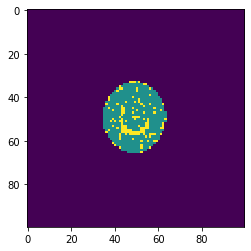

Loc


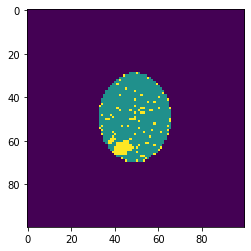

Scratch


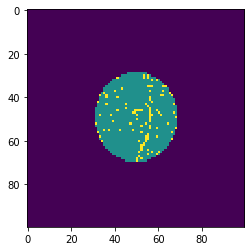

Scratch


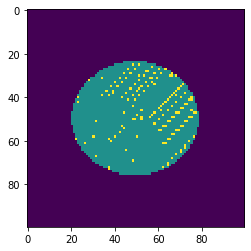

Loc


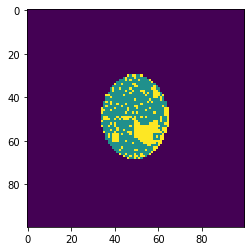

Edge-Ring


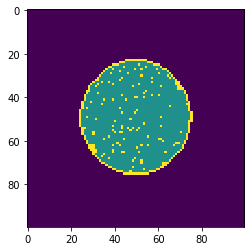

none


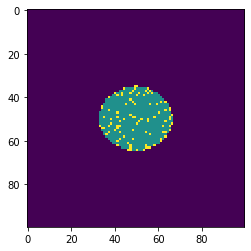

Loc


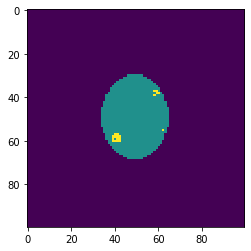

Near-full


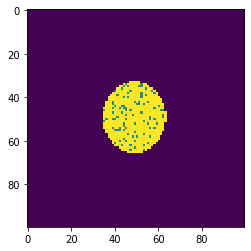

Scratch


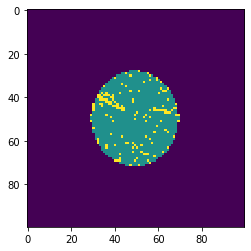

Random


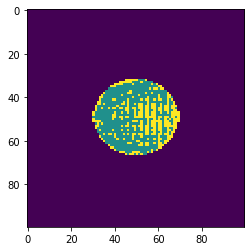

Loc


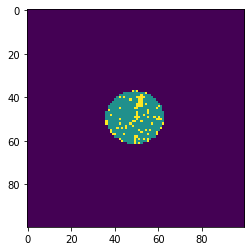

Random


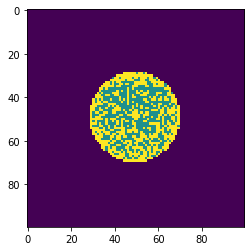

Scratch


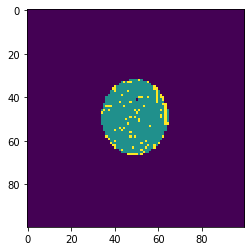

Center


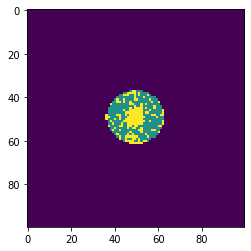

Loc


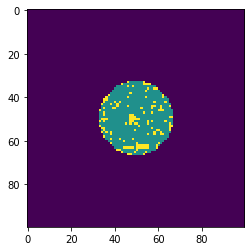

Donut


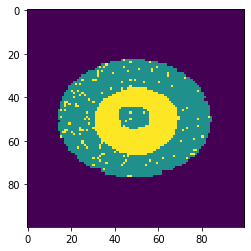

Center


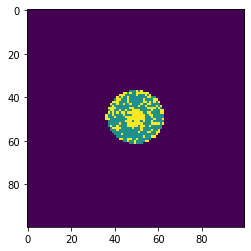

Scratch


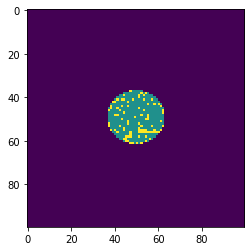

Near-full


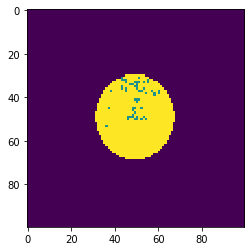

Scratch


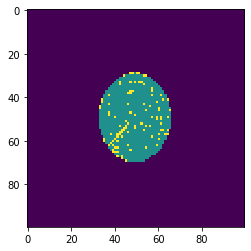

Edge-Ring


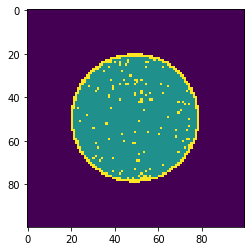

Random


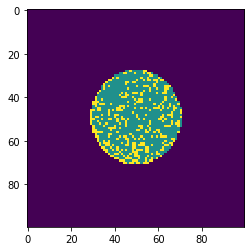

Random


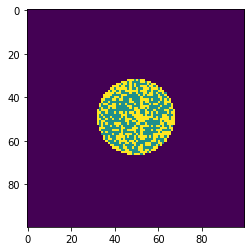

none


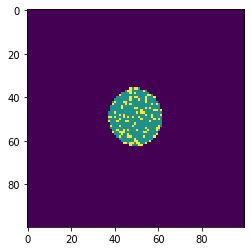

Center


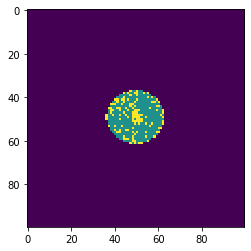

Edge-Loc


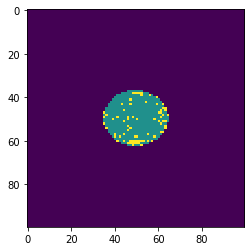

Random


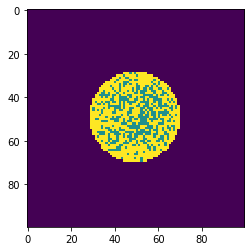

Edge-Loc


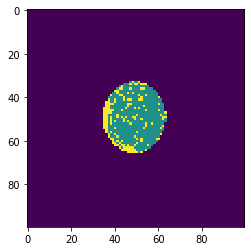

Random


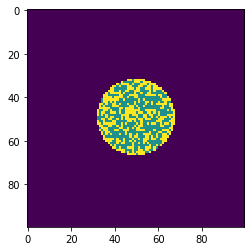

Edge-Loc


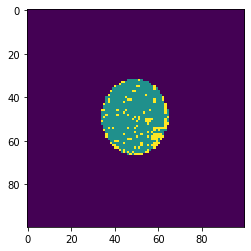

Loc


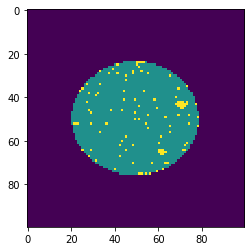

Donut


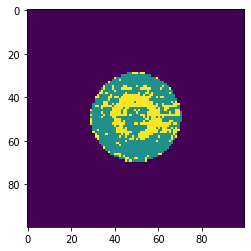

Donut


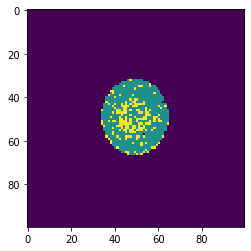

Edge-Loc


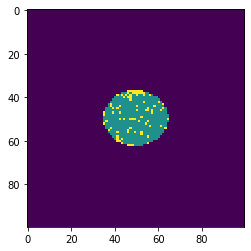

Center


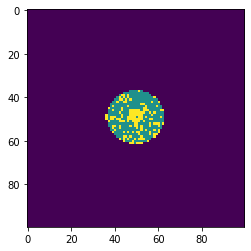

Near-full


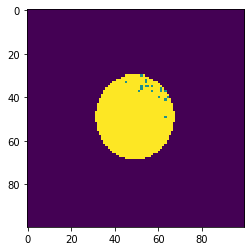

Donut


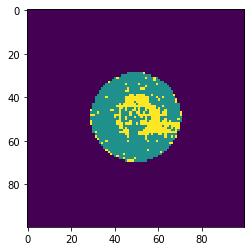

Random


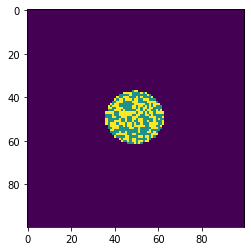

Random


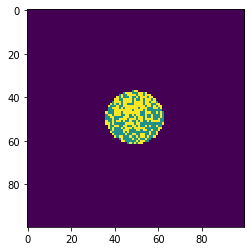

none


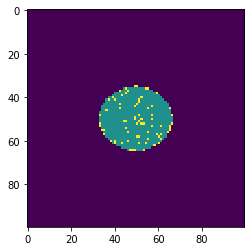

Scratch


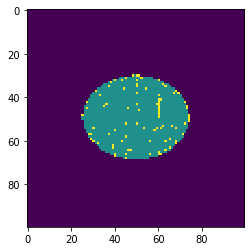

Scratch


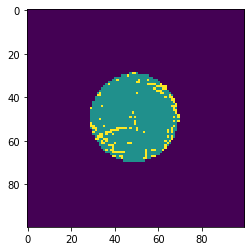

Loc


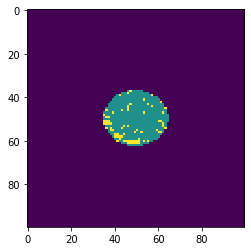

Edge-Loc


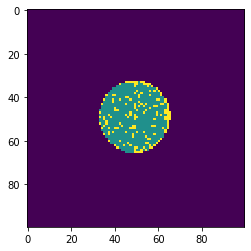

Scratch


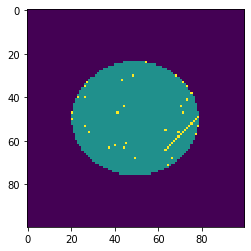

Edge-Ring


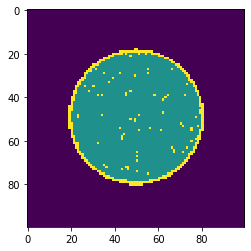

Near-full


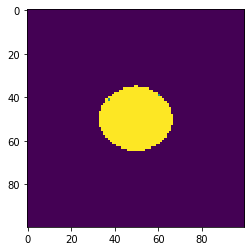

none


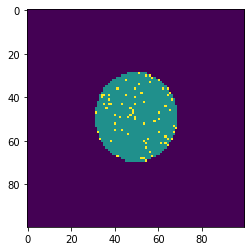

Edge-Loc


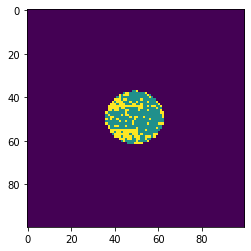

Edge-Loc


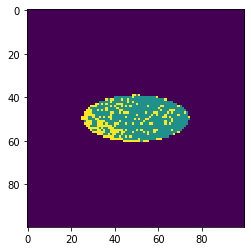

none


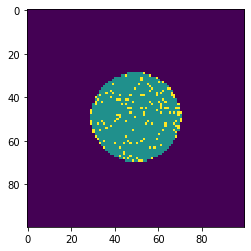

Scratch


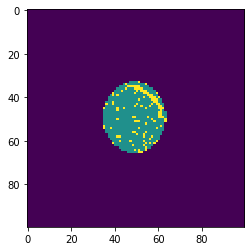

Donut


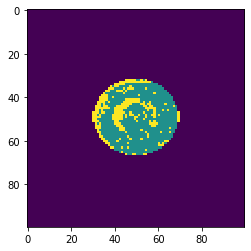

Center


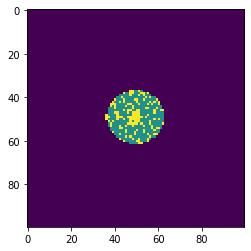

Edge-Ring


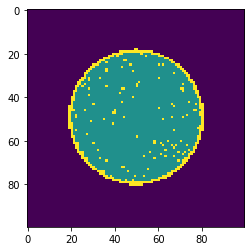

none


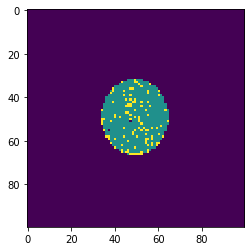

Center


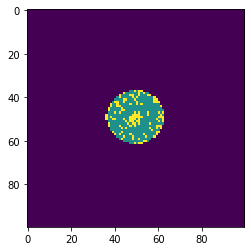

Scratch


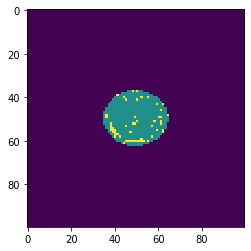

Edge-Ring


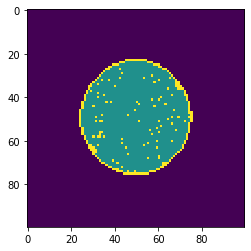

Edge-Loc


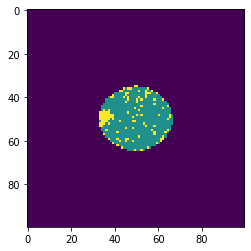

Donut


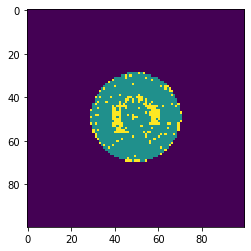

none


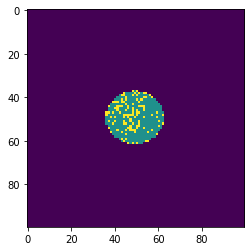

Edge-Loc


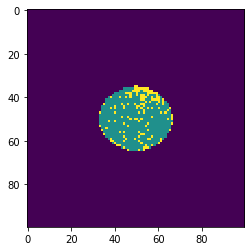

Donut


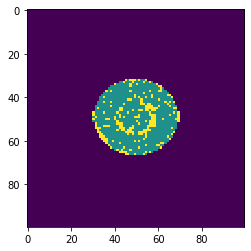

Donut


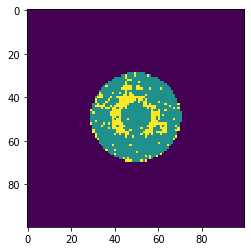

Loc


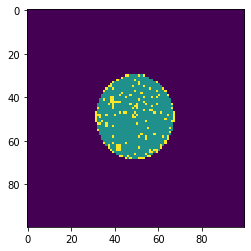

Random


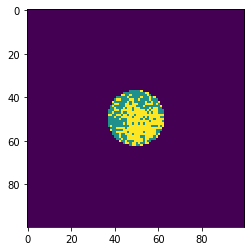

Donut


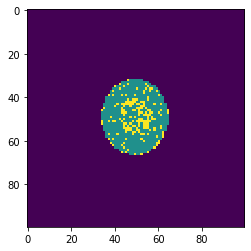

Edge-Loc


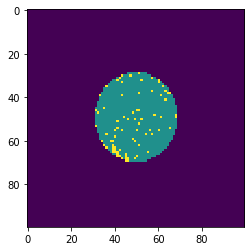

Edge-Ring


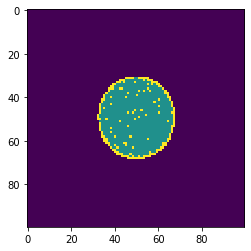

Scratch


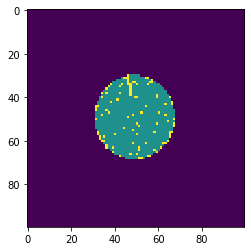

Loc


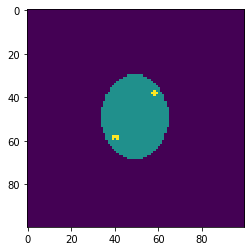

Donut


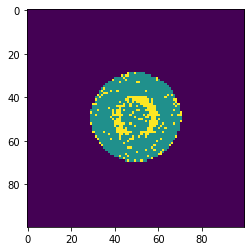

Center


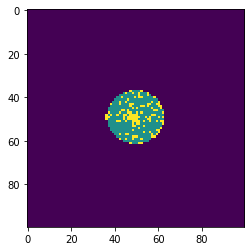

Edge-Loc


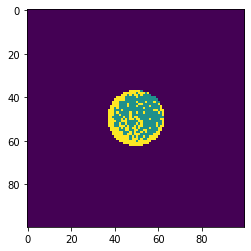

none


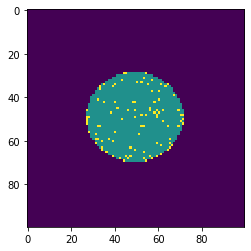

Edge-Ring


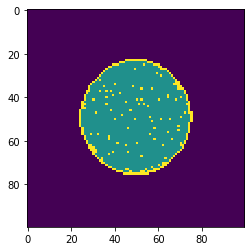

Random


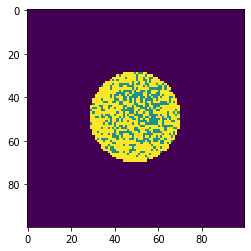

Scratch


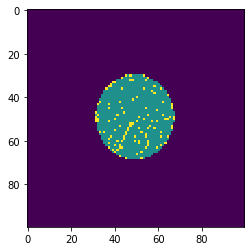

none


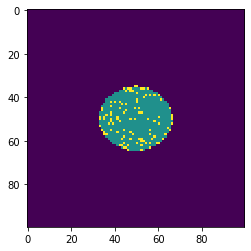

Loc


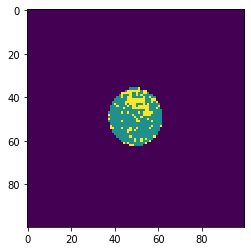

Near-full


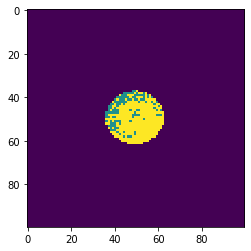

Center


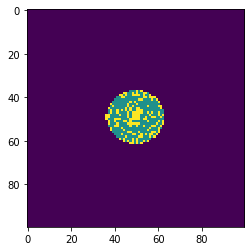

none


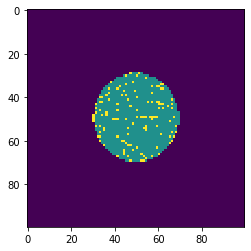

Scratch


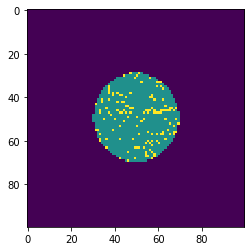

none


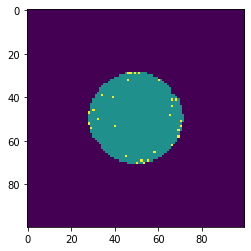

Loc


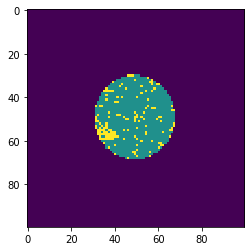

Edge-Loc


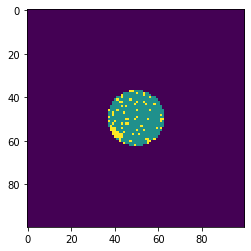

Near-full


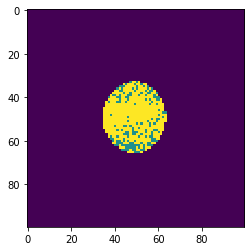

Random


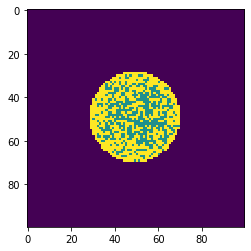

Donut


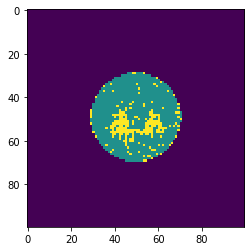

Edge-Ring


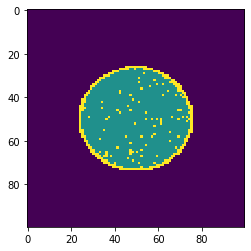

Random


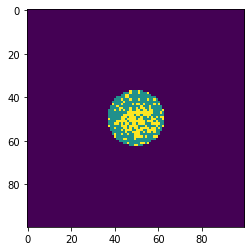

none


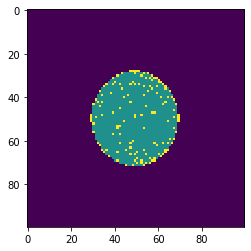

Edge-Ring


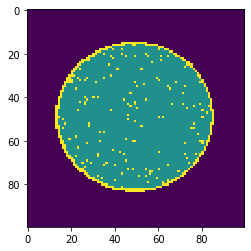

none


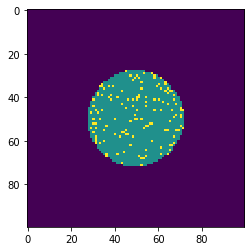

Edge-Loc


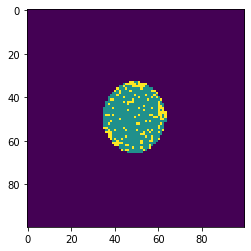

Donut


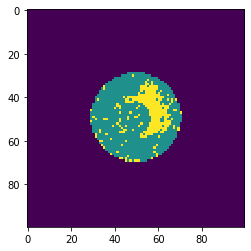

Center


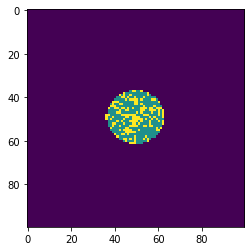

Near-full


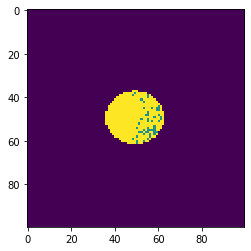

Random


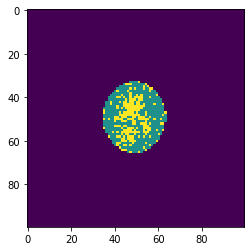

Scratch


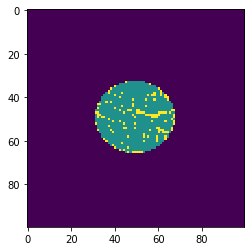

Random


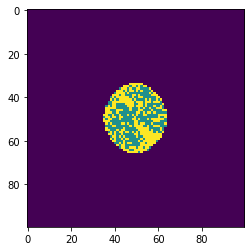

Edge-Ring


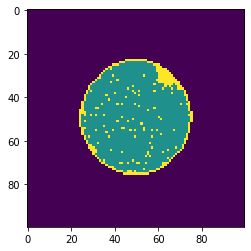

Donut


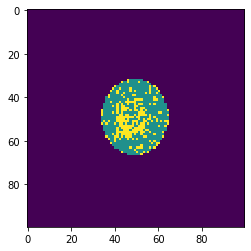

Edge-Ring


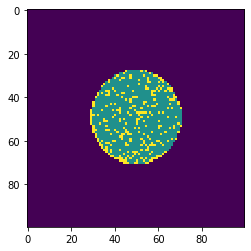

none


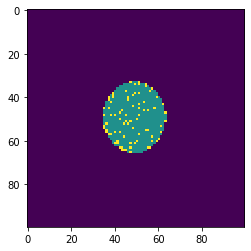

none


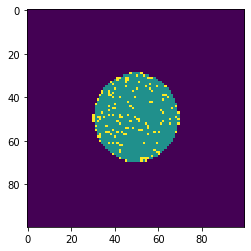

Scratch


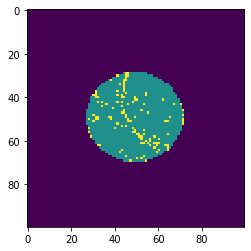

Edge-Loc


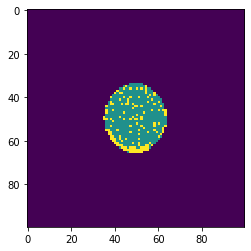

Center


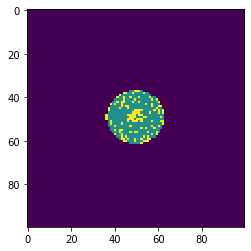

Scratch


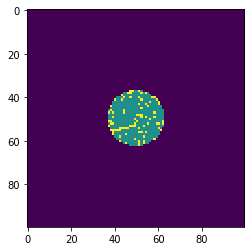

none


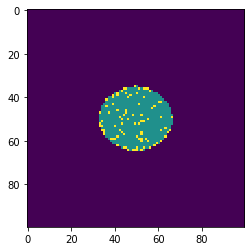

none


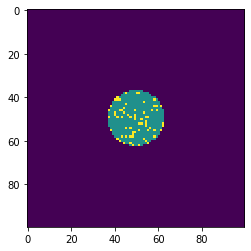

Loc


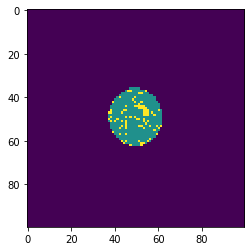

Edge-Ring


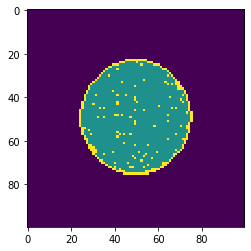

none


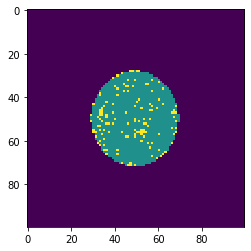

Edge-Ring


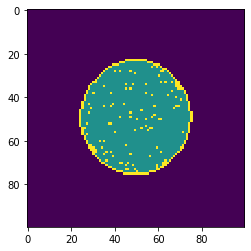

Edge-Ring


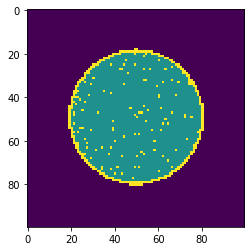

none


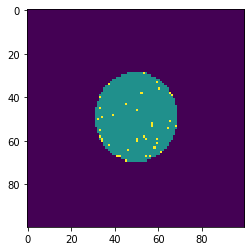

Loc


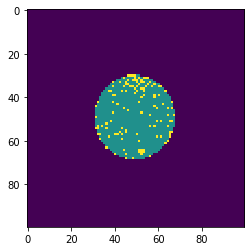

Scratch


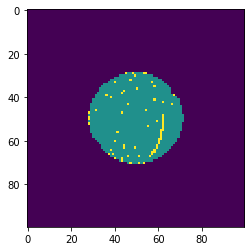

Donut


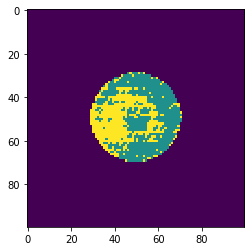

none


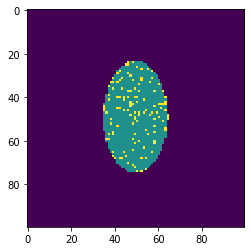

Loc


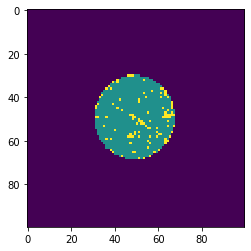

none


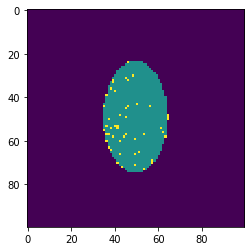

Edge-Ring


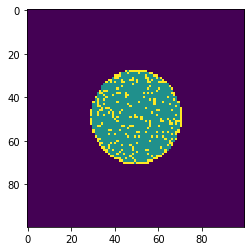

none


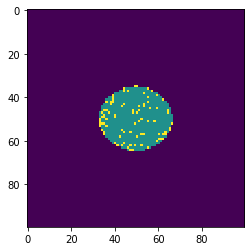

none


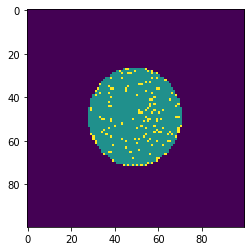

Loc


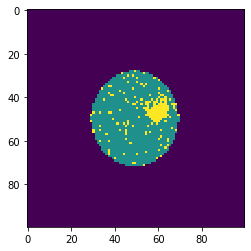

Edge-Ring


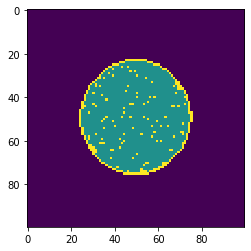

Center


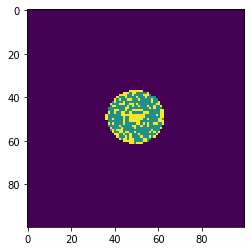

Center


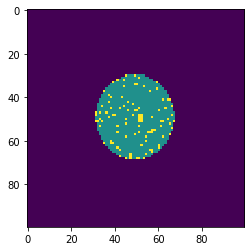

Edge-Ring


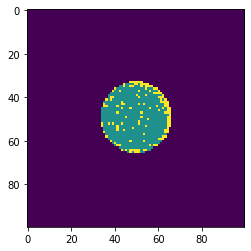

Edge-Ring


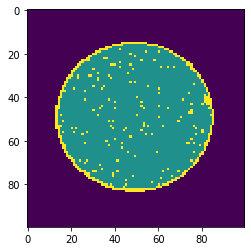

Edge-Loc


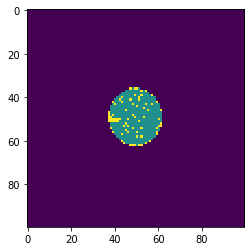

Near-full


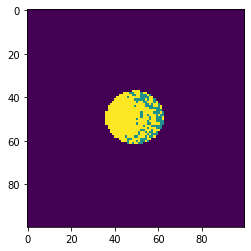

Near-full


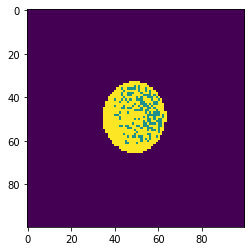

Edge-Ring


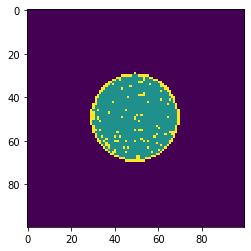

Loc


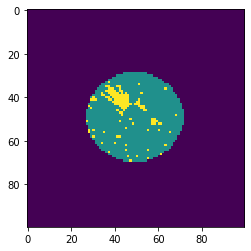

Edge-Ring


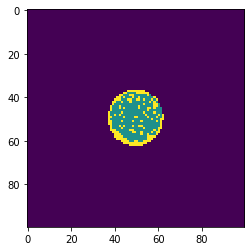

Edge-Loc


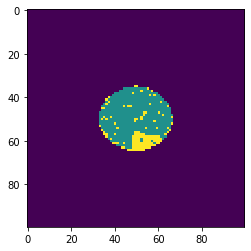

Center


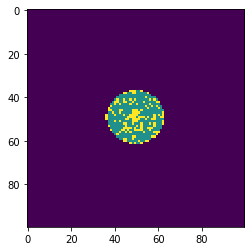

none


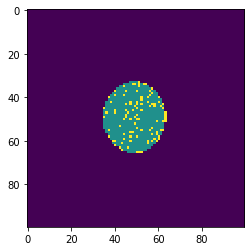

Edge-Loc


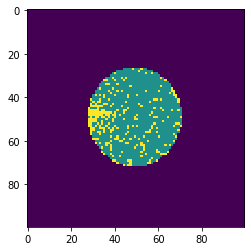

Edge-Ring


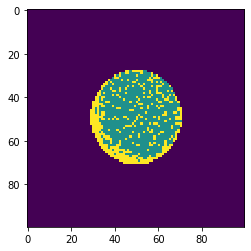

Scratch


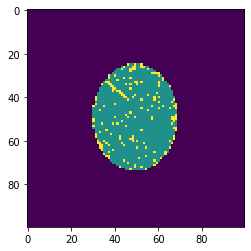

Edge-Ring


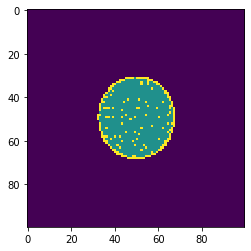

Loc


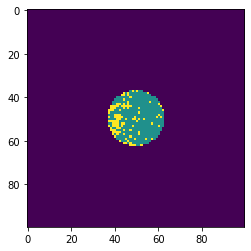

Loc


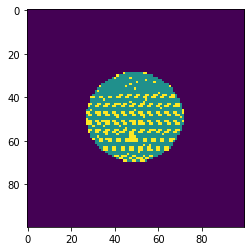

Near-full


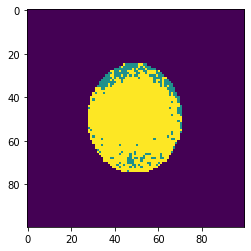

Edge-Loc


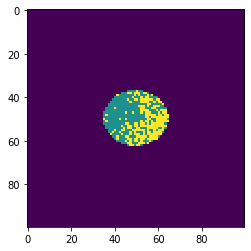

Random


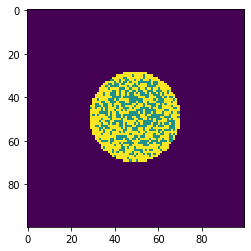

Edge-Ring


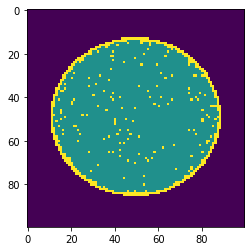

Edge-Ring


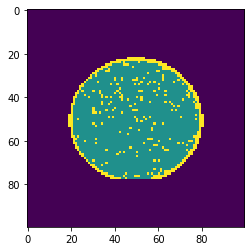

Scratch


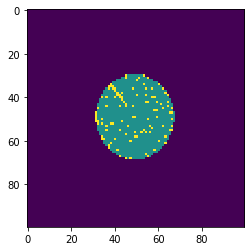

Edge-Loc


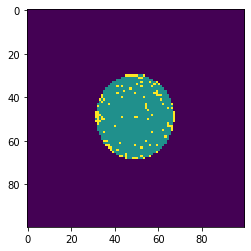

Edge-Ring


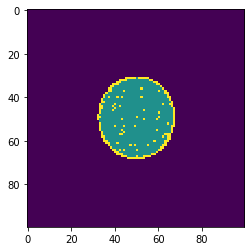

Scratch


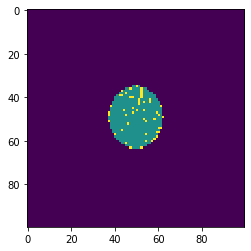

Scratch


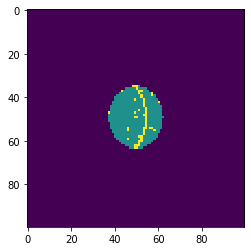

Edge-Ring


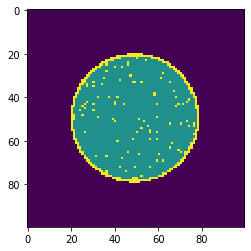

Center


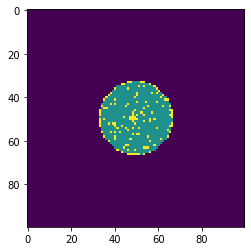

Edge-Ring


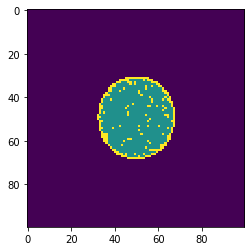

Edge-Loc


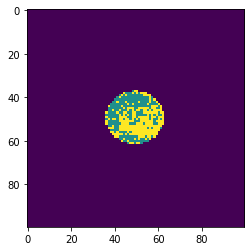

Random


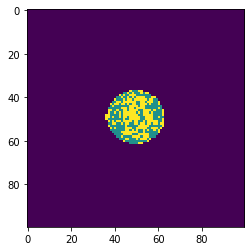

none


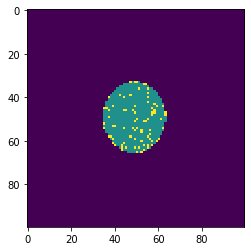

none


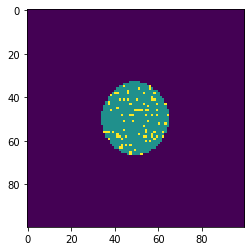

Random


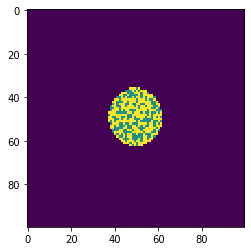

Random


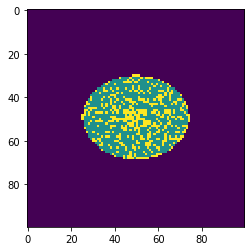

none


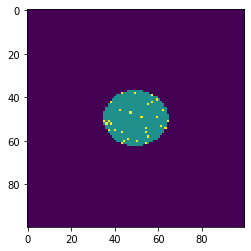

Random


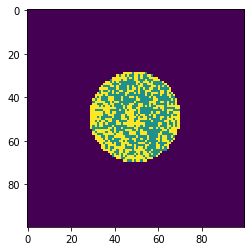

Near-full


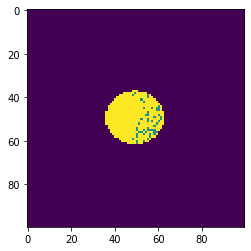

Edge-Ring


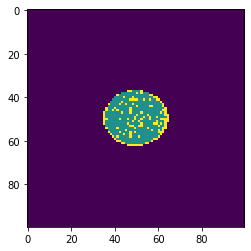

Random


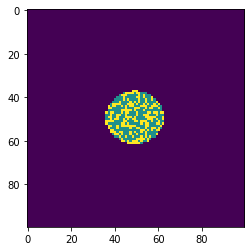

Random


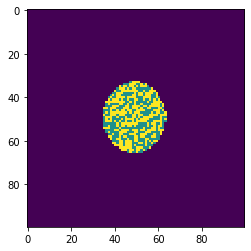

Donut


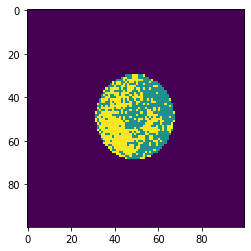

Edge-Loc


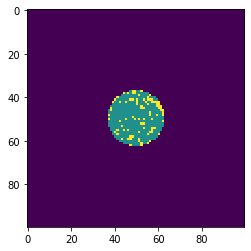

Random


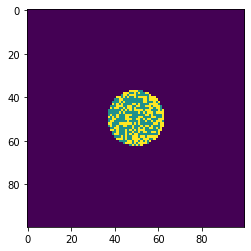

Center


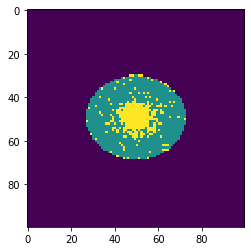

Center


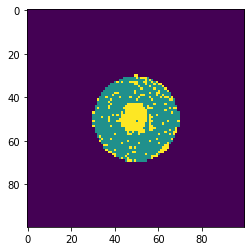

none


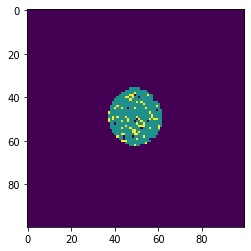

Center


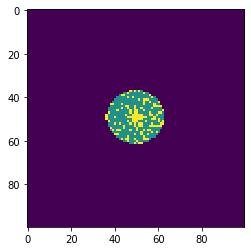

Random


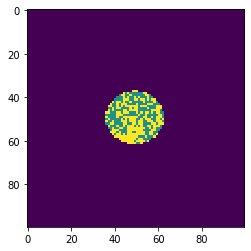

none


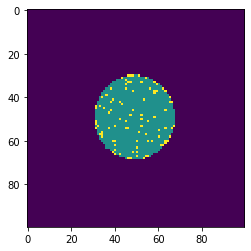

Scratch


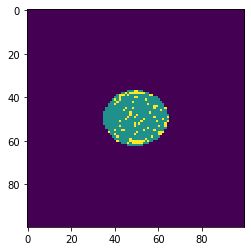

Edge-Ring


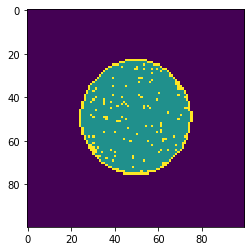

Edge-Loc


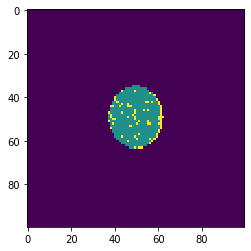

Scratch


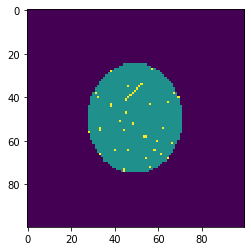

Edge-Ring


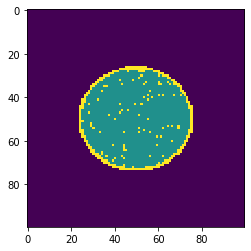

none


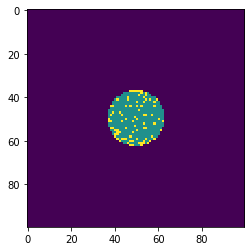

Edge-Ring


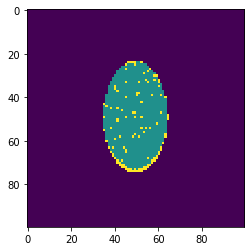

Near-full


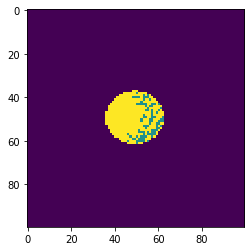

Near-full


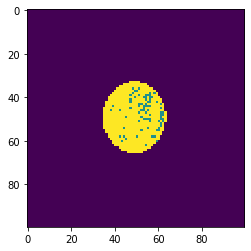

Random


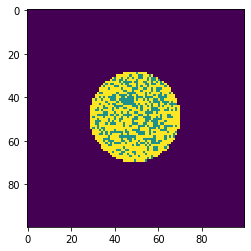

Edge-Ring


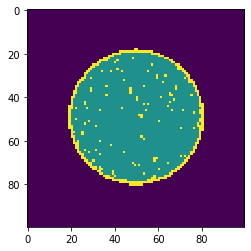

Donut


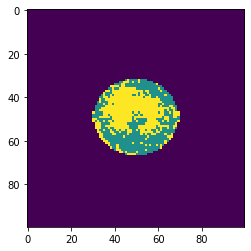

Random


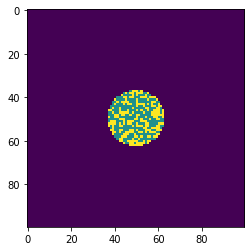

Edge-Ring


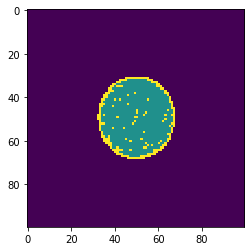

Edge-Ring


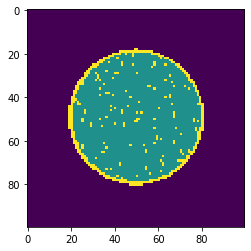

Edge-Ring


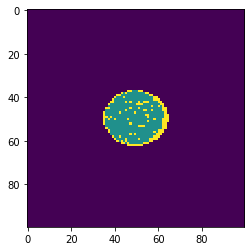

Donut


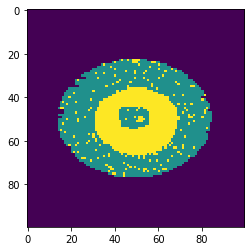

none


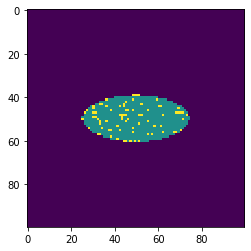

Edge-Loc


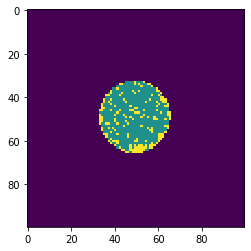

none


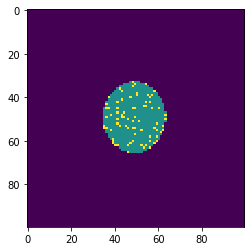

Near-full


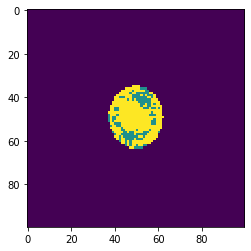

Loc


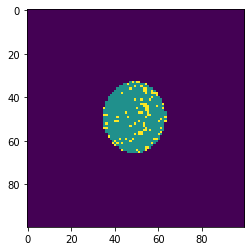

none


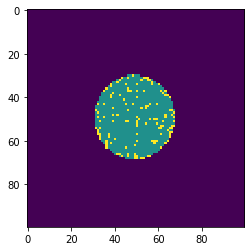

Edge-Loc


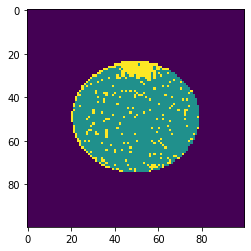

Edge-Loc


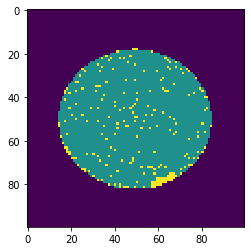

Edge-Ring


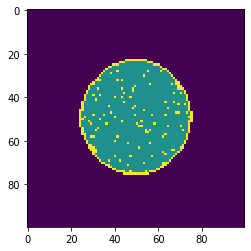

Edge-Ring


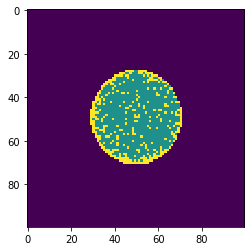

Scratch


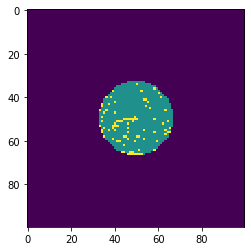

Near-full


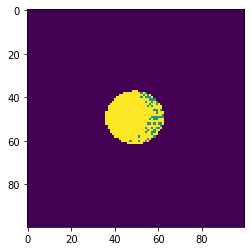

Donut


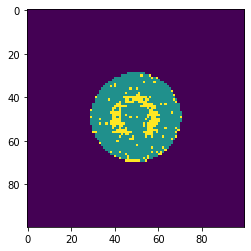

Edge-Ring


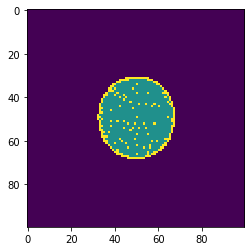

Donut


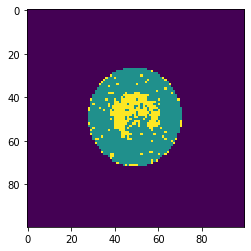

Scratch


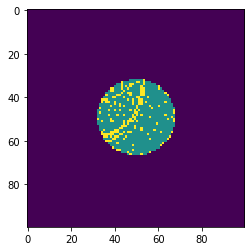

Loc


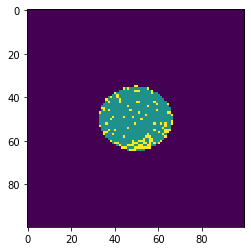

Loc


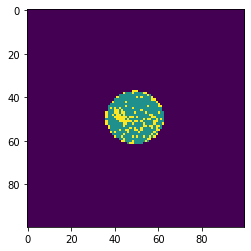

Loc


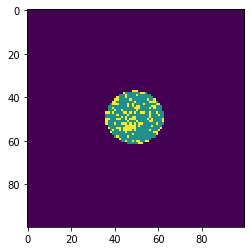

Near-full


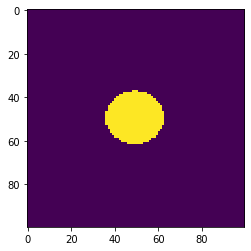

Center


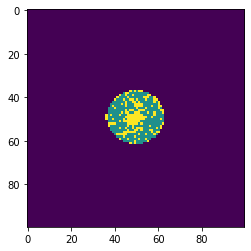

Edge-Loc


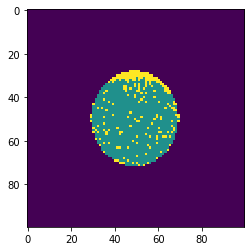

none


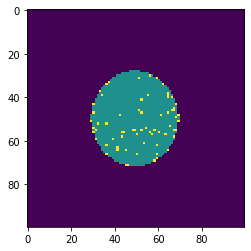

Near-full


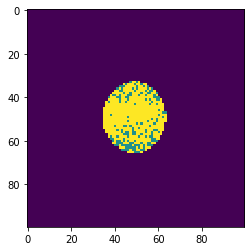

Edge-Ring


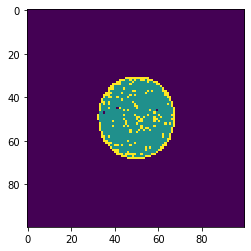

Edge-Loc


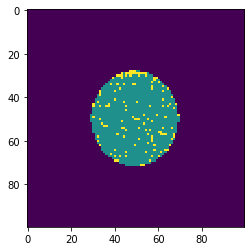

Loc


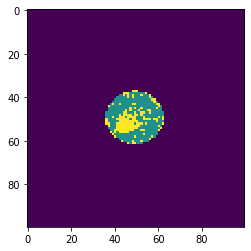

Edge-Ring


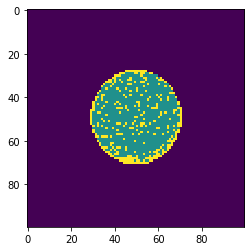

Center


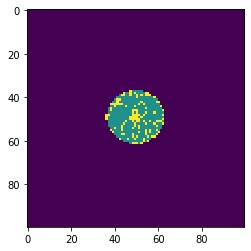

Edge-Ring


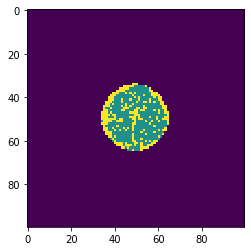

Edge-Ring


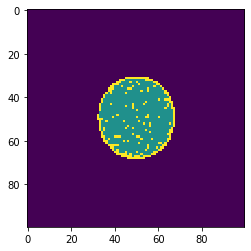

Scratch


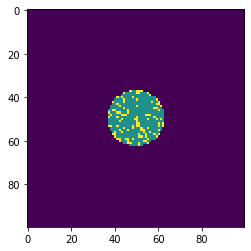

Random


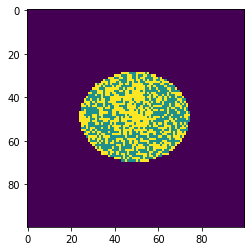

none


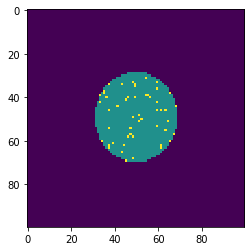

Scratch


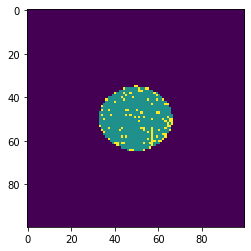

Loc


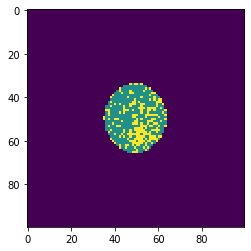

Random


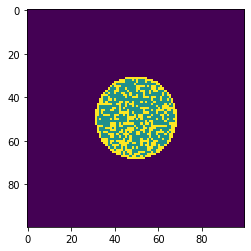

Center


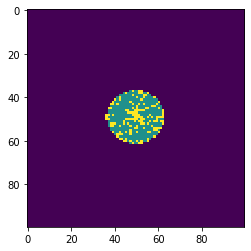

Edge-Ring


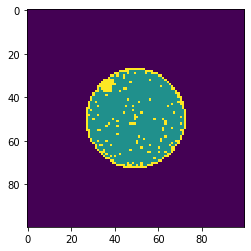

Near-full


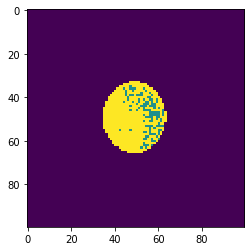

none


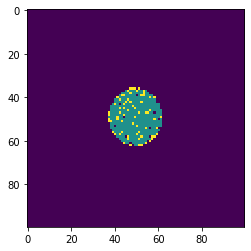

Center


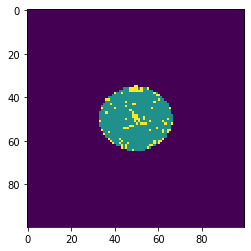

Scratch


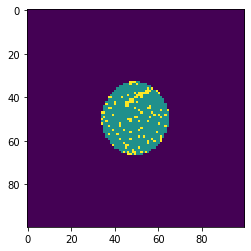

Donut


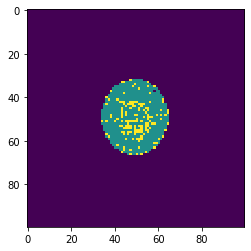

Edge-Ring


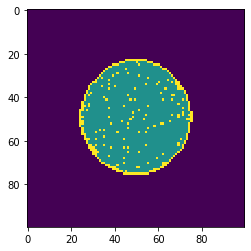

Donut


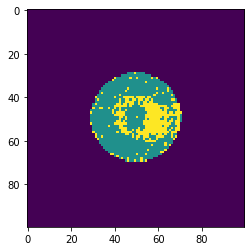

none


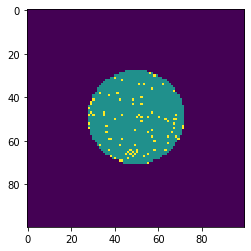

none


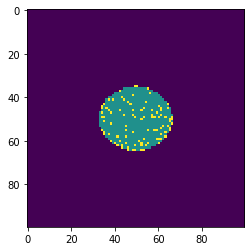

Edge-Loc


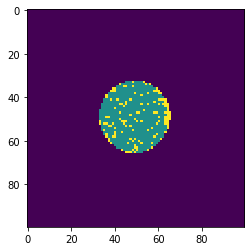

Edge-Loc


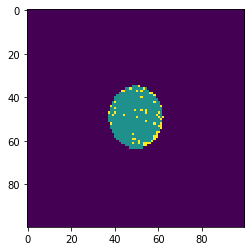

Loc


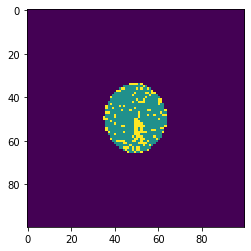

Scratch


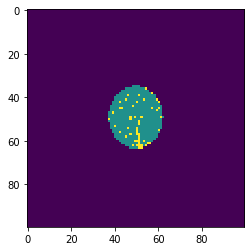

Donut


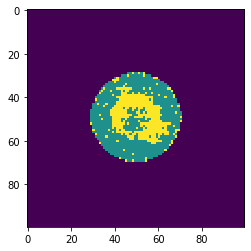

Donut


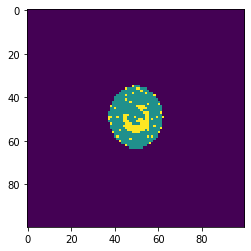

Random


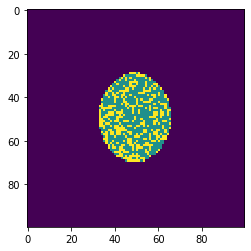

Edge-Loc


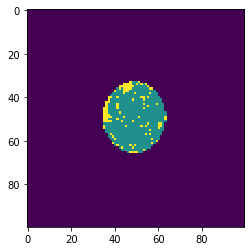

Edge-Loc


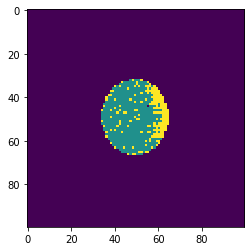

Edge-Ring


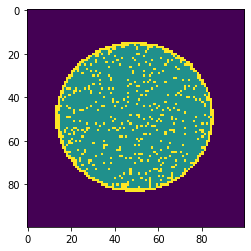

Donut


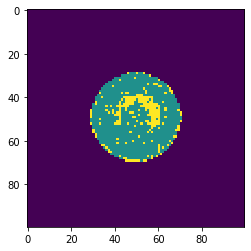

Center


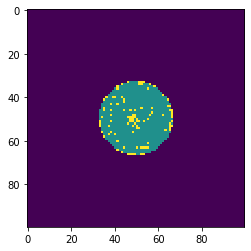

Edge-Ring


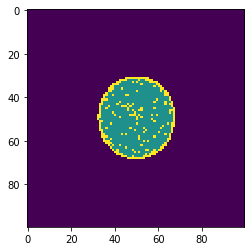

Near-full


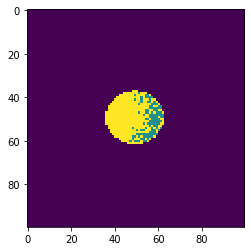

Donut


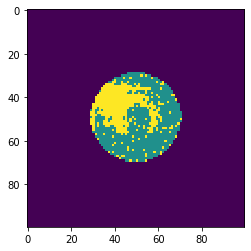

none


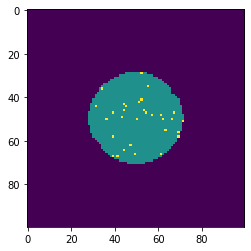

Edge-Ring


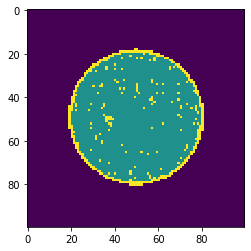

Edge-Loc


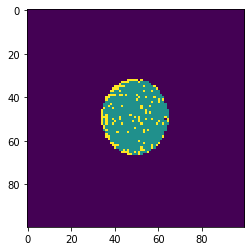

Center


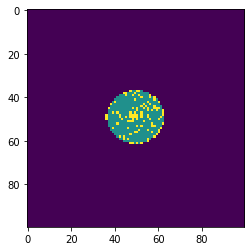

Center


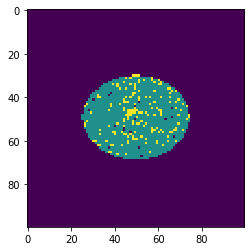

Random


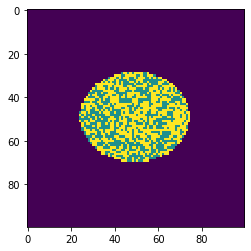

Edge-Ring


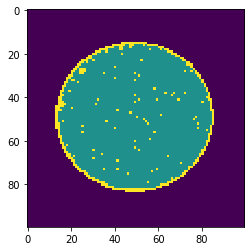

Edge-Loc


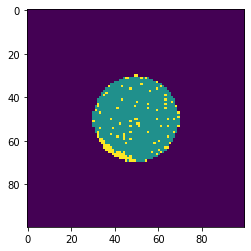

Random


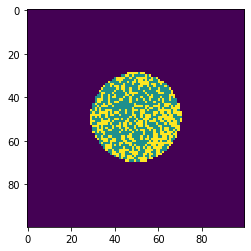

Loc


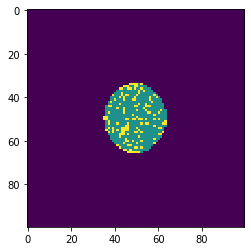

Random


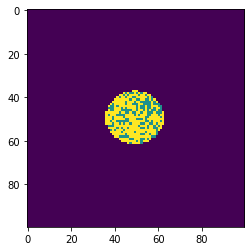

none


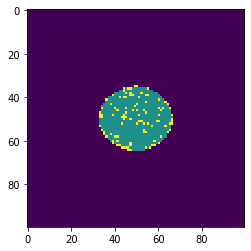

none


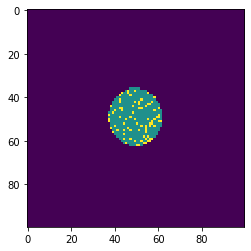

Scratch


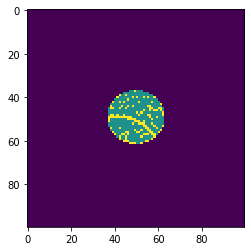

Random


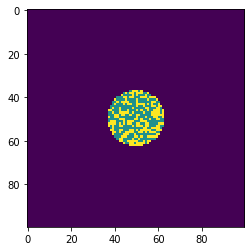

none


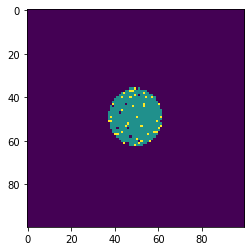

Scratch


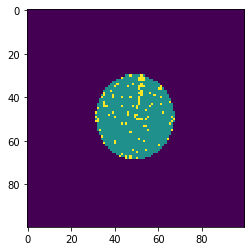

Edge-Loc


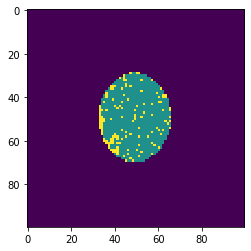

Edge-Ring


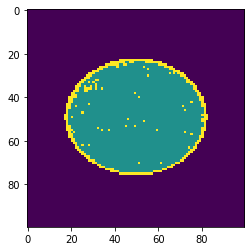

Edge-Ring


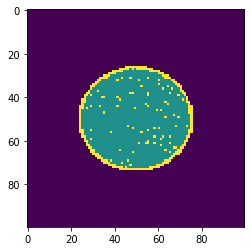

none


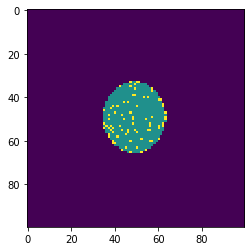

Edge-Ring


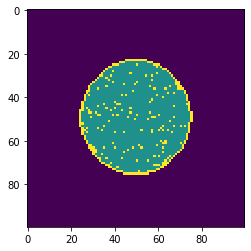

Edge-Loc


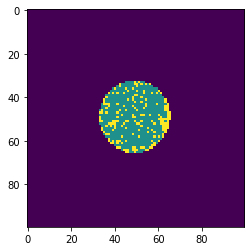

Edge-Ring


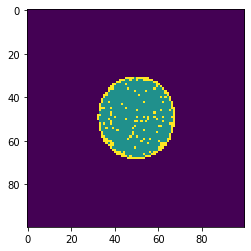

Edge-Ring


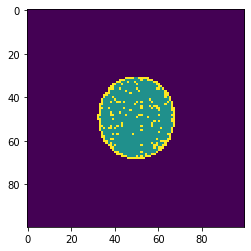

Random


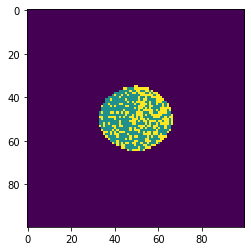

Scratch


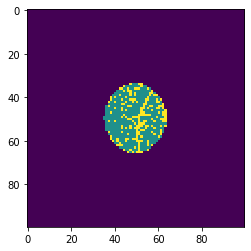

Donut


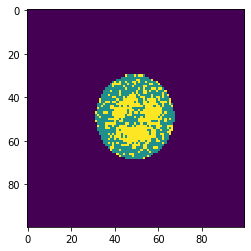

Random


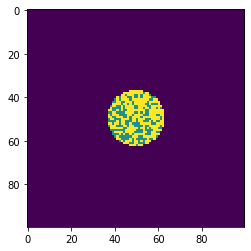

Edge-Loc


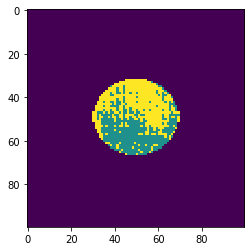

Loc


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [45]:
for i in range(x_train.shape[0]):
    print(faulty_case[np.argmax(y_train[i])])
    plt.imshow(np.argmax(x_train[i], axis=2))
    plt.show()

- 学習データ246635枚，テストデータ121477枚．

- モデルの定義を行う．

### CNN

In [18]:
def create_model():
    with tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], 
                                        cross_device_ops = tf.distribute.HierarchicalCopyAllReduce()).scope():
        input_shape = (max_size, max_size, 3)
        input_tensor = Input(input_shape)

        conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
        conv_2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv_1)
        conv_3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_2)

        flat = layers.Flatten()(conv_3)

        dense_1 = layers.Dense(256, activation='relu')(flat)
        dense_2 = layers.Dense(64, activation='relu')(dense_1)
        output_tensor = layers.Dense(9, activation='softmax')(dense_2)

        model = models.Model(input_tensor, output_tensor)
        model.compile(optimizer='Adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

    return model

- 3-Fold Cross validationで分割して学習する．

In [19]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "device:XLA_GPU:0"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))# model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=1) 
# # 3-Fold Crossvalidation
# kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
# # results = cross_val_score(model, x_train, y_train, cv=kfold)
# # # Check 3-fold model's mean accuracy
# # print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:XLA_GPU:0')
Number of devices: 3


- Cross validiationによる精度は99.55%であった．

- Cross validationなしで学習する．

In [20]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "device:XLA_GPU:0"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:XLA_GPU:0')
Number of devices: 3


In [21]:
epoch=10
batch_size=1024
random.seed(1)

In [ ]:
model = create_model()
epoch_train_loss = []
epoch_train_acc = []
epoch_validation_loss = []
epoch_validation_acc = []
for ep in range(epoch):
    print("=" * 50)
    print(ep, "/", epoch)
    step_loss = []
    step_acc = []
    
    # batch_size=1000でHDDからバッチを取得する
    for X_batch, Y_batch in get_batch(batch_size):
        model.train_on_batch(X_batch, Y_batch)
        score = model.evaluate(X_batch, Y_batch)
        print("batch loss:", score[0])
        print("batch accuracy:", score[1])
        step_loss.append(score[0])
        step_acc.append(score[1])
    print("Train loss", np.mean(step_loss))
    print("Train accuracy", np.mean(step_acc))
    score = model.evaluate(x_validation, y_validation)
    print("Validation loss:", score[0])
    print("Validation accuracy:", score[1])
    epoch_train_loss.append(np.mean(step_loss))
    epoch_train_acc.append(np.mean(step_acc))
    epoch_validation_loss.append(score[0])
    epoch_validation_acc.append(score[1])
    
    shuffle_indices = random.sample(list(range(len(x_train))), len(x_train))
    x_train = [x_train[i] for i in shuffle_indices]
    y_train = y_train[shuffle_indices]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
0 / 10
doing 0 / 286
elapsed time 70.01804447174072
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/

In [108]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|       ImageDataGenerator|      1064|
|                       In|      1080|
|                    Input|       144|
|                    KFold|      1064|
|          KerasClassifier|      1064|
|             MAKE_DATASET|        24|
|                      Out|       248|
|                   TRAINS|     87632|
|       TRAIN_AUTO_ENCODER|        24|
|                  X_batch|       144|
|                  Y_batch|       112|
|               batch_size|        28|
|                 cnn_path|        67|
|                     copy|        88|
|             create_model|       144|
|          cross_val_score|       144|
|                      csv|        88|
|                      cv2|        88|
|                 datapath|        59|
|                   device|        80|
|                  dirname|        57|
|              encord_size|        28|
|                       ep|        28|
|                    epoc

### テストデータで評価

In [120]:
x_test = joblib.load('./data/multi_' + str(max_size) + '/test/xtest.pickle')
y_test = joblib.load('./data/multi_' + str(max_size) + '/test/ytest.pickle')
y_test = to_categorical(y_test)

In [121]:
score = model.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
testscore = score[1]
trainscore = epoch_train_acc[-1]
valiscore = epoch_validation_acc[-1]

63/63 [==============================] - 0s 5ms/step - loss: 2.2414 - accuracy: 0.0560
Test loss: 2.2414135932922363
Test accuracy: 0.0560000017285347


In [ ]:
y_predict = np.argmax(model.predict(x_test), axis=1)
y_test_max = np.argmax(y_test, axis=1)
np.sum(y_test_max == y_predict, axis=0, dtype='float') / x_test.shape[0]

- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [111]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
flatten_10 (Flatten)         (None, 640000)            0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               163840256 
_________________________________________________________________
dense_31 (Dense)             (None, 64)                164

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

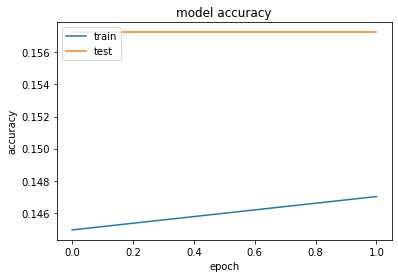

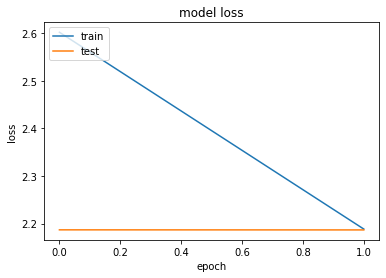

In [122]:
# accuracy plot
fig1 = plt.figure()
plt.plot(epoch_train_acc)
plt.plot(epoch_validation_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig1.savefig("multisize_accuracy.png")

# loss plot
fig2 = plt.figure()
plt.plot(epoch_train_loss)
plt.plot(epoch_validation_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig2.savefig("multisize_loss.png")

### 混同行列

In [75]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7 ,8], ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "None"])
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7 ,8], ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "None"])
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

- validation confmat

Confusion matrix, without normalization
Normalized confusion matrix


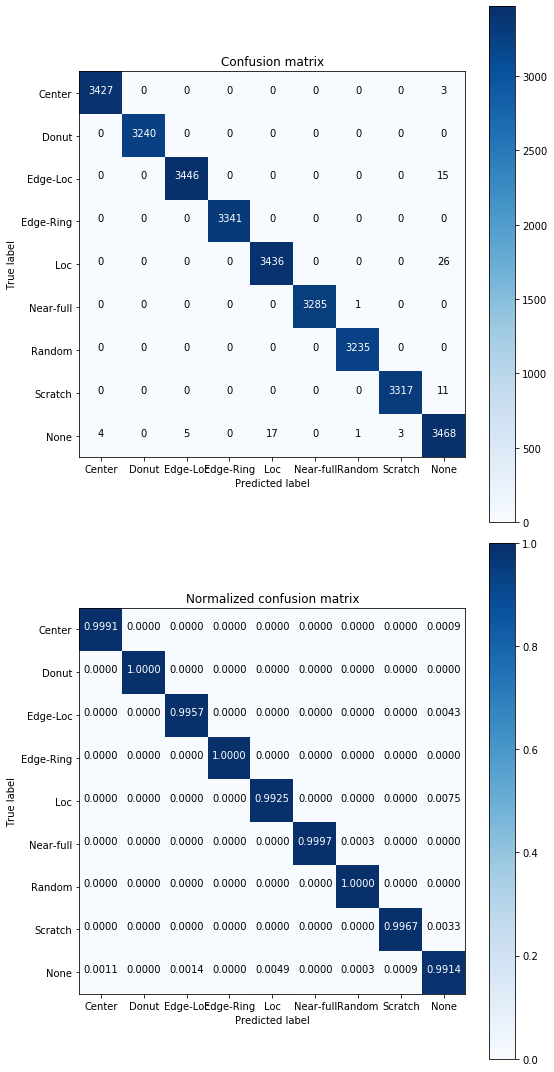

In [76]:
# Compute confusion matrix
y_validation_predict = np.argmax(model.predict(x_validation), axis=1)
y_validation_max = np.argmax(y_validation, axis=1)
cnf_matrix = confusion_matrix(y_validation_max, y_validation_predict)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()
fig.savefig("multisize_valiconfmat.png")

- test confmat

Confusion matrix, without normalization
Normalized confusion matrix


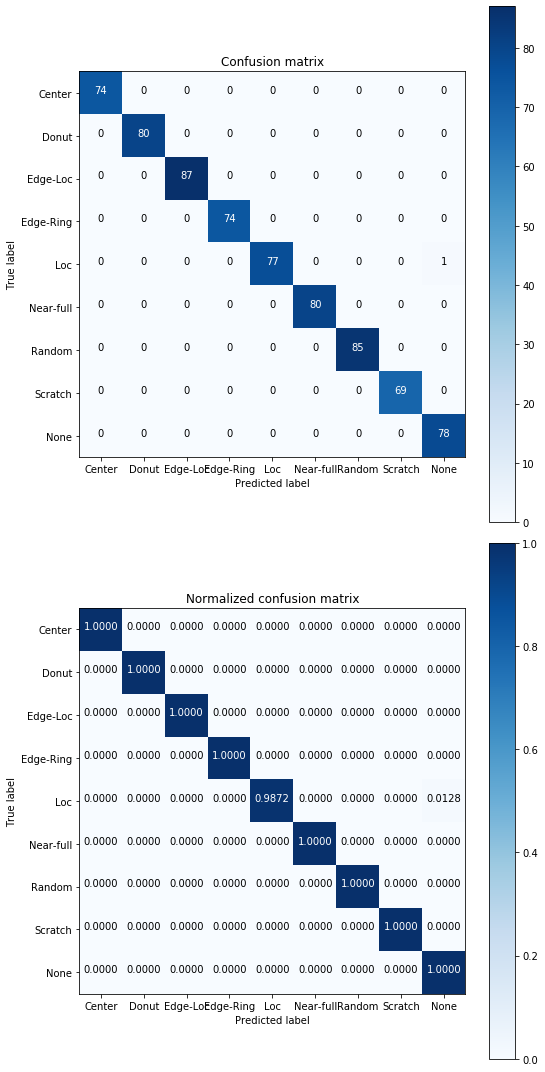

In [77]:
# Compute confusion matrix
y_test_predict = np.argmax(model.predict(x_test), axis=1)
y_test_max = np.argmax(y_test, axis=1)
cnf_matrix = confusion_matrix(y_test_max, y_test_predict)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()
fig.savefig("multisize_testconfmat.png")

In [3]:
import requests

# LINEの設定
path = './lineapi.txt'
with open(path) as f:
    s = f.read()
    line_token = s.rstrip('\n')

# LINEに通知する関数
def line_notify(text):
    url = "https://notify-api.line.me/api/notify"
    data = {"message": text}
    headers = {"Authorization": "Bearer " + line_token}
    proxies = {
        'http': 'http://proxy.uec.ac.jp:8080',
        'https': 'https://proxy.uec.ac.jp:8080',
    }
    requests.post(url, data=data, headers=headers, proxies=proxies)

# LINEに画像を送る関数
def line_notify_img(text, imgpath):
    url = "https://notify-api.line.me/api/notify"
    data = {"message": text, "notificationDisabled": True}
    files = {"imageFile": open(imgpath, "rb")}
    headers = {"Authorization": "Bearer " + line_token}
    proxies = {
        'http': 'http://proxy.uec.ac.jp:8080',
        'https': 'https://proxy.uec.ac.jp:8080',
    }
    requests.post(url, data=data, files=files, headers=headers, proxies=proxies)
    
line_notify("学習が終了しました")
# line_notify("Shawon: " + str(shawon) + ", rotation_num: " + str(rotation_num) + ", inversion: " + str(inversion) + ", trials: " + str(trials))
line_notify_img("正解率", "multisize_accuracy.png")
line_notify_img("Loss", "multisize_loss.png")
line_notify_img("validation混同行列", "multisize_valiconfmat.png")
line_notify_img("test混同行列", "multisize_testconfmat.png")
line_notify("train:" + str(trainscore) + "\nvali:" + str(valiscore) + "\ntest:" + str(testscore))